# Model the data to create nice visualisations for samples binned in $R, R_g$ and also in different bins of $|z|$

In [1]:
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
import warnings
warnings.filterwarnings('ignore')

import pathlib
import astropy.coordinates as coord
import astropy.table as at
import astropy.units as u
import gala.dynamics as gd
import gala.potential as gp
import jax
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import torusimaging as oti
from astropy.constants import G
from gala.units import galactic
from pyia import GaiaData
from astropy.io import fits 
import tqdm
import cmasher as cm
import os
import jax.numpy as jnp
import model_radial_old as model_radial

jax.config.update("jax_enable_x64", True)

In [17]:
# LOAD THE DATA
path = '/Users/dhortad/Documents/Data/allstar-dr17-StarHorse-Gaiadr3-astroNNages'
tb = fits.open(path)
data = tb[1].data 

wmask = np.load('/Users/dhortad/Projects/Torusimaging-radial/sav/parent-paper.npy', allow_pickle=True)
print(len(data[wmask]))

91082


what is the $z$ distribution of the data: constrained to $|z|<0.5$ kpc and $|v_z|<30$ km/s; also $|R-R_g|<3$ kpc and $|v_R|<100$ km/s

Define kinematic coords

In [18]:
import astropy.units as u
x = data['xyz'][:,0]
y = data['xyz'][:,1]
z = data['xyz'][:,2]
vx = data['vxyz'][:,0]
vy = data['vxyz'][:,1]
vz = data['vxyz'][:,2]
vz = (vz*u.km/u.s)
vz = vz.to(u.kpc/u.Gyr)
x = x*u.kpc
y = y*u.kpc
z = z*u.kpc

# Eilers rotation curve
Rgal = np.sqrt(data['xyz'][:,0]**2+data['xyz'][:,1]**2)
# vcirc_eilers = 229.-1.7*(Rgal-8.275)
vcirc = -229.
Rg = (data['L'][:,2]/vcirc)
deltaR = Rgal-Rg
phi_deg = np.arctan(data['xyz'][:,1]/data['xyz'][:,0]) *(180./np.pi)
phi = np.arctan(data['xyz'][:,1]/data['xyz'][:,0])

#transform to cylindrical velocities
vR = +data['vxyz'][:,0]*np.cos(phi)+data['vxyz'][:,1]*np.sin(phi)
vt = -data['vxyz'][:,0]*np.sin(phi)+data['vxyz'][:,1]*np.cos(phi)

In [19]:
max_Rg = 3 * u.kpc
max_vR = 100 * u.km / u.s
bins = {
    "pos": np.linspace(-1, 1, 81) * max_Rg,
    "vel": np.linspace(-1, 1, 81) * max_vR,
}


In [20]:
x_param = deltaR * u.kpc
y_param = vR * u.km/u.s
label = data['MG_FE']
label_err = data['MG_FE_ERR']

bdata = oti.data.get_binned_label(
    pos=x_param[wmask].astype(np.float32),
    vel=y_param[wmask].astype(np.float32),
    label=label[wmask].astype(np.float32),
    label_err=label_err[wmask].astype(np.float32),
    bins=bins,
    units=galactic,
    s_N_thresh=16,
)

model, bounds, init_params = model_radial.TorusImaging1DSpline.auto_init(
    bdata,
    label_knots=8,
    e_knots={1: 8, 2: 12, 3: 4, 4: 4},
    label_l2_sigma=1.0,
    label_smooth_sigma=0.5,
    e_l2_sigmas={1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0},
    e_signs={1: -1, 3: -1},
    e_smooth_sigmas={1: 0.1, 2: 0.1, 3: 0.1, 4: 0.1},
    dacc_strength=0.0,
    label_knots_spacing_power=0.75,
    e_knots_spacing_power=0.5,
)


In [21]:
# dunno why but these are initialised differently; doesn't make much difference but APW initialised like this so I ran with it
init_params["e_params"][1]["vals"] = np.full_like(
    init_params["e_params"][1]["vals"], np.log(0.05 / model._label_knots.max())
)
init_params["e_params"][2]["vals"] = np.full_like(
    init_params["e_params"][2]["vals"], -0.5
)
init_params["e_params"][3]["vals"] = np.full_like(
    init_params["e_params"][3]["vals"], np.log(0.05 / model._label_knots.max())
)
init_params["e_params"][4]["vals"] = np.full_like(
    init_params["e_params"][4]["vals"], np.log(0.05 / model._label_knots.max())
)

# model in bins of $R_g$

In [22]:
Rgal_cs = np.linspace(5,12,15)
bin_centers = Rgal_cs+0.5
bin_centers

array([ 5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5,
       11. , 11.5, 12. , 12.5])

14it [00:42,  3.02s/it]


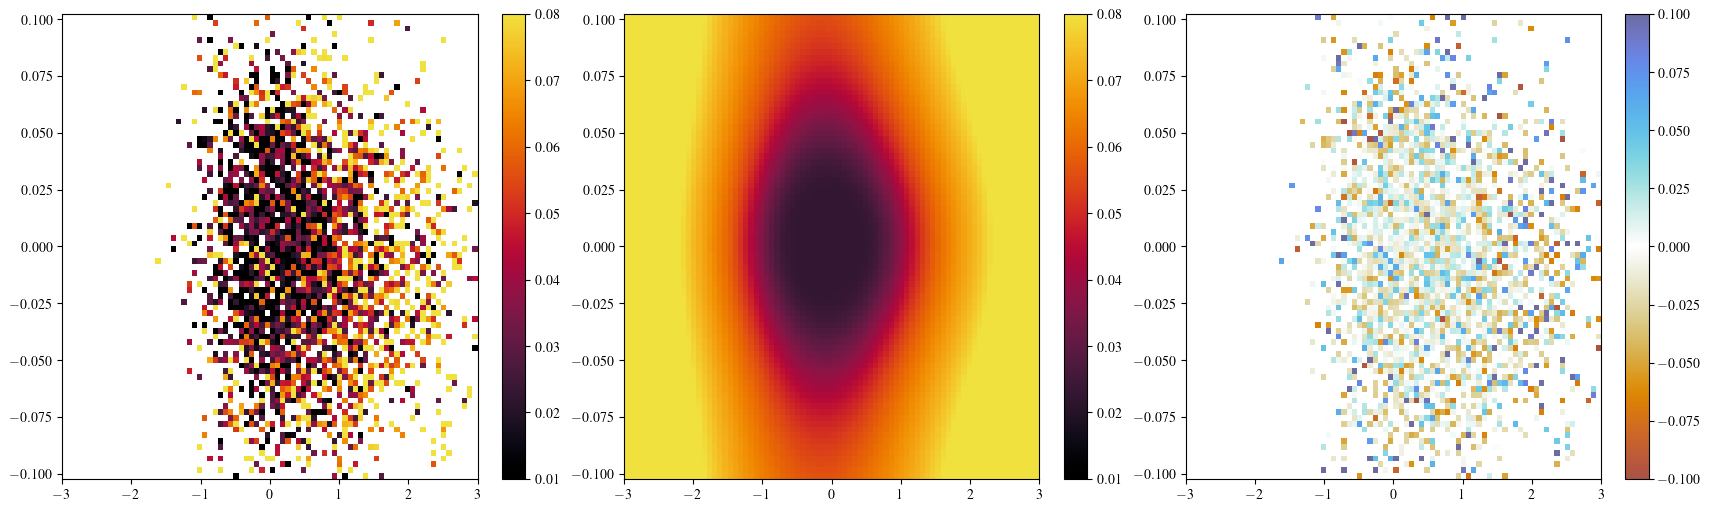

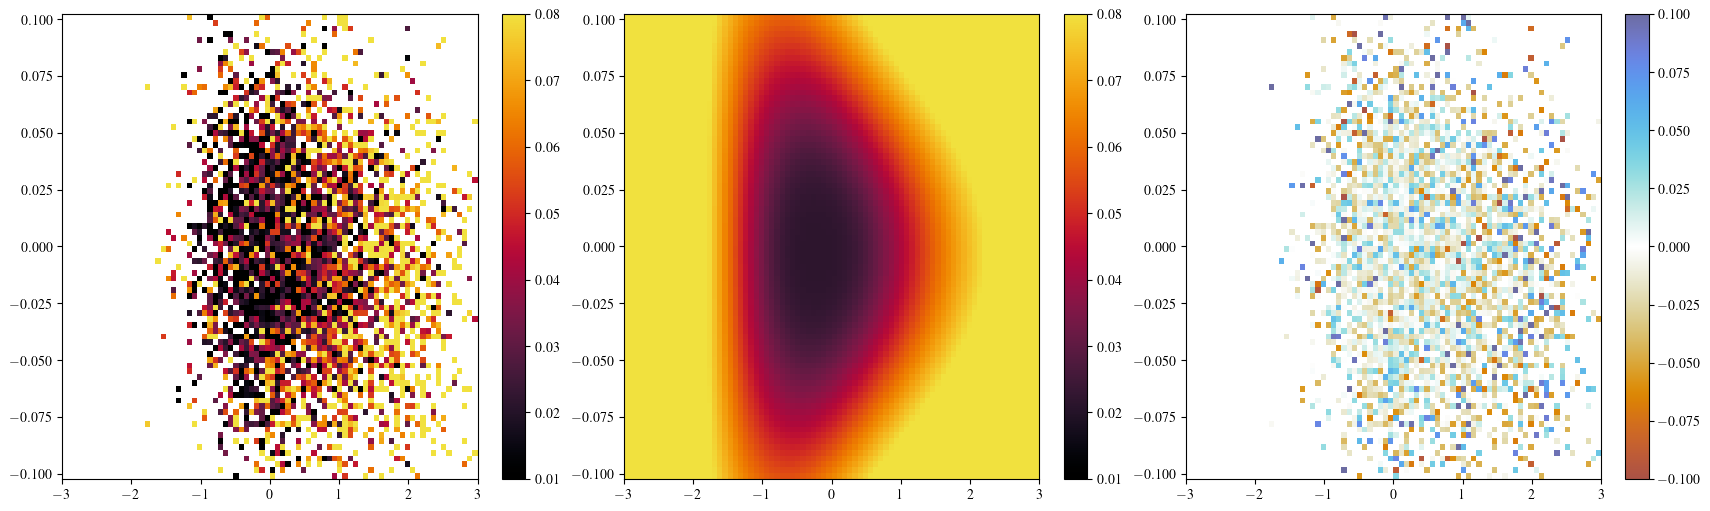

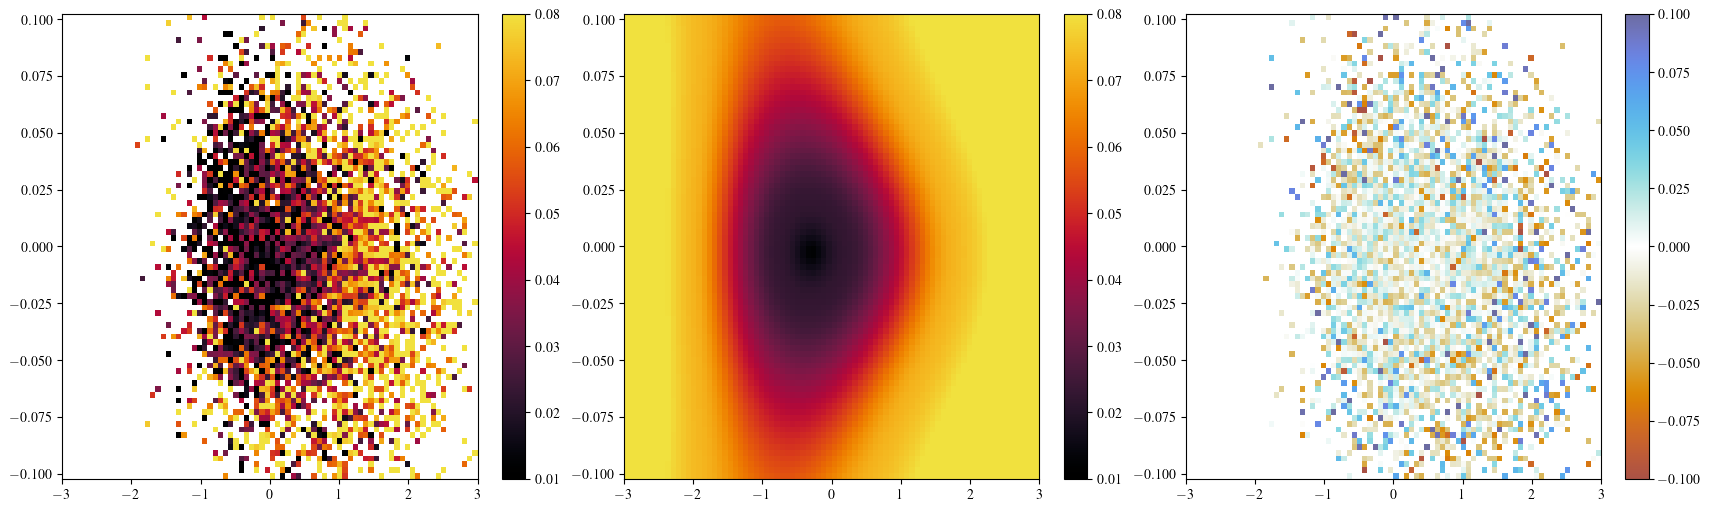

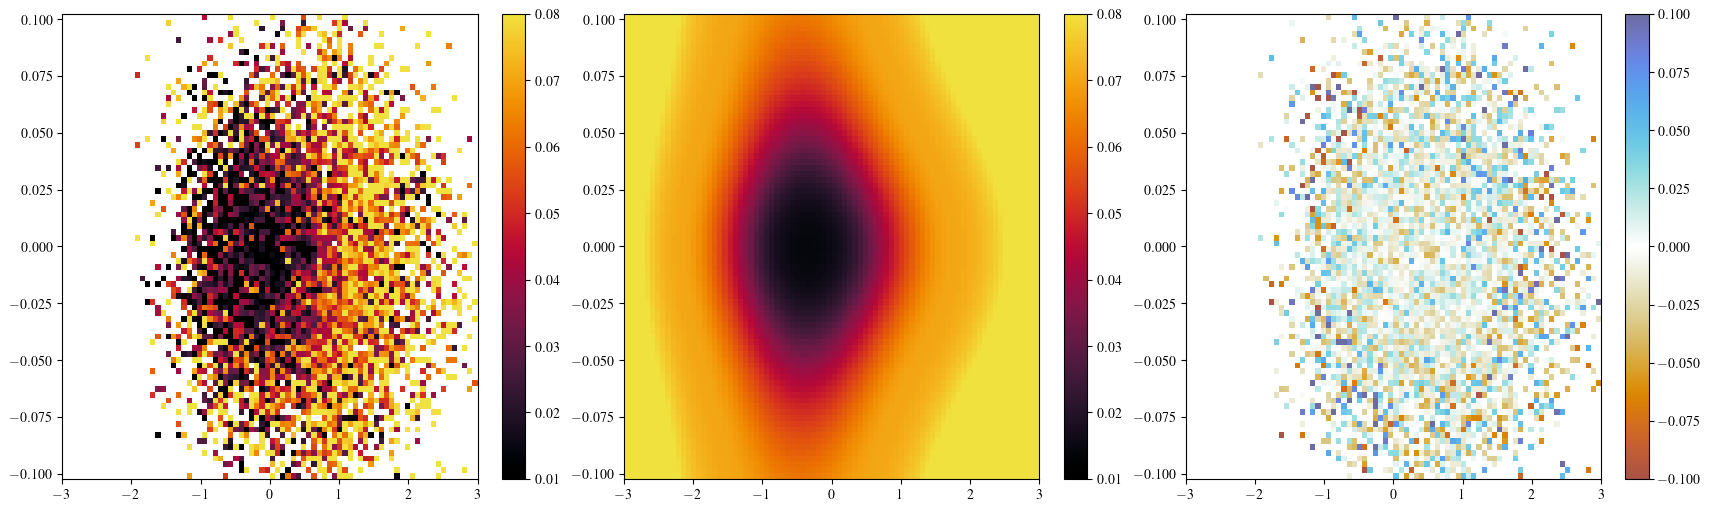

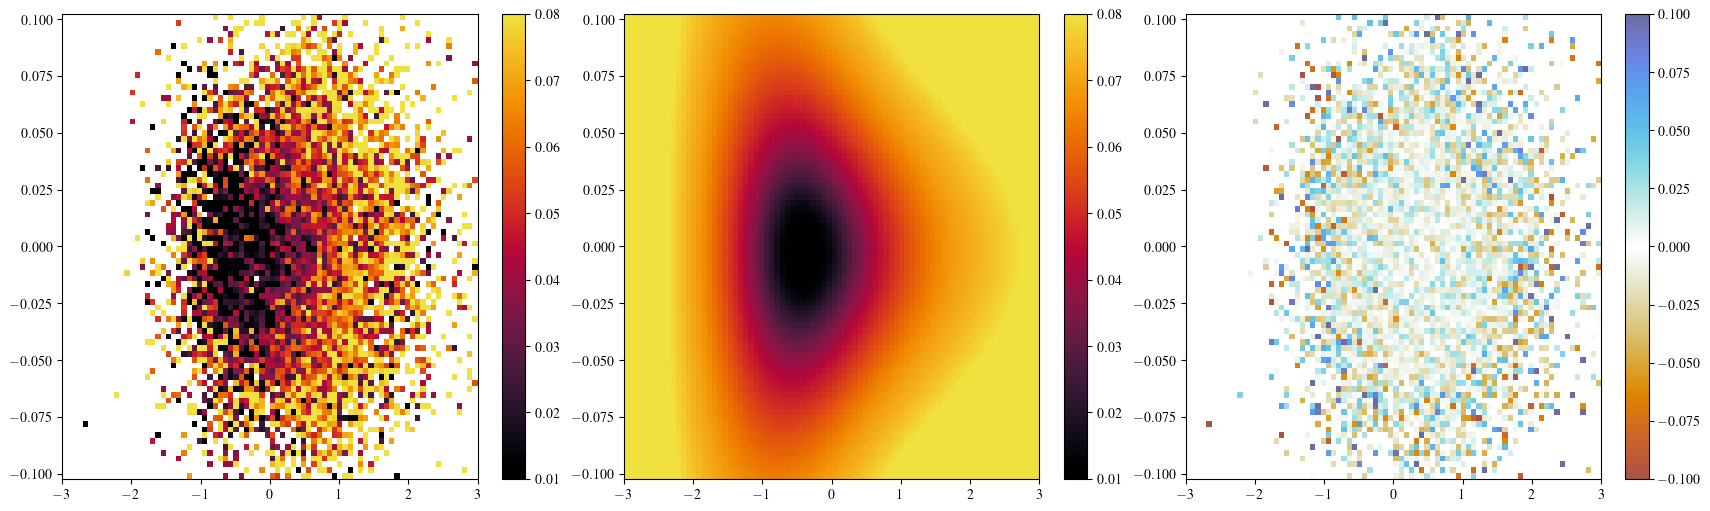

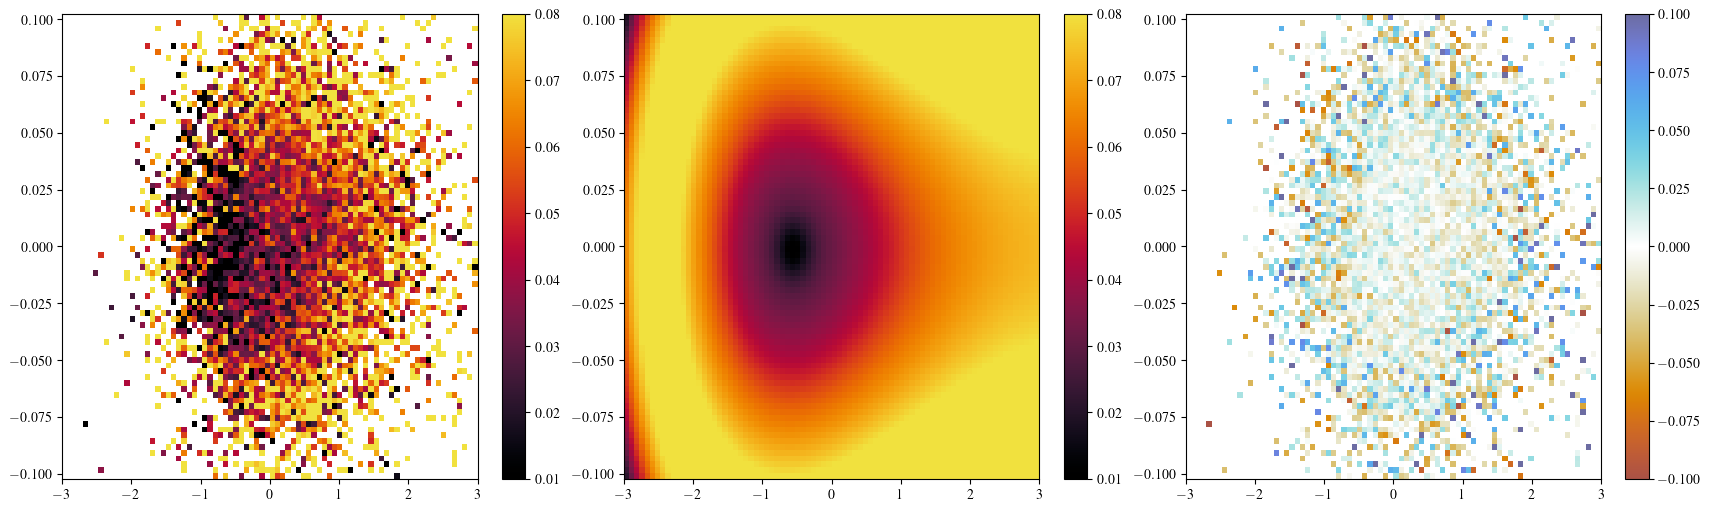

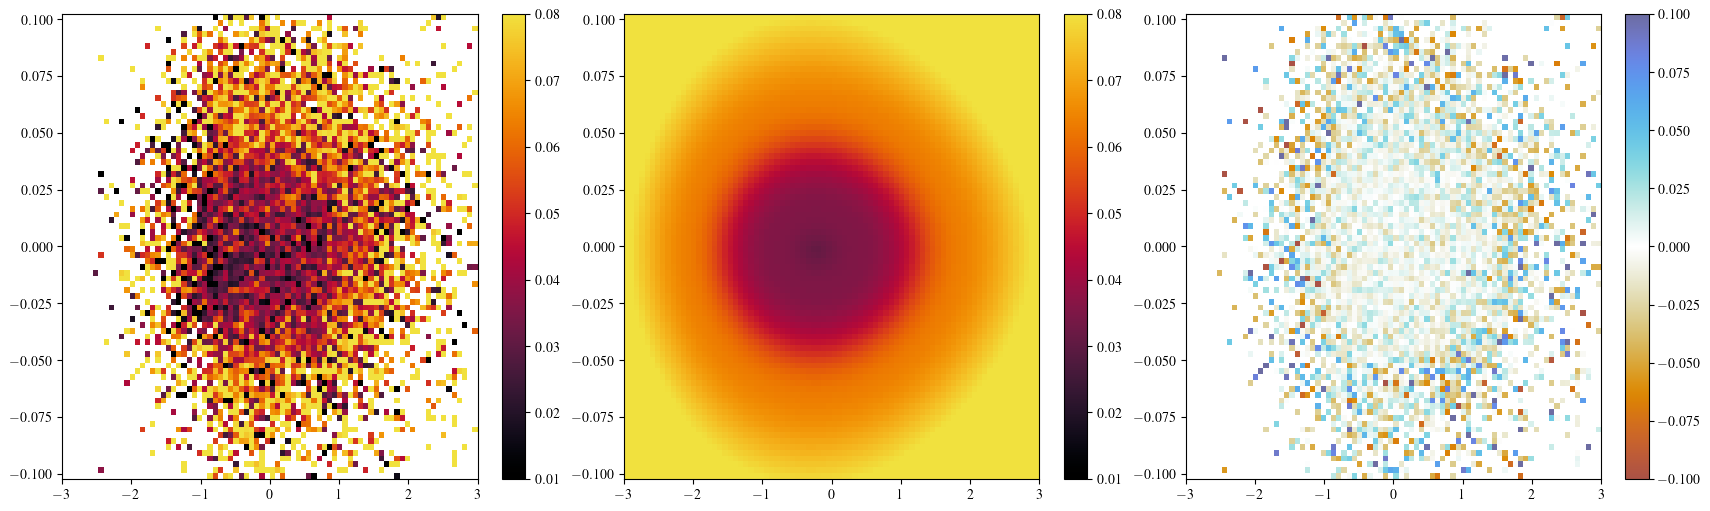

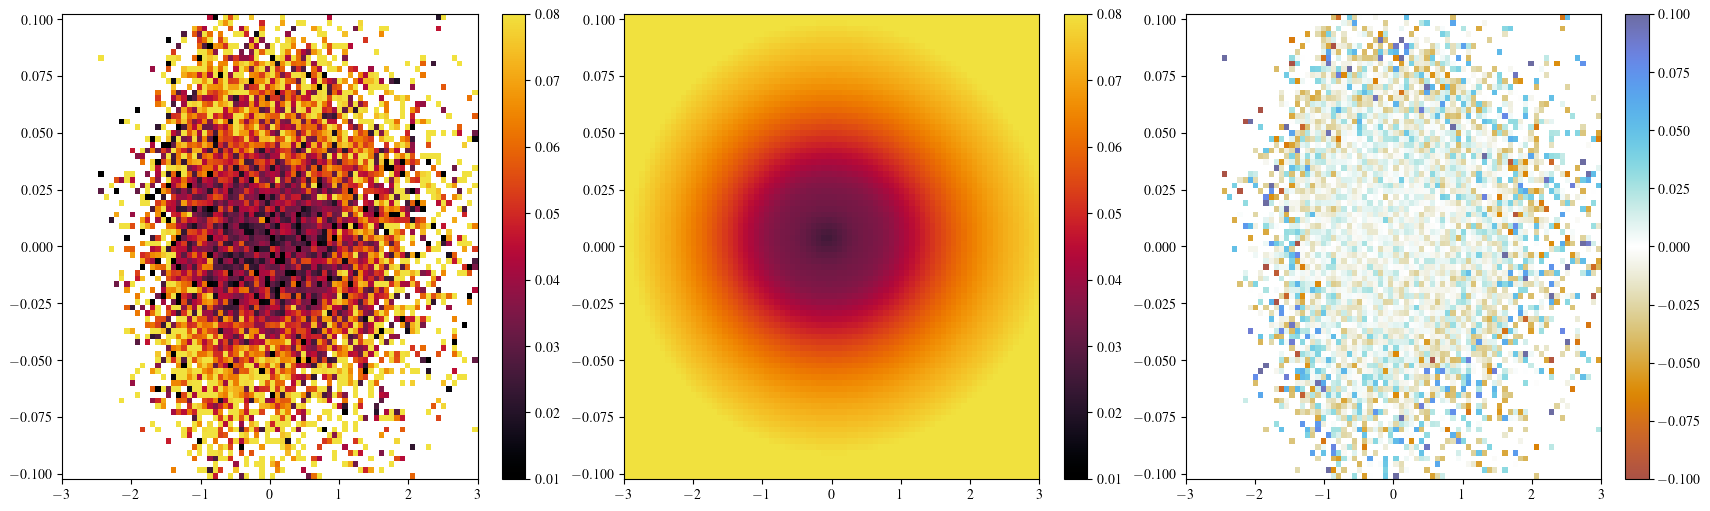

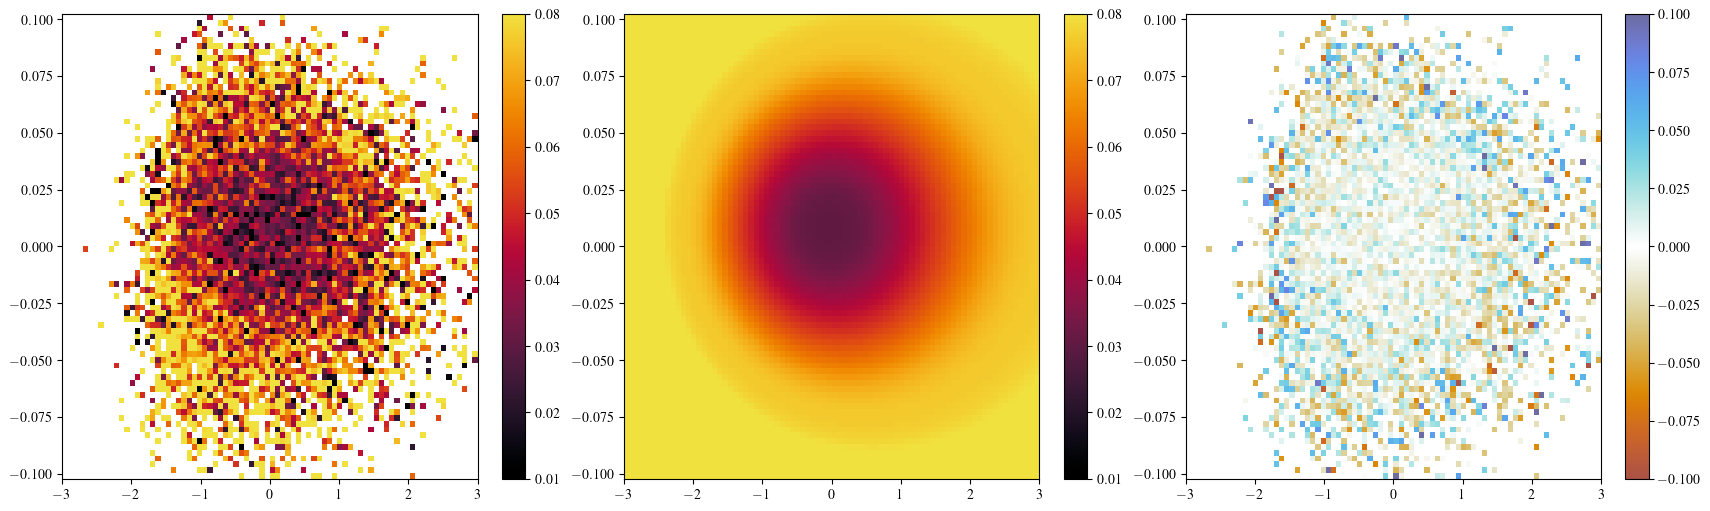

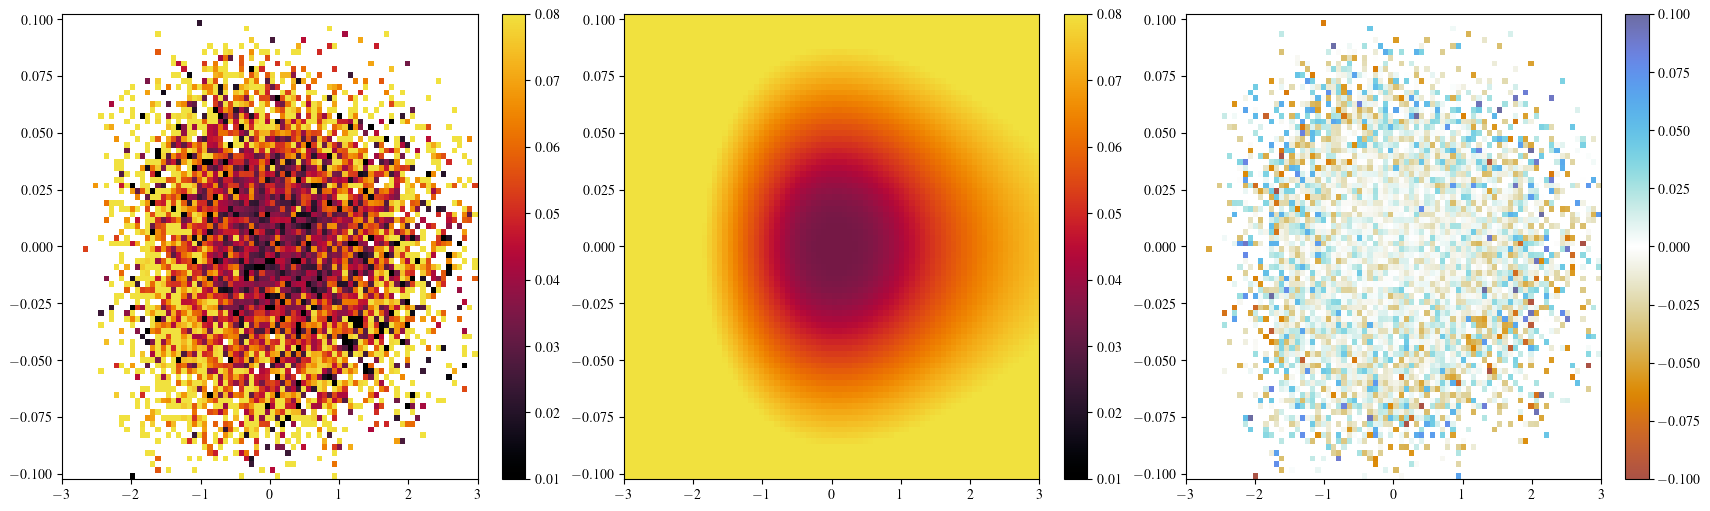

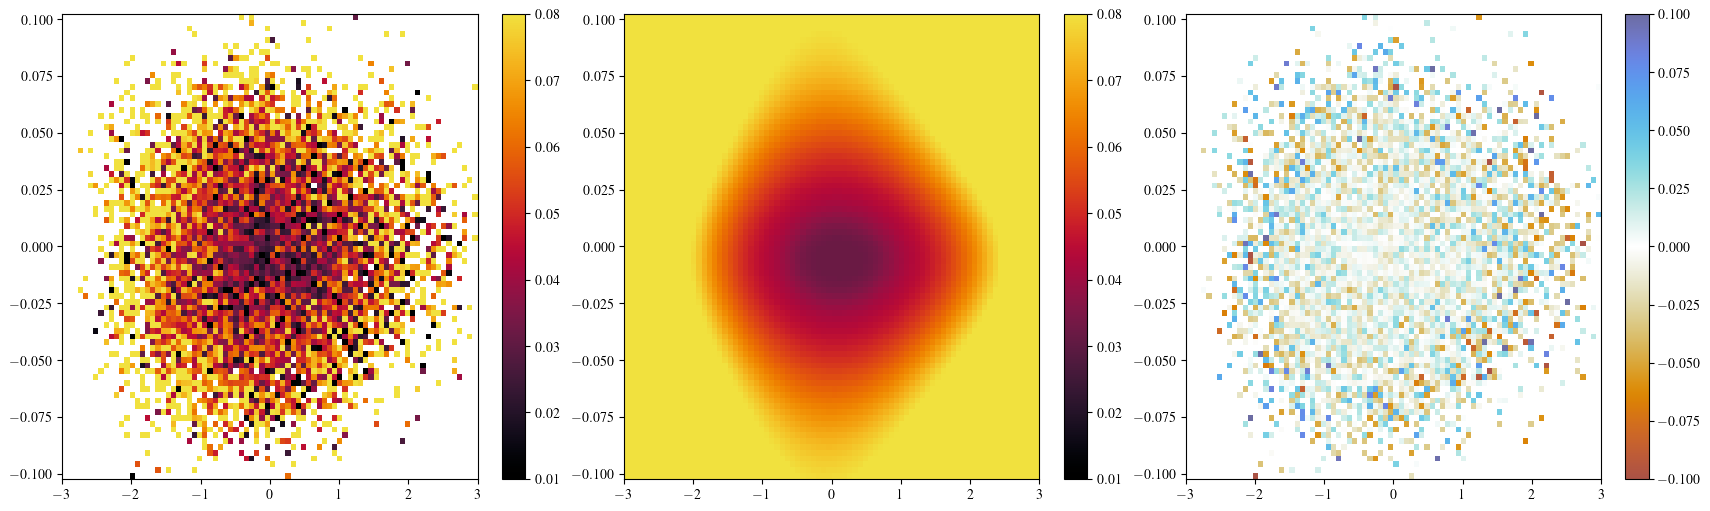

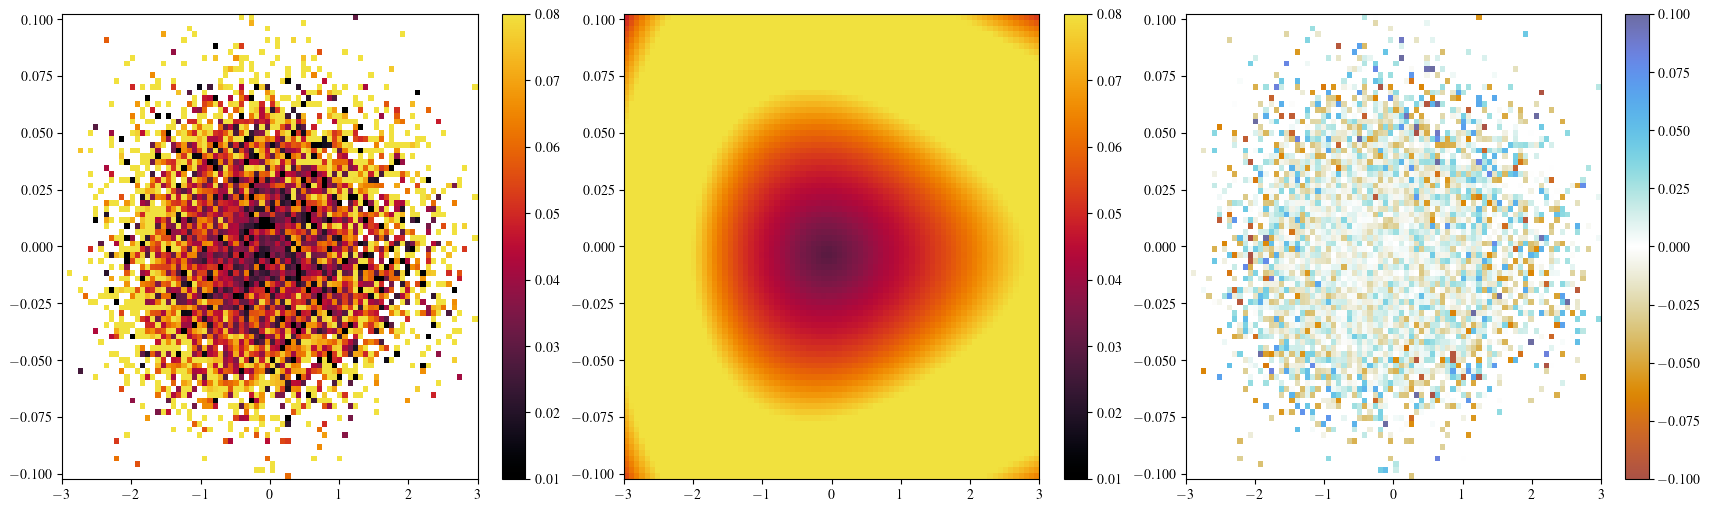

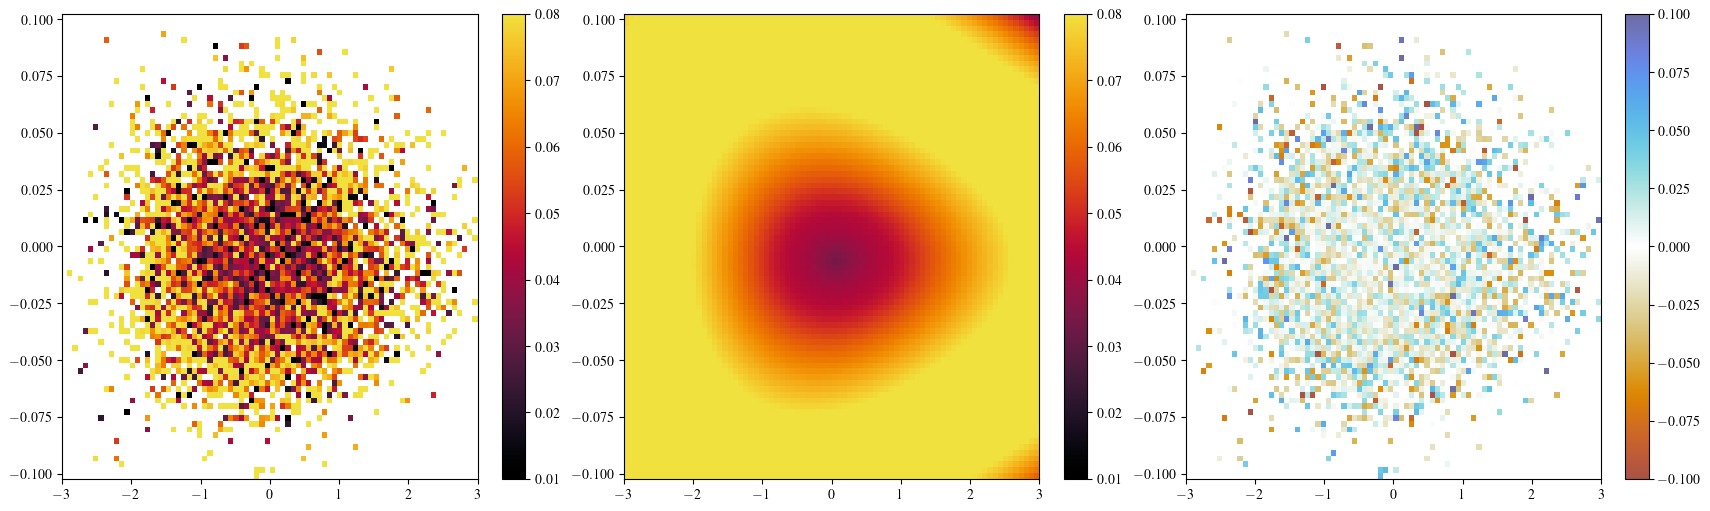

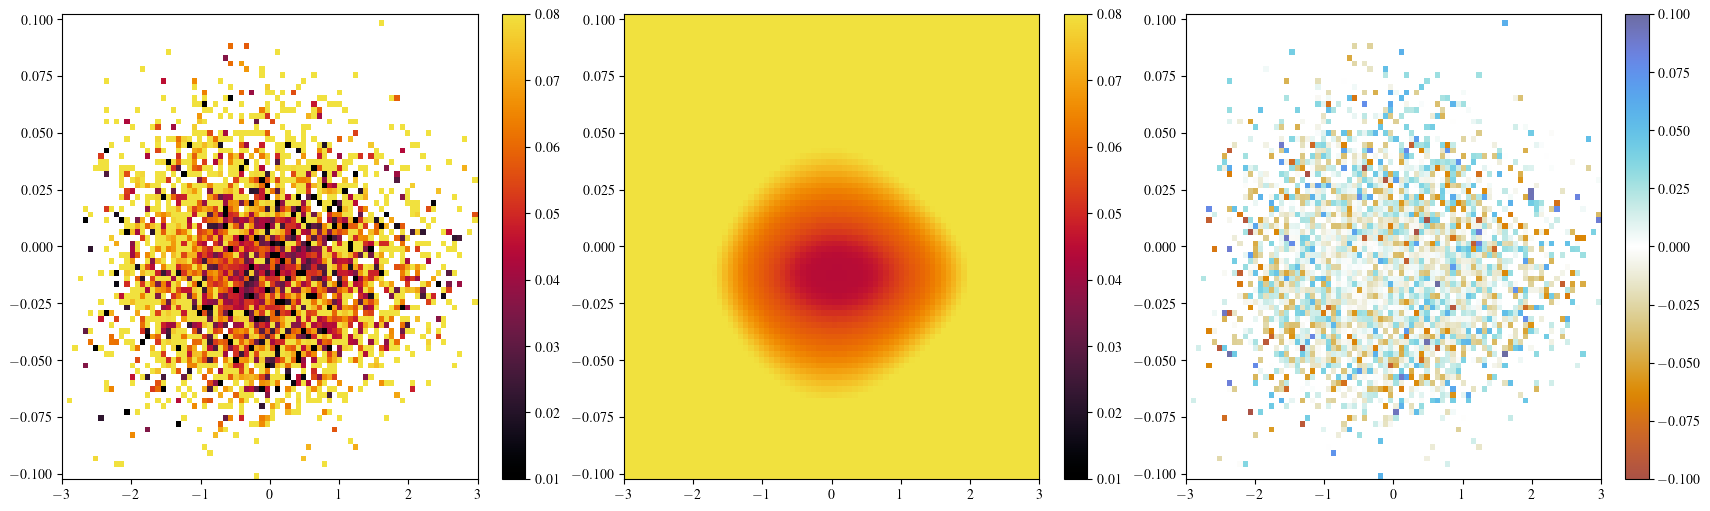

In [23]:
Rgal_cs = np.linspace(5,12,15)
bdatas = []
reses = []

for indx, Rg_c in tqdm.tqdm(enumerate(Rgal_cs[:-1])):
    Rg_l, Rg_r = (Rg_c, Rg_c + 1)
    Rg_mask = (Rg > Rg_l) & (Rg <= Rg_r)
    # wmask already has these cuts: (np.abs(z)<0.5*u.kpc)&(np.abs(deltaR)<3)&(np.abs(vz)<30*u.kpc/u.Gyr)&(Rgal<20)&(Rgal>0)&(np.abs(vR)<100)
    x_param = deltaR[wmask&Rg_mask] * u.kpc
    y_param = vR[wmask&Rg_mask] * u.km/u.s
    label = data['MG_FE'][wmask&Rg_mask]
    label_err = data['MG_FE_ERR'][wmask&Rg_mask]

    bdata = oti.data.get_binned_label(
        
        pos=x_param.astype(np.float32),
        vel=y_param.astype(np.float32),
        label=label.astype(np.float32),
        label_err=label_err.astype(np.float32),
        bins=bins,
        units=galactic,
        s_N_thresh=2,
    )

    bdata_clean = dict(
        pos=bdata["pos"],
        vel=bdata["vel"],
        label=bdata["label"],
        label_err=bdata["label_err"],
    )
    bdata_mask = (
        np.isfinite(bdata["label"])
        & np.isfinite(bdata["label_err"])
        & (bdata["label_err"] > 0)
    )
    bdata_clean = {k: v[bdata_mask] for k, v in bdata_clean.items()}

    res = model.optimize(init_params, objective="gaussian", bounds=bounds, **bdata_clean)
    
    # Plot the data 
    fig, axes = plt.subplots(1, 3, figsize=(17, 5), constrained_layout=True)
    cs = axes[0].pcolormesh(
        bdata["pos"].value,
        bdata["vel"].value,
        bdata["label"],
        cmap=cm.ember,
        vmin=0.01,
        vmax=0.08,
    )
    fig.colorbar(cs, ax=axes[0])

    model_label = model._get_label(pos=bdata["pos"], vel=bdata["vel"], params=res.params)

    cs = axes[1].pcolormesh(
        bdata["pos"].value,
        bdata["vel"].value,
        model_label,
        cmap=cm.ember,
        vmin=0.01,
        vmax=0.08,
    )
    fig.colorbar(cs, ax=axes[1])

    # for ss in [1, -1]:
    #     axes[1].scatter(ss * 0.1 * np.sqrt(init_Omega.value), 0., color='tab:green')
    #     axes[1].scatter(0., ss * 0.1 / np.sqrt(init_Omega.value), color='tab:green')

    cs = axes[2].pcolormesh(
        bdata["pos"].value, bdata["vel"].value, bdata["label"]-model_label, cmap=cm.prinsenvlag,
        vmin=-0.1,
        vmax=0.1,
    )
    fig.colorbar(cs, ax=axes[2])


    bdatas.append(bdata_clean)
    reses.append(res)



3it [00:07,  2.35s/it]


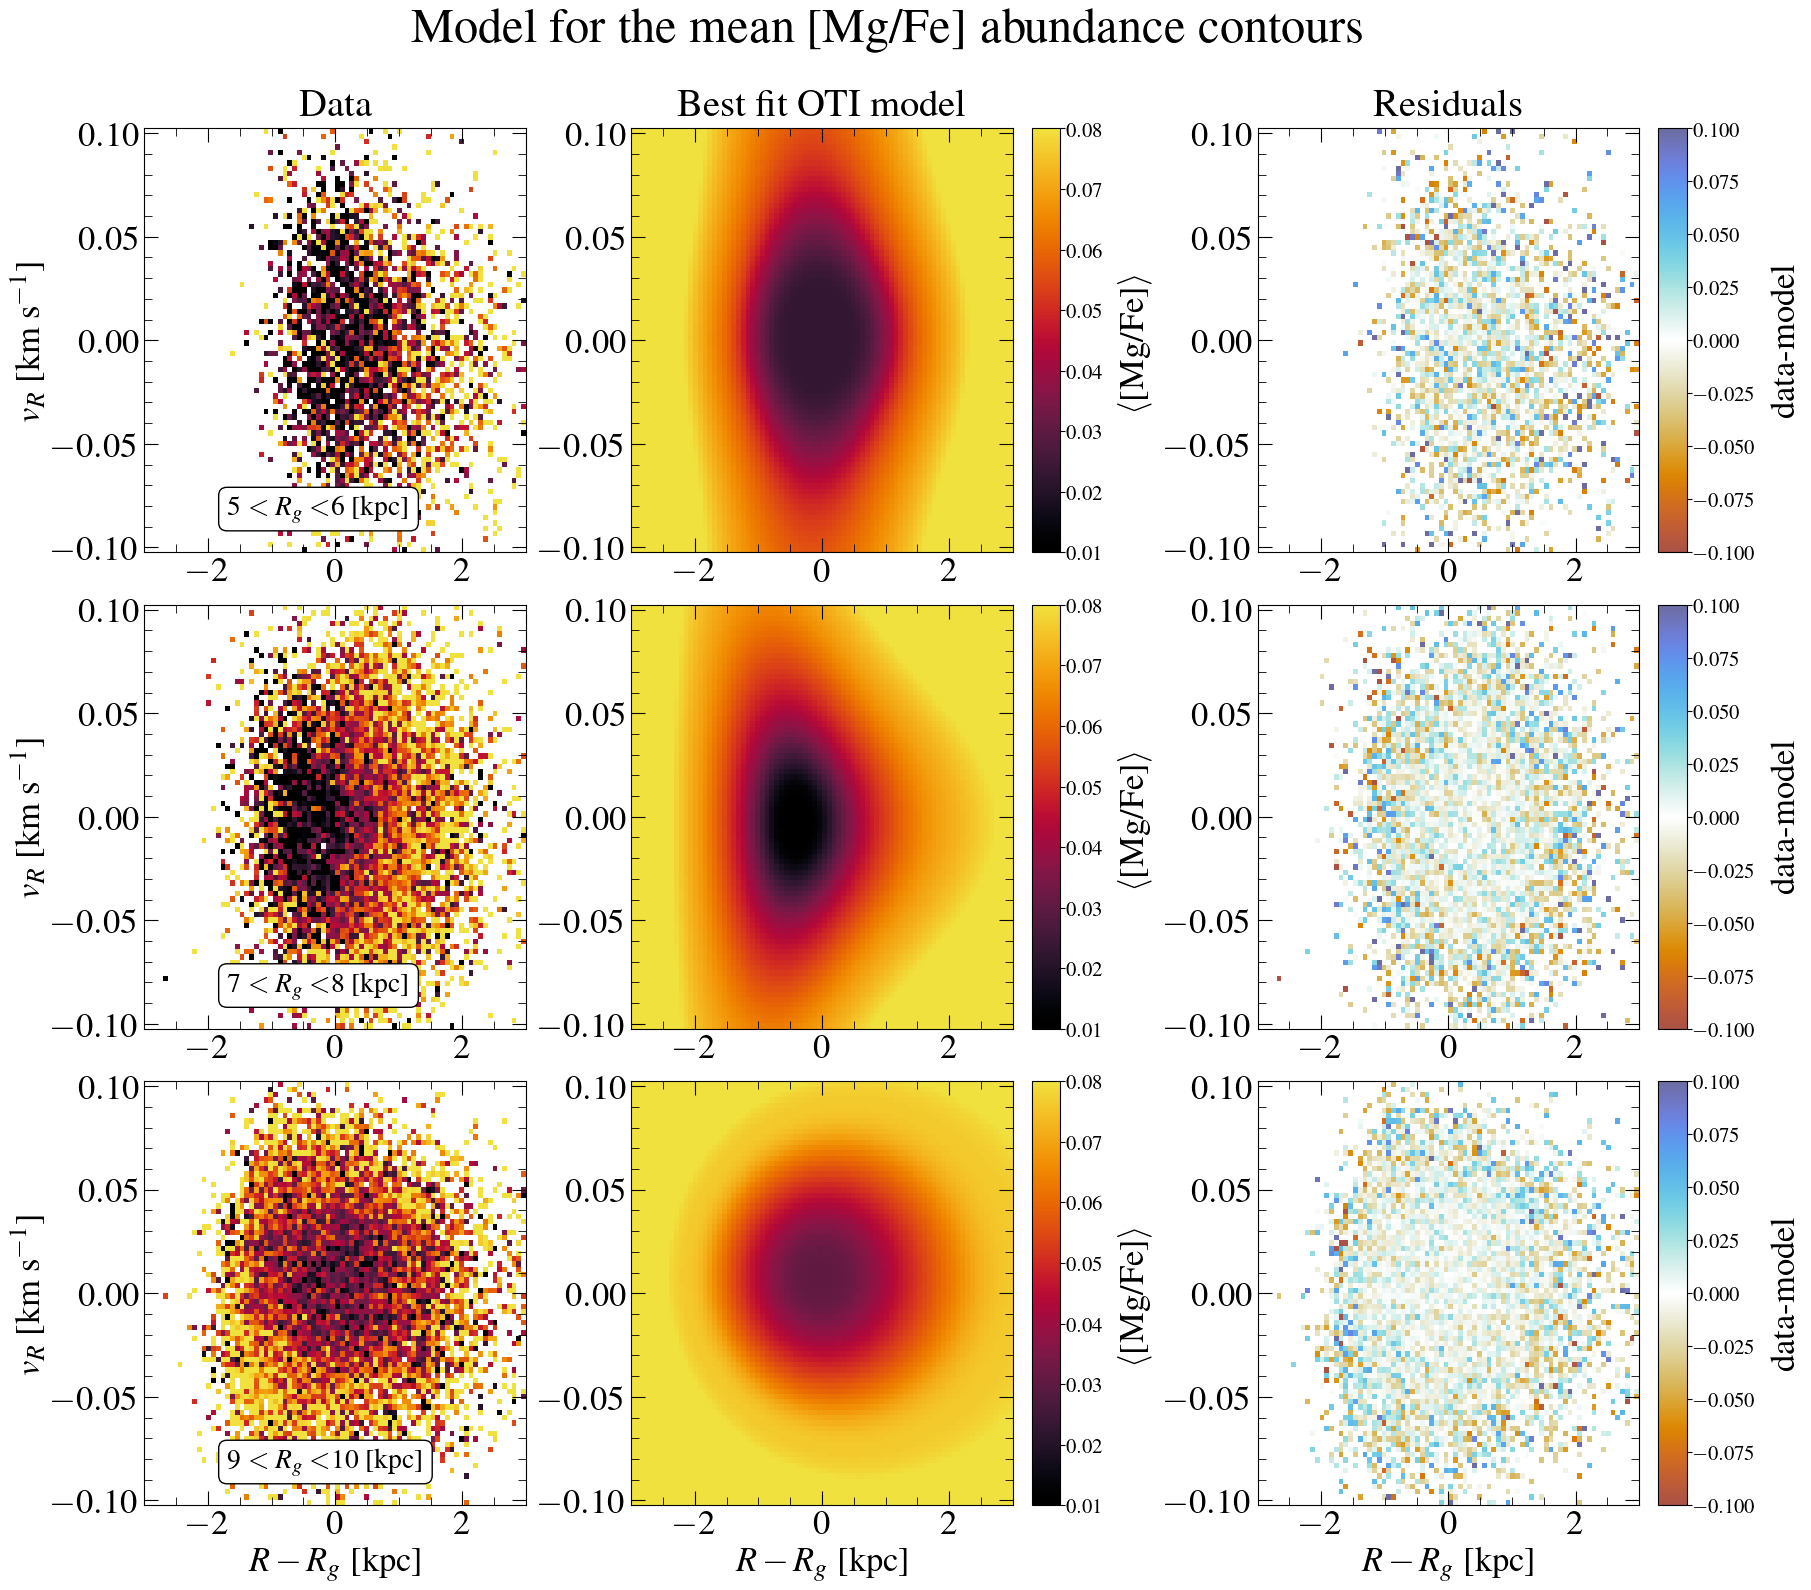

In [24]:
Rgal_css = np.array([5,7,9])

fig, axes = plt.subplots(3, 3, figsize=(18, 15), constrained_layout=True)
fig.suptitle('Model for the mean [Mg/Fe] abundance contours',fontsize=35,x=0.49,y=1.05)

for indx, Rg_c in tqdm.tqdm(enumerate(Rgal_css)):
    Rg_l, Rg_r = (Rg_c, Rg_c + 1)
    Rg_mask = (Rg > Rg_l) & (Rg <= Rg_r)
    # wmask already has these cuts: (np.abs(z)<0.5*u.kpc)&(np.abs(deltaR)<2)&(np.abs(vz)<30*u.kpc/u.Gyr)&(Rgal<20)&(Rgal>0)&(np.abs(vR)<100)
    x_param = deltaR[wmask&Rg_mask] * u.kpc
    y_param = vR[wmask&Rg_mask] * u.km/u.s
    label = data['MG_FE'][wmask&Rg_mask]
    label_err = data['MG_FE_ERR'][wmask&Rg_mask]

    bdata = oti.data.get_binned_label(
        
        pos=x_param.astype(np.float32),
        vel=y_param.astype(np.float32),
        label=label.astype(np.float32),
        label_err=label_err.astype(np.float32),
        bins=bins,
        units=galactic,
        s_N_thresh=2,
    )

    bdata_clean = dict(
        pos=bdata["pos"],
        vel=bdata["vel"],
        label=bdata["label"],
        label_err=bdata["label_err"],
    )
    bdata_mask = (
        np.isfinite(bdata["label"])
        & np.isfinite(bdata["label_err"])
        & (bdata["label_err"] > 0)
    )
    bdata_clean = {k: v[bdata_mask] for k, v in bdata_clean.items()}

    res = model.optimize(init_params, objective="gaussian", bounds=bounds, **bdata_clean)

    props = dict(boxstyle='round', facecolor='white', alpha=1)
    if indx == 0:
        cs =  axes[indx, 1].pcolormesh(
        bdata["pos"].value,
        bdata["vel"].value,
        model_label,
        cmap=cm.ember,
        vmin=0.01,
        vmax=0.08)

        cs2 = axes[indx, 2].pcolormesh(
        bdata["pos"].value, bdata["vel"].value, bdata["label"]-model_label, cmap=cm.prinsenvlag,
        vmin=-0.1,
        vmax=0.1)

    # Plot the data 
    axes[indx, 0].pcolormesh(
        bdata["pos"].value,
        bdata["vel"].value,
        bdata["label"],
        cmap=cm.ember,
        vmin=0.01,
        vmax=0.08,
    )
    axes[indx, 0].set_ylabel('$v_R$ [km s$^{-1}$]', fontsize=25)
    axes[indx, 0].tick_params(labelsize=25,direction='in',top=True,right=True,length=6)
    axes[indx, 0].tick_params(which='major',labelsize=25,direction='in',top=True,right=True,length=10)
    axes[indx, 0].tick_params(which='minor', length=6, direction='in',top=True,right=True)
    axes[indx, 0].minorticks_on()
    axes[indx,0].text(-1.7,-0.075, str(int(Rg_c))+' $< R_g < $'+str(int(Rg_c)+1)+' [kpc]', fontsize=20,
        verticalalignment='top', bbox=props)
    # fig.colorbar(cs, ax=axes[indx, 0])

    model_label = model._get_label(pos=bdata["pos"], vel=bdata["vel"], params=res.params)

    cs = axes[indx, 1].pcolormesh(
        bdata["pos"].value,
        bdata["vel"].value,
        model_label,
        cmap=cm.ember,
        vmin=0.01,
        vmax=0.08,
    )
    axes[indx, 1].tick_params(labelsize=25,direction='in',top=True,right=True,length=6)
    axes[indx, 1].tick_params(which='major',labelsize=25,direction='in',top=True,right=True,length=10)
    axes[indx, 1].tick_params(which='minor', length=6, direction='in',top=True,right=True)
    axes[indx, 1].minorticks_on()
    cbar = fig.colorbar(cs,  aspect=15,orientation='vertical',location='right')
    cbar.set_label(label=r'$\langle$[Mg/Fe]$\rangle$',fontsize=25,labelpad=10)
    cbar.ax.tick_params(labelsize=15,pad=1)
    cbar.ax.xaxis.set_ticks_position('top')
    cbar.ax.xaxis.set_label_position('top')
    # for ss in [1, -1]:
    #     axes[1].scatter(ss * 0.1 * np.sqrt(init_Omega.value), 0., color='tab:green')
    #     axes[1].scatter(0., ss * 0.1 / np.sqrt(init_Omega.value), color='tab:green')

    cs2 = axes[indx, 2].pcolormesh(
        bdata["pos"].value, bdata["vel"].value, bdata["label"]-model_label, cmap=cm.prinsenvlag,
        vmin=-0.1,
        vmax=0.1,
    )
    cbar2 = fig.colorbar(cs2,  aspect=15,orientation='vertical',location='right')
    cbar2.set_label(label=r'data-model',fontsize=25,labelpad=10)
    cbar2.ax.tick_params(labelsize=15,pad=1)
    cbar2.ax.xaxis.set_ticks_position('top')
    cbar2.ax.xaxis.set_label_position('top')
    axes[indx, 2].tick_params(labelsize=25,direction='in',top=True,right=True,length=6)
    axes[indx, 2].tick_params(which='major',labelsize=25,direction='in',top=True,right=True,length=10)
    axes[indx, 2].tick_params(which='minor', length=6, direction='in',top=True,right=True)
    axes[indx, 2].minorticks_on()


axes[2,0].set_xlabel(r'$R-R_g$ [kpc]', fontsize=25)
axes[2,1].set_xlabel(r'$R-R_g$ [kpc]', fontsize=25)
axes[2,2].set_xlabel(r'$R-R_g$ [kpc]', fontsize=25)

# Titles
title_pad = 10
axes[0,0].set_title("Data", fontsize=28, pad=title_pad)
axes[0,1].set_title("Best fit OTI model", fontsize=28, pad=title_pad)
axes[0,2].set_title("Residuals", fontsize=28, pad=title_pad)

plt.savefig('/Users/dhortad/Projects/Torusimaging-radial/plots/data-model-res-data.pdf',dpi=250, bbox_inches = 'tight')



# Check the e functions for one bin

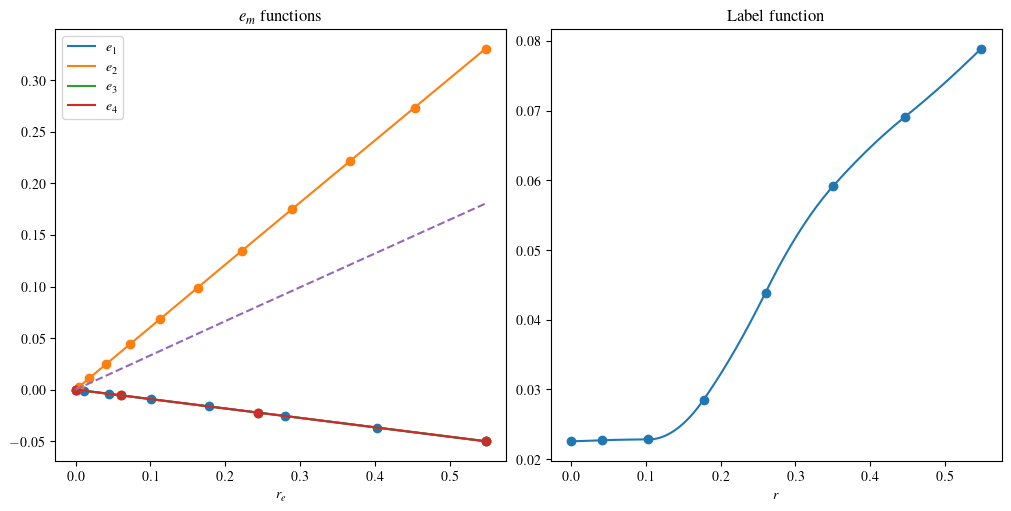

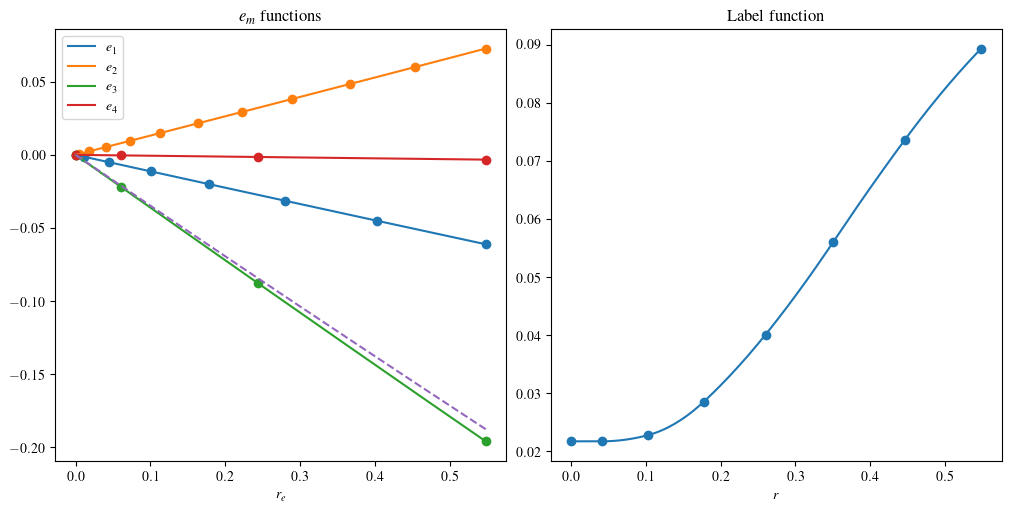

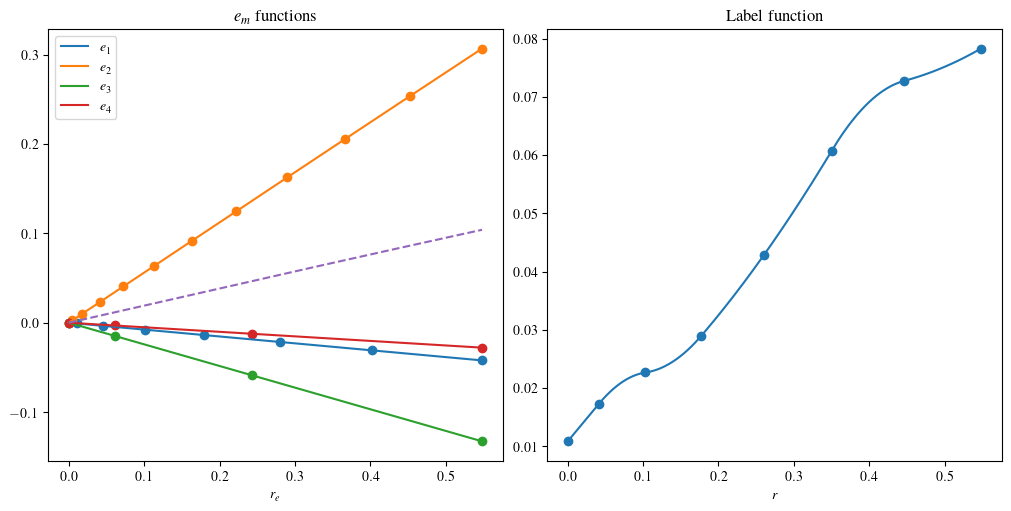

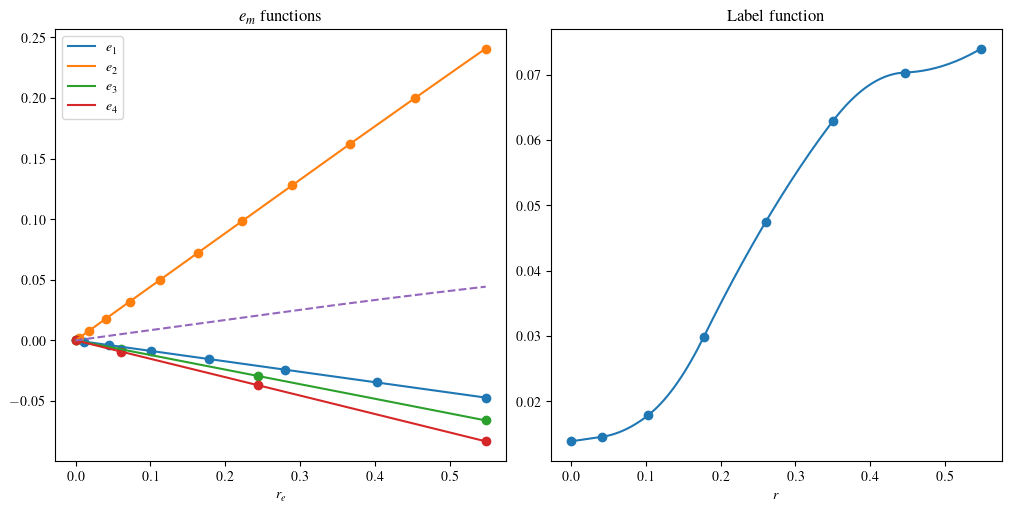

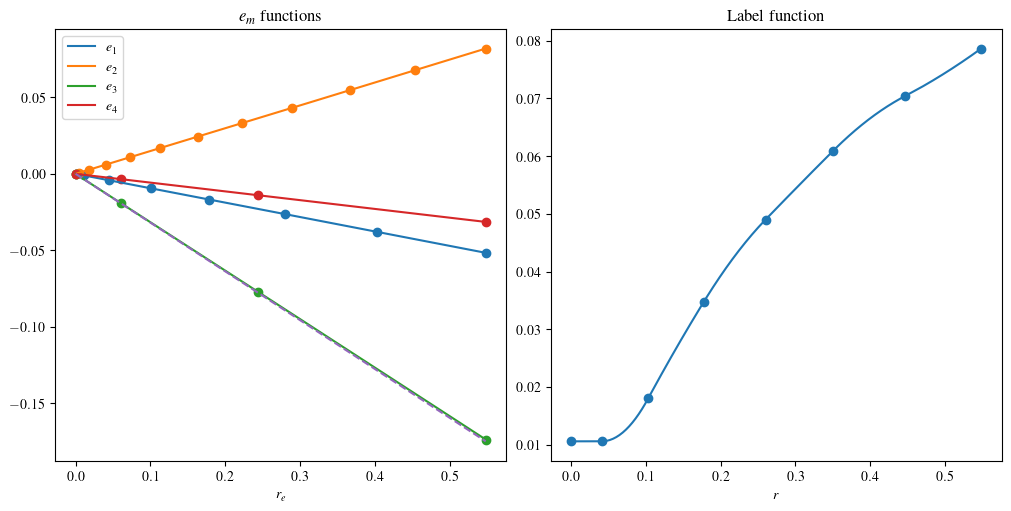

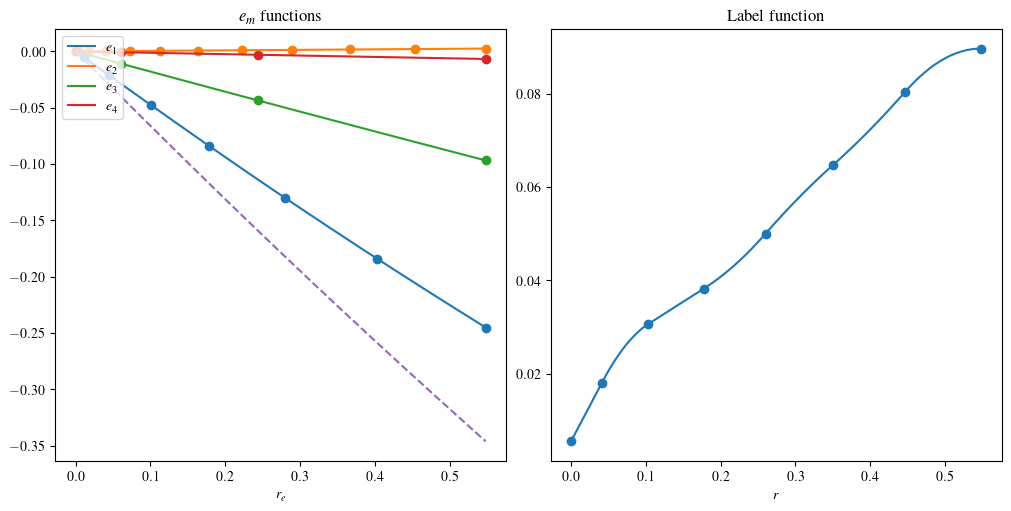

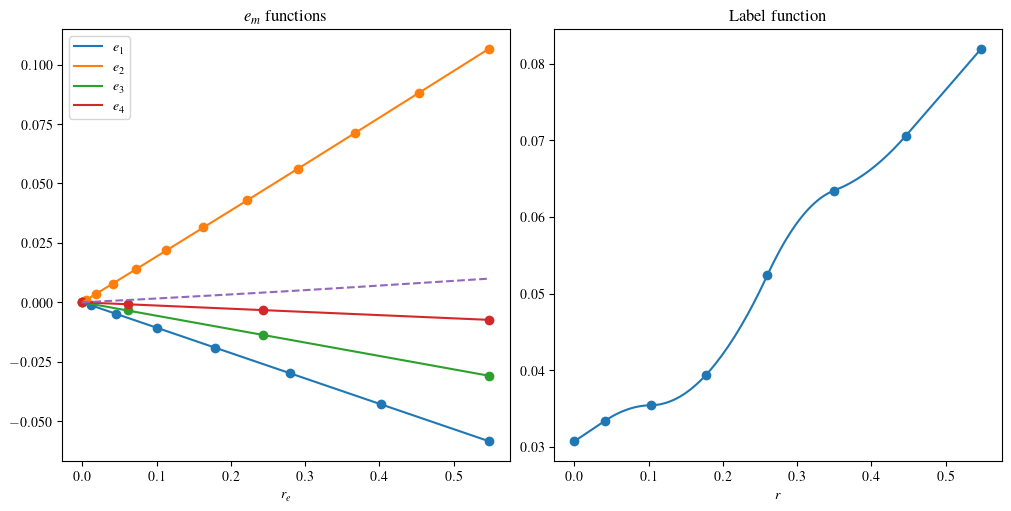

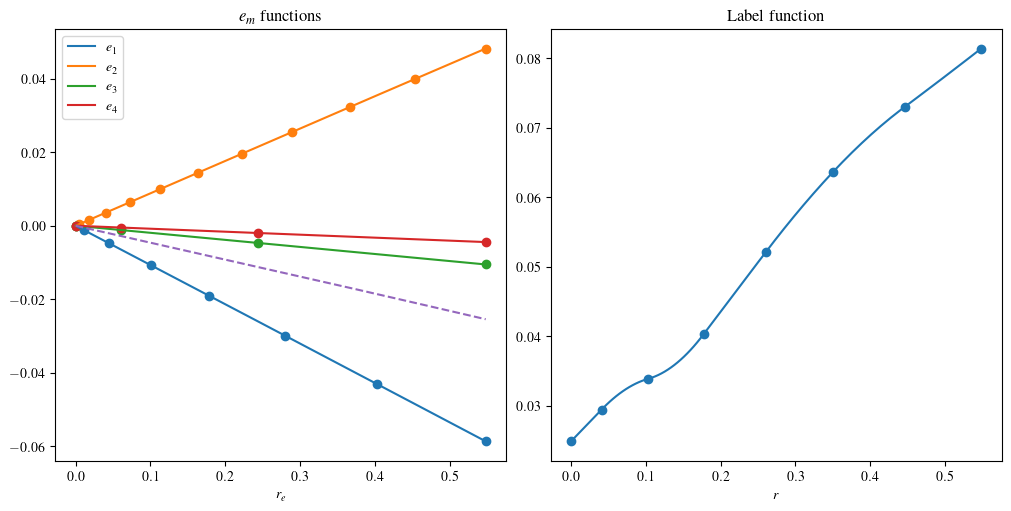

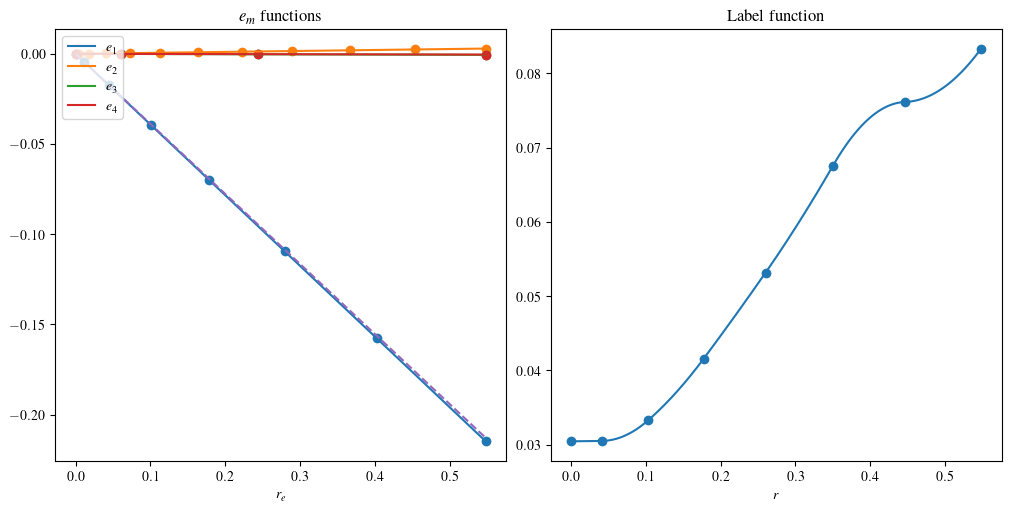

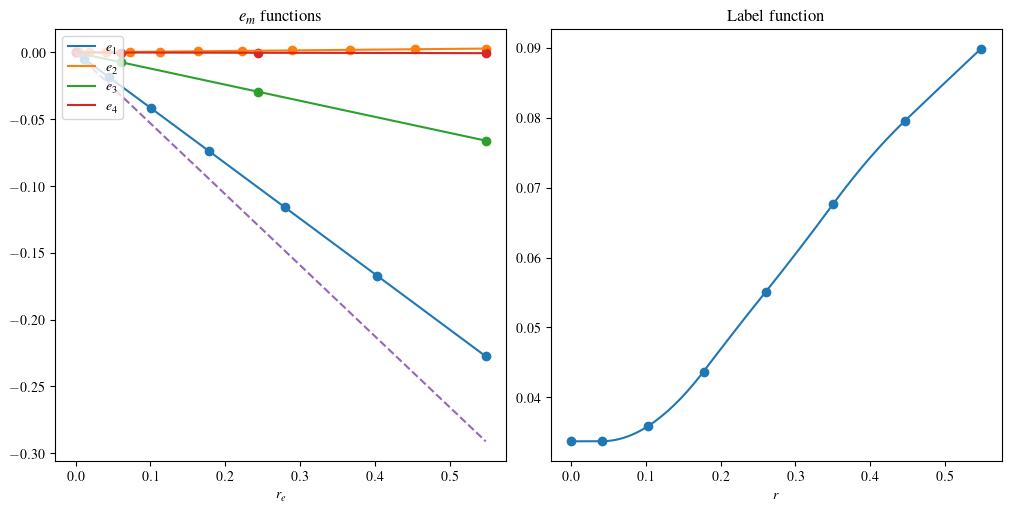

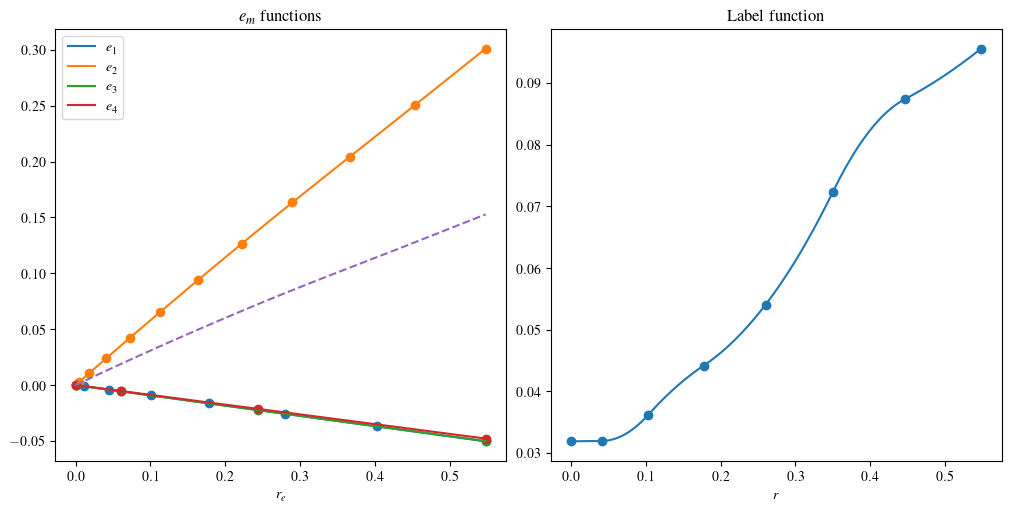

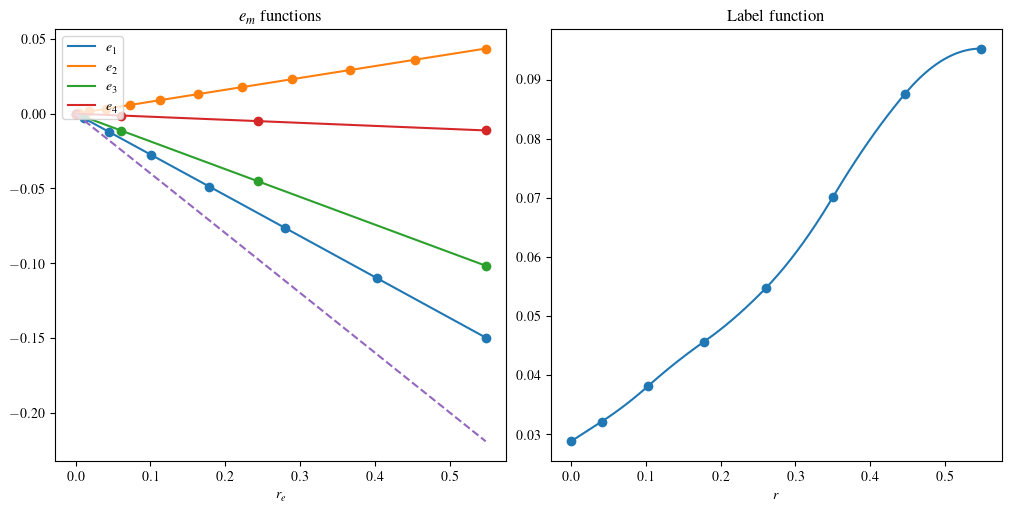

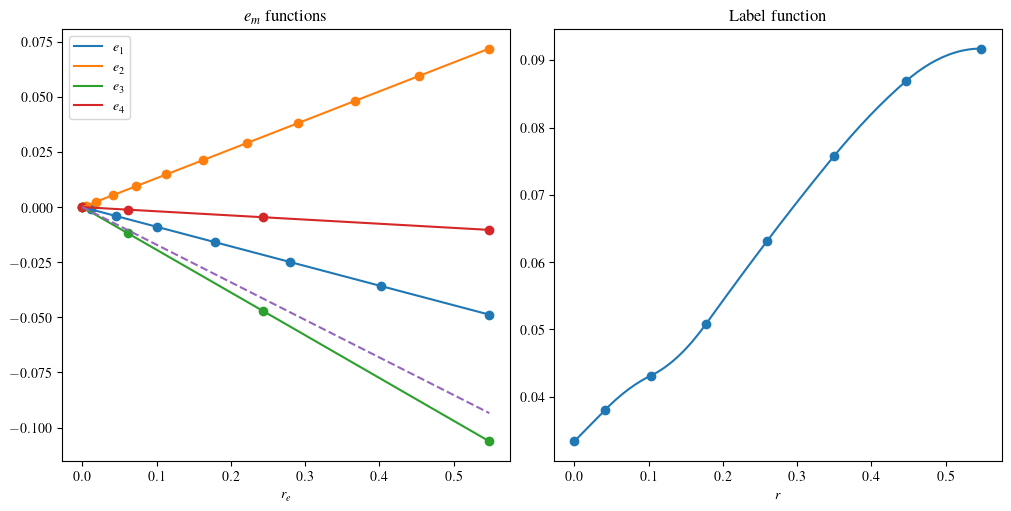

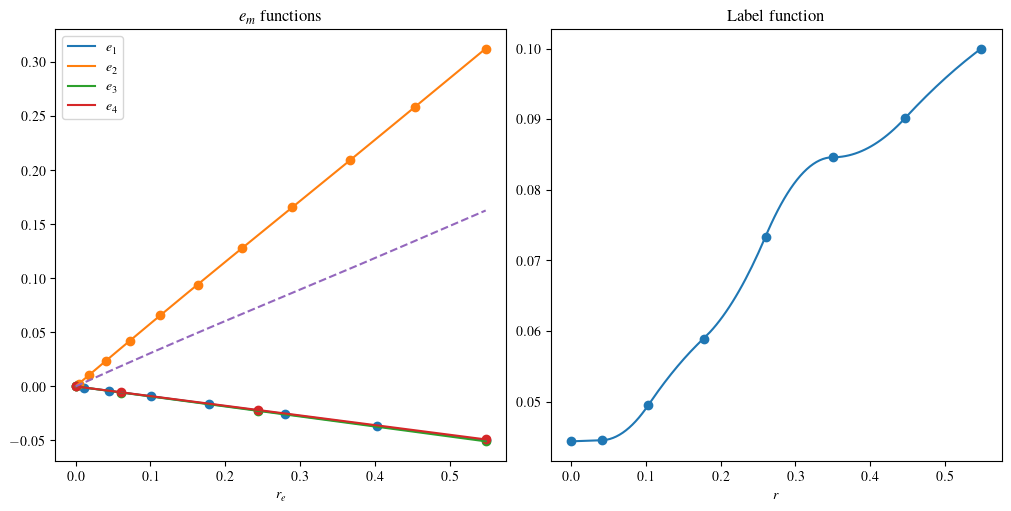

In [25]:
for indx, i in enumerate(reses):
    _ = oti.plot.plot_spline_functions(model, i.params)

# Create bootstrap samples to assess uncertainty in measurements

In [26]:
from astropy.stats import bootstrap

# we will bootstrap 10 times for now to speed things up
def create_boot_samp(deltaR, vR,xfe,xfe_err,bins,n=50):
    deltaR_boot = []
    vRs_boot = []
    xfe_boot = []
    xfe_err_boot = []
    
    #loop over bins
    for indx, i in enumerate(bins):
        # create the bootstrap samples  
        # in order to sample the distribution using bootstrap with resampling and to get the correct
        # information for every star picked, we need to sample an id array, and use that to pick out the sampled stars
        # otherwise you get incorrect fehs for every abundance
        random_ids = np.arange(len(deltaR[i]))
        
        samples_indices = bootstrap(random_ids, n).astype(int)
        # within a bin, loop over all the 
        deltaR_bo = []
        vRs_bo = []
        xfe_bo = []
        xfe_err_bo = []
        for jndx, j in enumerate(samples_indices):
            # find the stars with the correct id
            deltaR_b = deltaR[i][j]
            deltaR_bo.append(deltaR_b)
            vRs_b = vR[i][j]
            vRs_bo.append(vRs_b)
            xfe_b = xfe[i][j]
            xfe_bo.append(xfe_b)
            xfe_err_b = xfe_err[i][j]
            xfe_err_bo.append(xfe_err_b)
            
        deltaR_boot.append(deltaR_bo)
        vRs_boot.append(vRs_bo)
        xfe_boot.append(xfe_bo)
        xfe_err_boot.append(xfe_err_bo)
            
    return deltaR_boot, vRs_boot, xfe_boot,xfe_err_boot

In [27]:
Rg_w = 2.
Rgal_cs = np.linspace(5,12,15)
# deltaR = (Rgal_cs[1]-Rgal_cs[0])

bins = []
for Rg_c in Rgal_cs:
    Rg_l, Rg_r = (Rg_c, Rg_c + Rg_w/2)
    Rg_mask = (Rg > Rg_l) & (Rg <= Rg_r) & wmask 
    bins.append(Rg_mask)

In [28]:
deltaR_boot, vRs_boot, xfe_boot, xfe_err_boot = create_boot_samp(deltaR, vR,data['MG_FE'],data['MG_FE_ERR'],bins,n=10)


In [30]:
max_deltaR = 3 * u.kpc
max_vR = 100 * u.km / u.s
bins_deltaRvR = {
    "pos": np.linspace(-1, 1, 81) * max_deltaR,
    "vel": np.linspace(-1, 1, 81) * max_vR,
}


In [31]:
bdatas_boot = []
reses_boot = []

for indx, i in tqdm.tqdm_notebook(enumerate(deltaR_boot)):
    for jndx, j in enumerate(i):
        
        x_param = j*u.kpc
        y_param = vRs_boot[indx][jndx]*u.km/u.s
        label = xfe_boot[indx][jndx]
        label_err = xfe_err_boot[indx][jndx]

        bdata = oti.data.get_binned_label(
        
        pos=x_param.astype(np.float32),
        vel=y_param.astype(np.float32),
        label=label.astype(np.float32),
        label_err=label_err.astype(np.float32),
        bins=bins_deltaRvR,
        units=galactic,
        s_N_thresh=2,
        )

        bdata_clean = dict(
            pos=bdata["pos"],
            vel=bdata["vel"],
            label=bdata["label"],
            label_err=bdata["label_err"],
        )
        bdata_mask = (
            np.isfinite(bdata["label"])
            & np.isfinite(bdata["label_err"])
            & (bdata["label_err"] > 0)
        )
        bdata_clean = {k: v[bdata_mask] for k, v in bdata_clean.items()}

        res = model.optimize(init_params, objective="gaussian", bounds=bounds, **bdata_clean)

        bdatas_boot.append(bdata_clean)
        reses_boot.append(res)

0it [00:00, ?it/s]

In [37]:
# save the values
import pickle

with open('/Users/dhortad/Projects/TorusImaging-radial/sav/reses-boot.pickle', 'wb') as handle:
    pickle.dump(reses_boot, handle, protocol=pickle.HIGHEST_PROTOCOL)

np.save('/Users/dhortad/Projects/TorusImaging-radial/sav/bdatas-boot',np.array(bdatas_boot))

In [38]:
# delta v_c = vc * pos0 / Rg_bin

# vcirc

pos0s = []
kappas = []

for i in reses_boot:
    pos0s.append(i.params['pos0'])
    kappas.append(jnp.exp(i.params['ln_Omega0']))


In [39]:
pos0s = np.array(pos0s).reshape(15,10)
kappas = np.array(kappas).reshape(15,10)
kappas.shape

(15, 10)

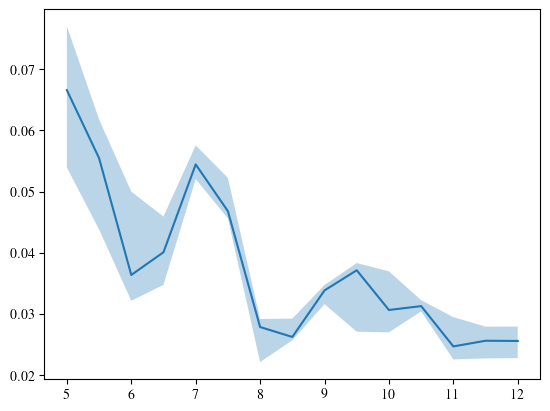

In [40]:
kappas_per = np.nanpercentile(kappas, [16,50,84], axis=1)

plt.plot(Rgal_cs, kappas_per[1,:])
plt.fill_between(Rgal_cs, kappas_per[0,:], kappas_per[2,:],alpha=0.3)


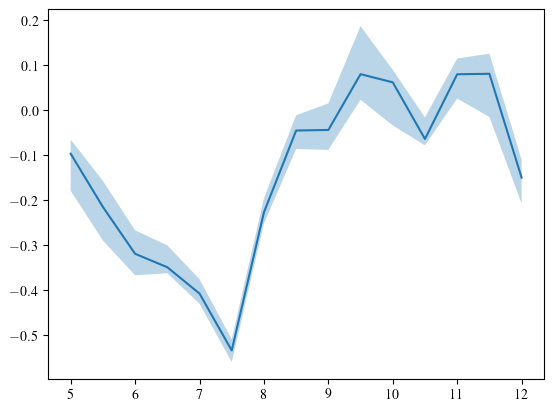

In [41]:
pos0s_per = np.nanpercentile(pos0s, [16,50,84], axis=1)

plt.plot(Rgal_cs, pos0s_per[1,:])
plt.fill_between(Rgal_cs, pos0s_per[0,:], pos0s_per[2,:],alpha=0.3)


In [42]:
vcirc = 229.-1.7*(bin_centers-9.05)

delta_vc = -vcirc * jnp.array(pos0s_per) / bin_centers

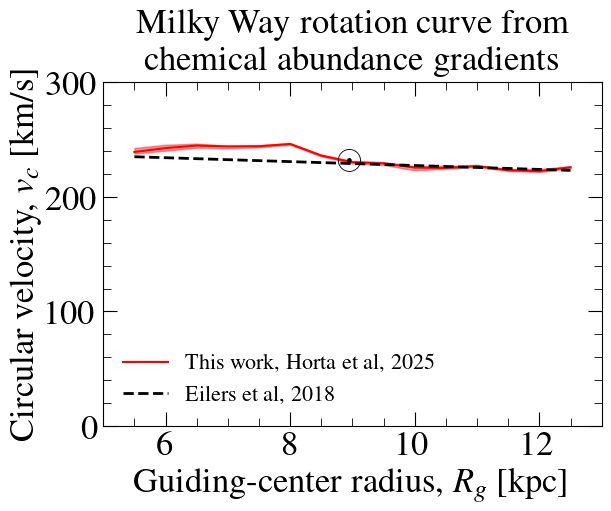

In [60]:
plt.figure(figsize=(6,5), constrained_layout=True)

plt.title('Milky Way rotation curve from \n chemical abundance gradients', fontsize=25, pad=10)
plt.plot(bin_centers, vcirc+delta_vc[1,:], color='r', label='This work, Horta et al, 2025')
plt.fill_between(bin_centers, vcirc+delta_vc[0,:], vcirc+delta_vc[2,:], alpha=0.4, color='r')
plt.plot(bin_centers, vcirc, ls='--', color='k', lw=2, label='Eilers et al, 2018')
plt.text(8.75,225.,'$\odot$',fontsize=25,color='k',fontweight='bold')

plt.legend(loc='lower left', fontsize=16, frameon=False)
plt.ylim(0,300)
plt.xlim(5,13)
plt.xlabel('Guiding-center radius, $R_g$ [kpc]', fontsize=25)
plt.ylabel('Circular velocity, $v_{c}$ [km/s]', fontsize=25)
plt.tick_params(labelsize=25,direction='in',top=True,right=True,length=6)
plt.tick_params(which='major',labelsize=25,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()


plt.savefig('/Users/dhortad/Projects/Torusimaging-radial/plots/vcs.pdf',dpi=250, bbox_inches = 'tight')


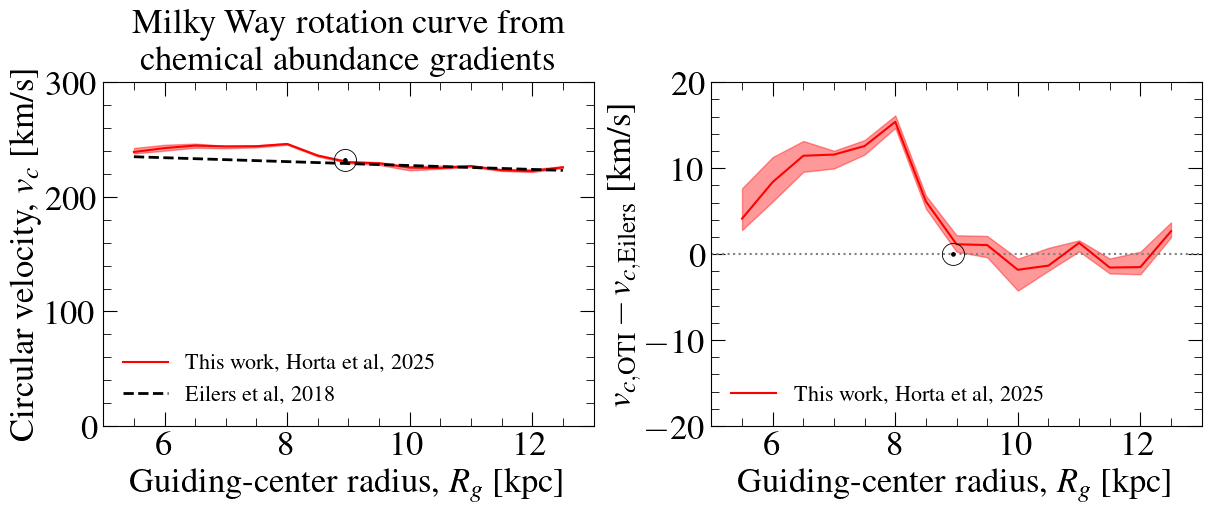

In [63]:
plt.figure(figsize=(12,5), constrained_layout=True)

plt.subplot(1,2,1)
plt.title('Milky Way rotation curve from \n chemical abundance gradients', fontsize=25, pad=10)
plt.plot(bin_centers, vcirc+delta_vc[1,:], color='r', label='This work, Horta et al, 2025')
plt.fill_between(bin_centers, vcirc+delta_vc[0,:], vcirc+delta_vc[2,:], alpha=0.4, color='r')
plt.plot(bin_centers, vcirc, ls='--', color='k', lw=2, label='Eilers et al, 2018')
plt.legend(loc='lower left', fontsize=16, frameon=False)
plt.text(8.75,225.,'$\odot$',fontsize=25,color='k',fontweight='bold')
plt.ylim(0,300)
plt.xlim(5,13)
plt.xlabel('Guiding-center radius, $R_g$ [kpc]', fontsize=25)
plt.ylabel('Circular velocity, $v_{c}$ [km/s]', fontsize=25)
plt.tick_params(labelsize=25,direction='in',top=True,right=True,length=6)
plt.tick_params(which='major',labelsize=25,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(1,2,2)
plt.hlines(0,5,13, ls='dotted',color='gray')
plt.plot(bin_centers, vcirc+delta_vc[1,:]-vcirc, color='r', label='This work, Horta et al, 2025')
plt.fill_between(bin_centers, vcirc+delta_vc[0,:]-vcirc, vcirc+delta_vc[2,:]-vcirc, alpha=0.4, color='r')
plt.legend(loc='lower left', fontsize=16, frameon=False)
plt.text(8.75,-1.,'$\odot$',fontsize=25,color='k',fontweight='bold')
plt.ylim(-20,20)
plt.xlim(5,13)
plt.xlabel('Guiding-center radius, $R_g$ [kpc]', fontsize=25)
plt.ylabel('$v_{c,\mathrm{OTI}} - v_{c,\mathrm{Eilers}}$ [km/s]', fontsize=25)
plt.tick_params(labelsize=25,direction='in',top=True,right=True,length=6)
plt.tick_params(which='major',labelsize=25,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

# plt.savefig('/Users/dhortad/Projects/Torusimaging-radial/plots/vcs.pdf',dpi=250, bbox_inches = 'tight')


In [64]:
kappas_per = jnp.array(kappas_per) * 1./u.Myr
kapp = kappas_per.to(u.km/(u.s * u.kpc))

Text(0.5, 0, '$R_g$')

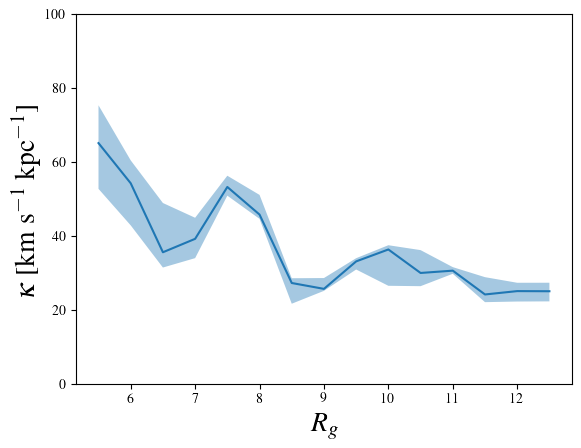

In [65]:
plt.fill_between(bin_centers, kapp[0,:].value, kapp[2,:].value,alpha=0.4)
plt.plot(bin_centers, kapp[1,:].value)
plt.ylim(0,100)
plt.ylabel('$\kappa$ [km s$^{-1}$ kpc$^{-1}$]', fontsize=20)
plt.xlabel('$R_g$', fontsize=20)

In [68]:
# dens = np.zeros((len(bin_centers)))
# omegas = np.zeros((len(bin_centers)))
# vc = -vcirc+delta_vc

# for indx, i in enumerate(reses[:-1]):
#     kappa = np.exp(i.params['ln_Omega0'])*1./u.Myr
#     vcircs = vc[indx]*u.km/u.s
#     vcircs = vcircs.to(u.kpc/u.Myr)
#     Rg = bin_centers[indx]*u.kpc
#     omega = vcircs/Rg
#     omegas[indx] = omega.value
#     G_ = G.to(u.pc**3/(u.solMass*u.Myr**2))
#     scale = 1./(4.*np.pi*G_)
#     num = kappa**2 - 2.*(omega**2)
#     res = num * scale
#     dens[indx] = res.value

dens = np.zeros((len(bin_centers),3))

omegas = np.zeros((len(bin_centers),3))

vc = (vcirc+delta_vc)*u.km/u.s
vc = vc.to(u.kpc/u.Myr)

for indx, i in enumerate(kappas_per.T):
    k = i
    vcircs = vc.to(u.kpc/u.Myr)
    Rg = bin_centers[indx]*u.kpc
    
    oms = vc[:,indx]/Rg

    omega = oms.value
    omegas[indx] = omega
    G_ = G.to(u.pc**3/(u.solMass*u.Myr**2))
    scale = 1./(4.*np.pi*G_)
    num = k.value**2 - 2.*(omega**2)
    
    res = num * scale
    dens[indx] = res.value


In [69]:
omegas = jnp.array(omegas) * 1./u.Myr
omegas = omegas.to(u.km/(u.s * u.kpc))
omegas.shape

(15, 3)

In [70]:
kappas_per = kappas_per.to(u.km/(u.s * u.kpc))

Text(0.5, 0, '$R_g$')

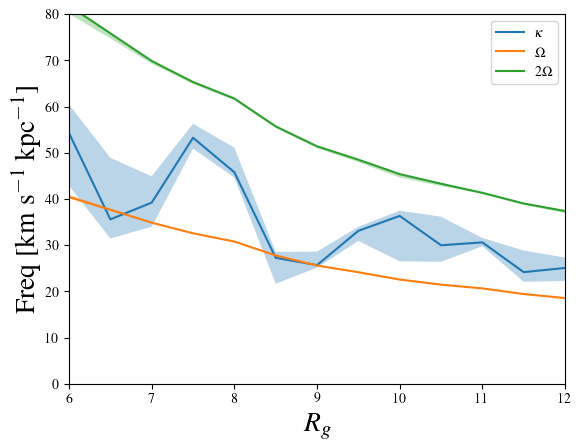

In [71]:
plt.fill_between(bin_centers, kappas_per[0,:].value, kappas_per[2,:].value,alpha=0.3)
plt.plot(bin_centers, kappas_per[1,:].value, label='$\kappa$')
plt.fill_between(bin_centers, omegas[:,0].value, omegas[:,2].value,alpha=0.3)
plt.plot(bin_centers, omegas[:,1].value, label='$\Omega$')

plt.fill_between(bin_centers, 2*omegas[:,0].value, 2*omegas[:,2].value,alpha=0.3)
plt.plot(bin_centers, 2*omegas[:,0].value, label='2$\Omega$')
plt.legend()
plt.ylim(0,80)
plt.xlim(6,12)
# plt.hlines(30,5,14)
plt.ylabel('Freq [km s$^{-1}$ kpc$^{-1}$]', fontsize=20)
plt.xlabel('$R_g$', fontsize=20)

In [72]:
# plt.plot(bin_centers, kapp/omegas)
# plt.plot(bin_centers, )
# plt.ylim(0,0.45)

In [73]:
r  = np.array([6.0, 6.500196718276285, 7.000879446411627, 7.500613298155477, 8.000624869818788, 8.500451294869125, 8.998403110463098, 9.500844731421694, 10.004790668610706, 10.500844731421694, 11.001874609456364, 11.50234904765211, 11.998588257076072])
y = jnp.array([0.308, 0.27544970546447217, 0.25826240002554235, 0.23217956290608388, 0.21191408183138838, 0.17302365862613944, 0.14228396736961416, 0.12522285723407992, 0.09626474673137403, 0.058153765105921074, 0.03888299995210809, 0.011780702734630721, 0.001972110917769554])

In [74]:
bin_centers

array([ 5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5,
       11. , 11.5, 12. , 12.5])

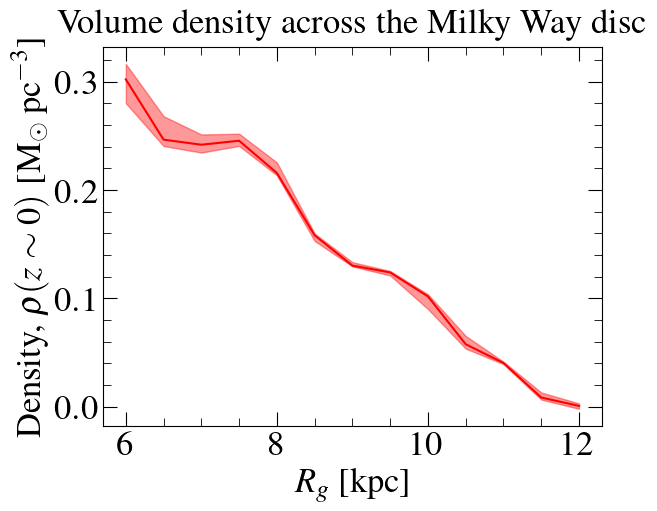

In [75]:
plt.figure(figsize=(6,5), constrained_layout=True)
plt.title('Volume density across the Milky Way disc', fontsize=25, pad=10)

plt.fill_between(bin_centers[1:-1], dens[1:-1,0]+y, dens[1:-1,2]+y, alpha=0.4, color='r')
plt.plot(bin_centers[1:-1], dens[1:-1,1]+y, color='r')
plt.ylabel(r'Density, $\rho(z\sim0)$ [M$_{\odot}$ pc$^{-3}$]', fontsize=25)
plt.xlabel('$R_g$ [kpc]', fontsize=25)
# plt.yscale('log')
# plt.ylim(0.001,0.6)
plt.tick_params(labelsize=25,direction='in',top=True,right=True,length=6)
plt.tick_params(which='major',labelsize=25,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

# plt.savefig('/Users/dhortad/Projects/Torusimaging-radial/plots/dens.pdf',dpi=250, bbox_inches = 'tight')


In [188]:
len(dens)

14

Bin the data using [Fe/H]

Initialise the model

In [7]:
R_param = Rgal*u.kpc
vphi_param = vt*u.km/u.s
vcirc_param = vcirc*u.km/u.s
vR_param = vR * u.km/u.s
label = data['MG_FE']
label_err = data['MG_FE_ERR']

bdata = model_radial.get_binned_label(
    R=R_param[wmask].astype(np.float32),
    vphi=vphi_param[wmask].astype(np.float32),
    vel=vR_param[wmask].astype(np.float32),
    vcirc=vcirc_param[wmask].astype(np.float32),
    label=label[wmask].astype(np.float32),
    label_err=label_err[wmask].astype(np.float32),
    bins=bins,
    units=galactic,
    s_N_thresh=2,
)

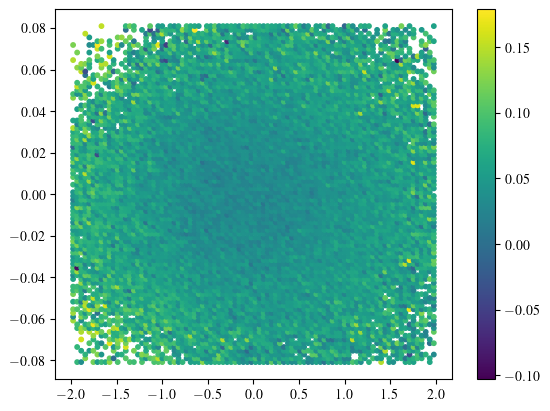

In [8]:
plt.scatter(bdata['pos'],bdata['vel'], c=bdata['label'],s=10)
plt.colorbar()

In [23]:
bdata['pos'].shape

(90, 90)

In [24]:
model, bounds, init_params = model_radial.TorusImaging1DSpline.auto_init(
    bdata,
    label_knots=8,
    e_knots={2: 8, 4: 4},
    label_l2_sigma=1.0,
    label_smooth_sigma=0.5,
    e_l2_sigmas={2: 1.0, 4: 1.0},
    e_smooth_sigmas={2: 0.5, 4: 0.5},
    dacc_strength=1e2,
    e_knots_spacing_power=0.5,
)

# model, bounds, init_params = model_radial.TorusImaging1DSpline.auto_init(
#     bdata,
#     label_knots=4,
#     e_knots={1: 8, 3: 4},
#     label_l2_sigma=1.0,
#     label_smooth_sigma=0.5,
#     e_l2_sigmas={1: 1.0, 3: 1.0},
#     e_smooth_sigmas={1: 0.5, 3: 0.5},
#     dacc_strength=1e2,
#     e_knots_spacing_power=0.5,
# )


In [25]:
init_params

{'vcirc0': 0.0,
 'vel0': 0.0,
 'ln_Omega0': np.float64(-3.196417741080569),
 'e_params': {2: {'vals': Array([-16., -16., -16., -16., -16., -16., -16.], dtype=float64, weak_type=True)},
  4: {'vals': Array([-16., -16., -16.], dtype=float64, weak_type=True)}},
 'label_params': {'label_vals': array([0.0322193 , 0.11803584, 0.11803584, 0.11803584, 0.11803584,
         0.11803584, 0.11803584, 0.11803584])}}

In [26]:
# init_params["e_params"][1]["vals"] = np.full_like(
#     init_params["e_params"][1]["vals"], np.log(0.1 / model._label_knots.max())
# )
init_params["e_params"][2]["vals"] = np.full_like(
    init_params["e_params"][2]["vals"], np.log(0.1 / model._label_knots.max())
)
# init_params["e_params"][3]["vals"] = np.full_like(
#     init_params["e_params"][3]["vals"], np.log(0.1 / model._label_knots.max())
# )
init_params["e_params"][4]["vals"] = np.full_like(
    init_params["e_params"][4]["vals"], np.log(0.01 / model._label_knots.max())
)

Model the data for all stars within $|z|<0.2$ using $R$, using all stars first

In [27]:
mask_solar = (Rg>8.)&(Rg<10.)

R_param = Rgal*u.kpc
vphi_param = vt*u.km/u.s
vcirc_param = vcirc*u.km/u.s
vR_param = vR * u.km/u.s
label = data['MG_FE']
label_err = data['MG_FE_ERR']

bdata = model_radial.get_binned_label(
    R=R_param[wmask&mask_solar].astype(np.float32),
    vphi=vphi_param[wmask&mask_solar].astype(np.float32),
    vel=vR_param[wmask&mask_solar].astype(np.float32),
    vcirc=vcirc_param[wmask&mask_solar].astype(np.float32),
    label=label[wmask&mask_solar].astype(np.float32),
    label_err=label_err[wmask&mask_solar].astype(np.float32),
    bins=bins,
    units=galactic,
    s_N_thresh=2,
)

bdata_clean = dict(
    pos=bdata["pos"],
    vel=bdata["vel"],
    label=bdata["label"],
    label_err=bdata["label_err"],
)
bdata_mask = (
    np.isfinite(bdata["label"])
    & np.isfinite(bdata["label_err"])
    & (bdata["label_err"] > 0)
)
bdata_clean = {k: v[bdata_mask] for k, v in bdata_clean.items()}

In [53]:
init_params

{'vcirc0': 0.0,
 'vel0': 0.0,
 'ln_Omega0': np.float64(-3.196417741080569),
 'e_params': {2: {'vals': array([-1.3863501, -1.3863501, -1.3863501, -1.3863501, -1.3863501,
          -1.3863501, -1.3863501])},
  4: {'vals': array([-3.6889352, -3.6889352, -3.6889352])}},
 'label_params': {'label_vals': array([0.0322193 , 0.11803584, 0.11803584, 0.11803584, 0.11803584,
         0.11803584, 0.11803584, 0.11803584])}}

In [54]:
res = model.optimize(init_params, objective="gaussian", bounds=bounds, **bdata_clean)
res.state.success, res.state.iter_num

TypeError: TorusImaging1D.objective_gaussian() got an unexpected keyword argument 'pos'

In [25]:
rads = Rgal[wmask&mask_solar]
vphis = vt[wmask&mask_solar]
rg0 = np.zeros((len(rads)))
vcirc0 = np.zeros((len(rads)))
      
for indx, i in enumerate(rads):
    rg0[indx] = i - res.params['pos0']
    vcirc0[indx] = (i*vphis[indx])/(i - res.params['pos0'])

print(np.nanmean(rg0), np.nanmean(vcirc0))

9.00879792288051 228.70704089233186


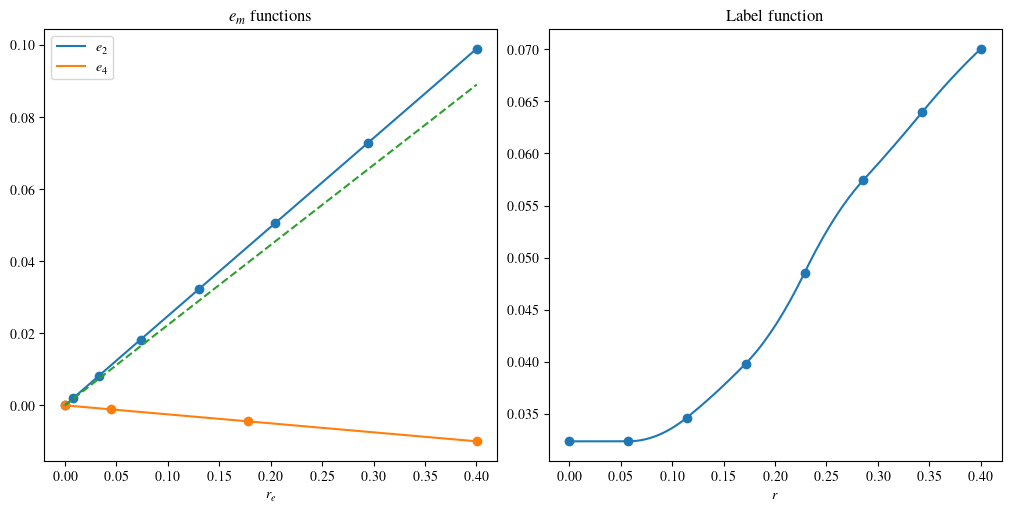

In [26]:
_ = oti.plot.plot_spline_functions(model, res.params)

Text(0, 0.5, '$v_R$ [$\\mathrm{km\\,s^{-1}}$]')

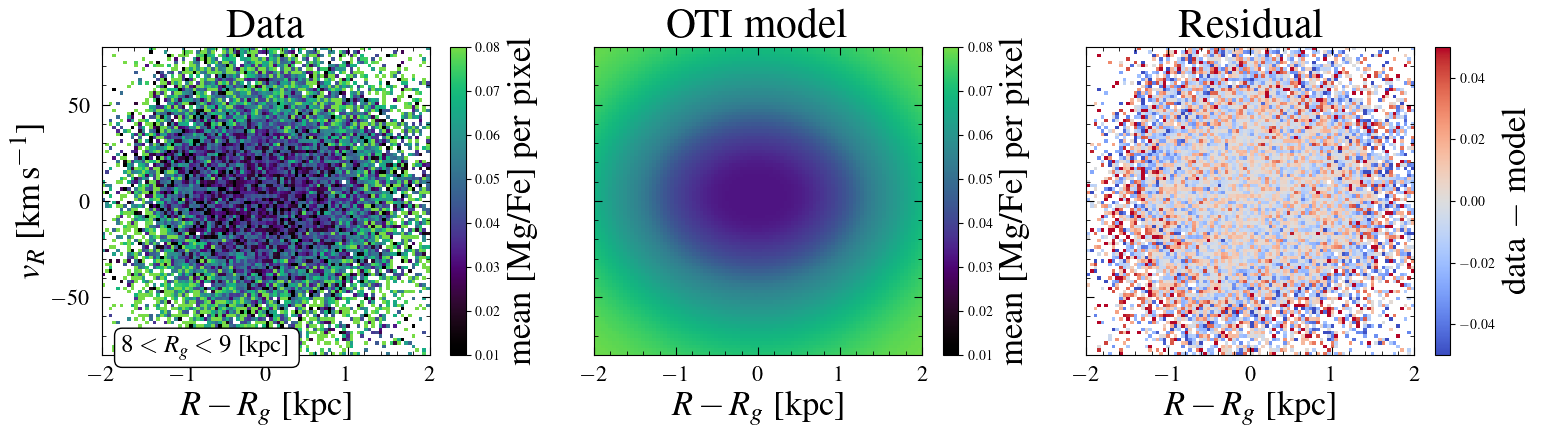

In [27]:
# visualise the data

fig, axes = plt.subplots(1, 3, figsize=(18, 4), sharex=True, sharey=True)
# fig.suptitle(r'Low-$\alpha$ stars between $|z|<0.2$ kpc with $v_z<20$ km/s', fontsize=35, y=1.2)

ax = axes[0]
ax.set_title('Data', fontsize=30)
cs = ax.pcolormesh(
    bdata["pos"].to_value(u.kpc),
    bdata["vel"].to_value(u.km / u.s),
    bdata["label"],
    vmin=0.01,
    vmax=0.08,
    cmap=cm.lavender,
)
cb = fig.colorbar(cs, ax=ax)
cb.set_label("mean [Mg/Fe] per pixel", fontsize=25)
props = dict(boxstyle='round', facecolor='white', alpha=1)
ax.text(-1.75,-70, r'$8< R_{g} <9$ [kpc]', fontsize=18,
    verticalalignment='top', bbox=props)
ax.scatter(8.275, 0, marker='*', color='gold', s=100, edgecolors='k')
ax.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=6, pad=8)
ax.tick_params(which='minor', length=3, direction='in',top=True,right=True, pad=8)
ax.minorticks_on()
ax.set_ylim(-80,80)
ax.set_xlim(-2.,2.)

ax = axes[1]
ax.set_title('OTI model', fontsize=30)
model_H = model._get_label(pos=bdata["pos"], vel=bdata["vel"], params=res.params)
cs = ax.pcolormesh(
    bdata["pos"].to_value(u.kpc),
    bdata["vel"].to_value(u.km / u.s),
    model_H,
    vmin=0.01,
    vmax=0.08,
    cmap=cm.lavender
)
ax.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=6, pad=8)
ax.tick_params(which='minor', length=3, direction='in',top=True,right=True, pad=8)
ax.minorticks_on()
cb = fig.colorbar(cs, ax=ax)
cb.set_label("mean [Mg/Fe] per pixel", fontsize=25)
ax.scatter(8.275, 0, marker='*', color='gold', s=100, edgecolors='k')
ax.set_ylim(-80,80)
ax.set_xlim(-2.,2.)

ax = axes[2]
ax.set_title('Residual', fontsize=30)
cs = ax.pcolormesh(
    bdata["pos"].to_value(u.kpc),
    bdata["vel"].to_value(u.km / u.s),
    bdata["label"] - model_H,
    vmin=-0.05,
    vmax=0.05,
    cmap='coolwarm'
)

cb = fig.colorbar(cs, ax=ax)
cb.set_label("data $-$ model", fontsize=25)
ax.scatter(8.275, 0, marker='*', color='gold', s=100, edgecolors='k')
ax.set_ylim(-80,80)
ax.set_xlim(-2,2)
ax.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=6, pad=8)
ax.tick_params(which='minor', length=3, direction='in',top=True,right=True, pad=8)
ax.minorticks_on()

for ax in axes:
    ax.set_xlabel(f"$R-R_g$ [{u.kpc:latex_inline}]", fontsize=25)
axes[0].set_ylabel(f"$v_R$ [{u.km/u.s:latex_inline}]", fontsize=25)

# plt.savefig('/Users/dhortad/Projects/Torusimaging-radial/plots/model-data-Rg89kpc.pdf',dpi=250, bbox_inches = 'tight')


Text(0, 0.5, '$v_R$ [$\\mathrm{km\\,s^{-1}}$]')

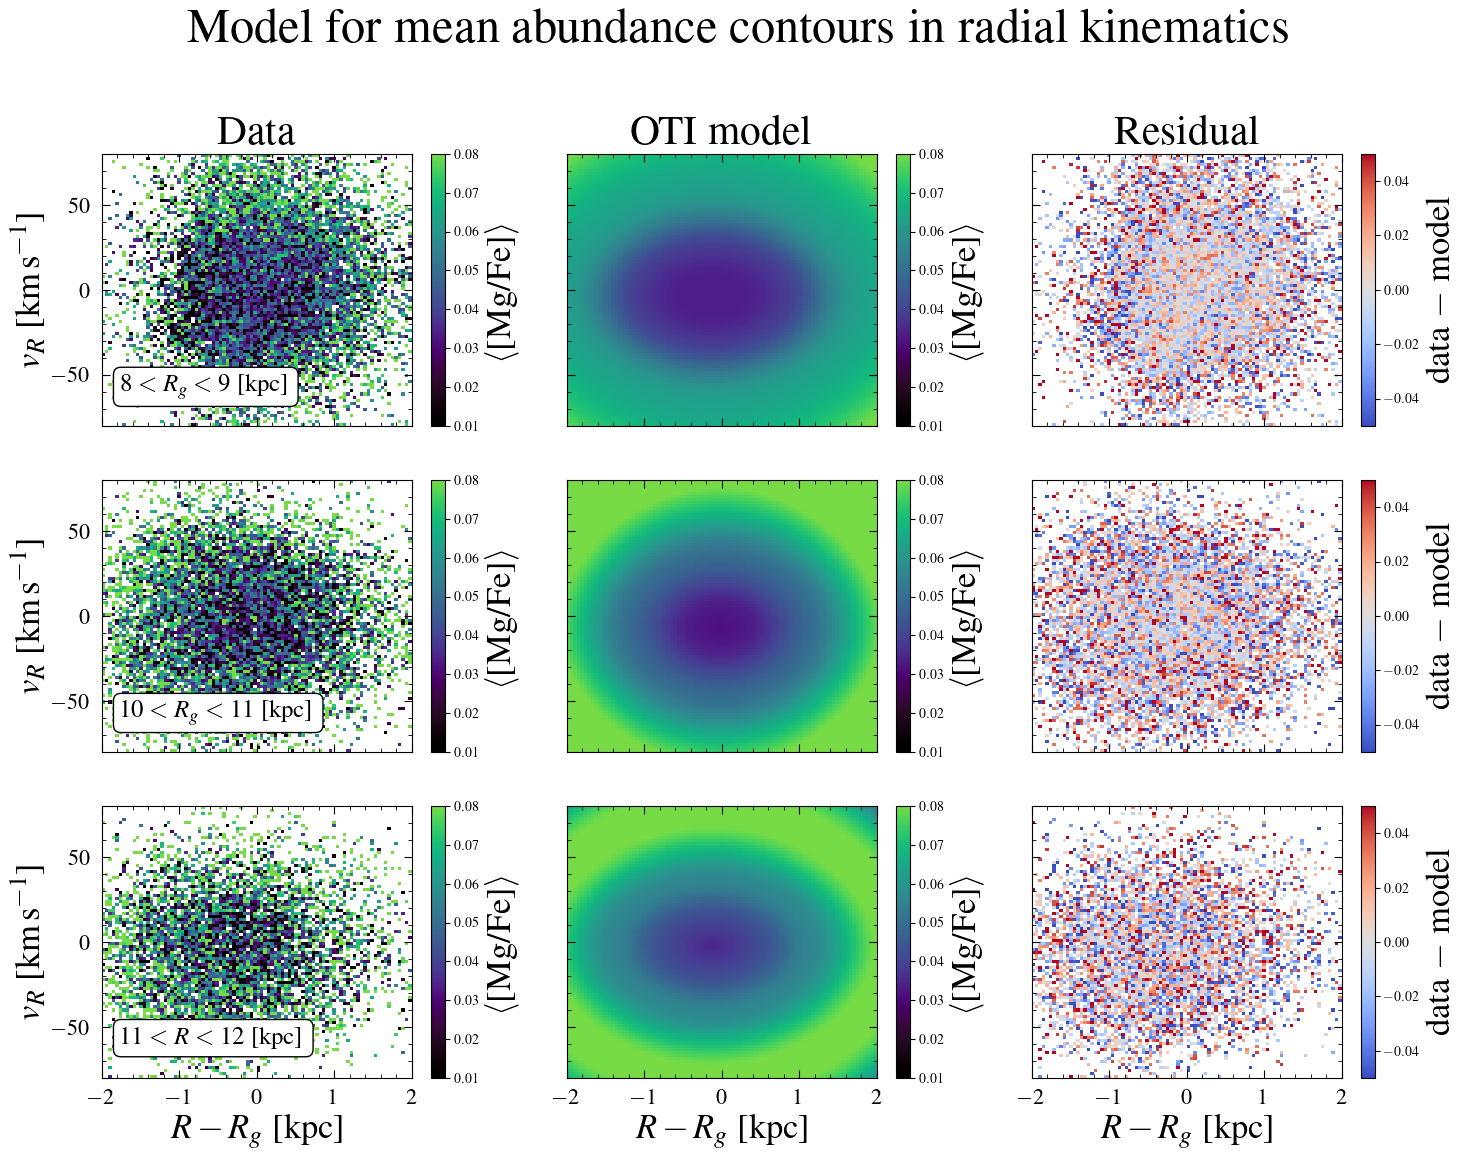

In [28]:
fig, axes = plt.subplots(3, 3, figsize=(17, 12), sharex=True, sharey=True)
fig.suptitle(r'Model for mean abundance contours in radial kinematics', fontsize=35, y=1.0)

x_param = deltaR * u.kpc
y_param = vR * u.km/u.s
label = data['MG_FE']
label_err = data['MG_FE_ERR']

mask_solar = (Rg>8.)&(Rg<9.)

bdata = oti.data.get_binned_label(
    pos=x_param[wmask&mask_solar].astype(np.float32),
    vel=y_param[wmask&mask_solar].astype(np.float32),
    label=label[wmask&mask_solar].astype(np.float32),
    label_err=label_err[wmask&mask_solar].astype(np.float32),
    bins=bins,
    units=galactic,
    s_N_thresh=2,
)

bdata_clean = dict(
    pos=bdata["pos"],
    vel=bdata["vel"],
    label=bdata["label"],
    label_err=bdata["label_err"],
)
bdata_mask = (
    np.isfinite(bdata["label"])
    & np.isfinite(bdata["label_err"])
    & (bdata["label_err"] > 0)
)
bdata_clean = {k: v[bdata_mask] for k, v in bdata_clean.items()}

res = model.optimize(init_params, objective="gaussian", bounds=bounds, **bdata_clean)
res.state.success, res.state.iter_num

ax = axes[0,0]
ax.set_title('Data', fontsize=30)
cs = ax.pcolormesh(
    bdata["pos"].to_value(u.kpc),
    bdata["vel"].to_value(u.km / u.s),
    bdata["label"],
    vmin=0.01,
    vmax=0.08,
    cmap=cm.lavender,
)
cb = fig.colorbar(cs, ax=ax)
cb.set_label(r'$\langle$[Mg/Fe]$\rangle$', fontsize=25)
props = dict(boxstyle='round', facecolor='white', alpha=1)
ax.text(-1.75,-50, r'$8< R_{g} <9$ [kpc]', fontsize=18,
    verticalalignment='top', bbox=props)
ax.scatter(8.275, 0, marker='*', color='gold', s=100, edgecolors='k')
ax.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=6, pad=8)
ax.tick_params(which='minor', length=3, direction='in',top=True,right=True, pad=8)
ax.minorticks_on()
ax.set_ylim(-80,80)
ax.set_xlim(-2,2)

ax = axes[0,1]
ax.set_title('OTI model', fontsize=30)
model_H = model._get_label(pos=bdata["pos"], vel=bdata["vel"], params=res.params)
cs = ax.pcolormesh(
    bdata["pos"].to_value(u.kpc),
    bdata["vel"].to_value(u.km / u.s),
    model_H,
    vmin=0.01,
    vmax=0.08,
    cmap=cm.lavender
)
ax.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=6, pad=8)
ax.tick_params(which='minor', length=3, direction='in',top=True,right=True, pad=8)
ax.minorticks_on()
cb = fig.colorbar(cs, ax=ax)
cb.set_label(r'$\langle$[Mg/Fe]$\rangle$', fontsize=25)
ax.scatter(8.275, 0, marker='*', color='gold', s=100, edgecolors='k')
ax.set_ylim(-80,80)
ax.set_xlim(-2,2)

ax = axes[0,2]
ax.set_title('Residual', fontsize=30)
cs = ax.pcolormesh(
    bdata["pos"].to_value(u.kpc),
    bdata["vel"].to_value(u.km / u.s),
    bdata["label"] - model_H,
    vmin=-0.05,
    vmax=0.05,
    cmap='coolwarm'
)

cb = fig.colorbar(cs, ax=ax)
cb.set_label("data $-$ model", fontsize=25)
# ax.scatter(8.275, 0, marker='*', color='gold', s=100, edgecolors='k')
ax.set_ylim(-80,80)
ax.set_xlim(-2,2)
ax.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=6, pad=8)
ax.tick_params(which='minor', length=3, direction='in',top=True,right=True, pad=8)
ax.minorticks_on()

mask_solar = (Rg>10.)&(Rg<11.)

bdata = oti.data.get_binned_label(
    pos=x_param[wmask&mask_solar].astype(np.float32),
    vel=y_param[wmask&mask_solar].astype(np.float32),
    label=label[wmask&mask_solar].astype(np.float32),
    label_err=label_err[wmask&mask_solar].astype(np.float32),
    bins=bins,
    units=galactic,
    s_N_thresh=2,
)

bdata_clean = dict(
    pos=bdata["pos"],
    vel=bdata["vel"],
    label=bdata["label"],
    label_err=bdata["label_err"],
)
bdata_mask = (
    np.isfinite(bdata["label"])
    & np.isfinite(bdata["label_err"])
    & (bdata["label_err"] > 0)
)
bdata_clean = {k: v[bdata_mask] for k, v in bdata_clean.items()}

res = model.optimize(init_params, objective="gaussian", bounds=bounds, **bdata_clean)
res.state.success, res.state.iter_num

ax = axes[1,0]
cs = ax.pcolormesh(
    bdata["pos"].to_value(u.kpc),
    bdata["vel"].to_value(u.km / u.s),
    bdata["label"],
    vmin=0.01,
    vmax=0.08,
    cmap=cm.lavender,
)
cb = fig.colorbar(cs, ax=ax)
cb.set_label(r'$\langle$[Mg/Fe]$\rangle$', fontsize=25)
props = dict(boxstyle='round', facecolor='white', alpha=1)
ax.text(-1.75,-50, r'$10< R_g <11$ [kpc]', fontsize=18,
    verticalalignment='top', bbox=props)
ax.scatter(8.275, 0, marker='*', color='gold', s=100, edgecolors='k')
ax.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=6, pad=8)
ax.tick_params(which='minor', length=3, direction='in',top=True,right=True, pad=8)
ax.minorticks_on()
ax.set_ylim(-80,80)
ax.set_xlim(-2,2)

ax = axes[1,1]
model_H = model._get_label(pos=bdata["pos"], vel=bdata["vel"], params=res.params)
cs = ax.pcolormesh(
    bdata["pos"].to_value(u.kpc),
    bdata["vel"].to_value(u.km / u.s),
    model_H,
    vmin=0.01,
    vmax=0.08,
    cmap=cm.lavender
)
ax.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=6, pad=8)
ax.tick_params(which='minor', length=3, direction='in',top=True,right=True, pad=8)
ax.minorticks_on()
cb = fig.colorbar(cs, ax=ax)
cb.set_label(r'$\langle$[Mg/Fe]$\rangle$', fontsize=25)
ax.scatter(8.275, 0, marker='*', color='gold', s=100, edgecolors='k')
ax.set_ylim(-80,80)
ax.set_xlim(-2,2)

ax = axes[1,2]
cs = ax.pcolormesh(
    bdata["pos"].to_value(u.kpc),
    bdata["vel"].to_value(u.km / u.s),
    bdata["label"] - model_H,
    vmin=-0.05,
    vmax=0.05,
    cmap='coolwarm'
)

cb = fig.colorbar(cs, ax=ax)
cb.set_label("data $-$ model", fontsize=25)
ax.scatter(8.275, 0, marker='*', color='gold', s=100, edgecolors='k')
ax.set_ylim(-80,80)
ax.set_xlim(-2,2)
ax.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=6, pad=8)
ax.tick_params(which='minor', length=3, direction='in',top=True,right=True, pad=8)
ax.minorticks_on()

mask_solar = (Rg>11.)&(Rg<12.)

bdata = oti.data.get_binned_label(
    pos=x_param[wmask&mask_solar].astype(np.float32),
    vel=y_param[wmask&mask_solar].astype(np.float32),
    label=label[wmask&mask_solar].astype(np.float32),
    label_err=label_err[wmask&mask_solar].astype(np.float32),
    bins=bins,
    units=galactic,
    s_N_thresh=2,
)

bdata_clean = dict(
    pos=bdata["pos"],
    vel=bdata["vel"],
    label=bdata["label"],
    label_err=bdata["label_err"],
)
bdata_mask = (
    np.isfinite(bdata["label"])
    & np.isfinite(bdata["label_err"])
    & (bdata["label_err"] > 0)
)
bdata_clean = {k: v[bdata_mask] for k, v in bdata_clean.items()}

res = model.optimize(init_params, objective="gaussian", bounds=bounds, **bdata_clean)
res.state.success, res.state.iter_num

ax = axes[2,0]
cs = ax.pcolormesh(
    bdata["pos"].to_value(u.kpc),
    bdata["vel"].to_value(u.km / u.s),
    bdata["label"],
    vmin=0.01,
    vmax=0.08,
    cmap=cm.lavender,
)
cb = fig.colorbar(cs, ax=ax)
cb.set_label(r'$\langle$[Mg/Fe]$\rangle$', fontsize=25)
props = dict(boxstyle='round', facecolor='white', alpha=1)
ax.text(-1.75,-50, r'$11< R <12$ [kpc]', fontsize=18,
    verticalalignment='top', bbox=props)
ax.scatter(8.275, 0, marker='*', color='gold', s=100, edgecolors='k')
ax.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=6, pad=8)
ax.tick_params(which='minor', length=3, direction='in',top=True,right=True, pad=8)
ax.minorticks_on()
ax.set_ylim(-80,80)
ax.set_xlim(-2,2)

ax = axes[2,1]
model_H = model._get_label(pos=bdata["pos"], vel=bdata["vel"], params=res.params)
cs = ax.pcolormesh(
    bdata["pos"].to_value(u.kpc),
    bdata["vel"].to_value(u.km / u.s),
    model_H,
    vmin=0.01,
    vmax=0.08,
    cmap=cm.lavender
)
ax.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=6, pad=8)
ax.tick_params(which='minor', length=3, direction='in',top=True,right=True, pad=8)
ax.minorticks_on()
cb = fig.colorbar(cs, ax=ax)
cb.set_label(r'$\langle$[Mg/Fe]$\rangle$', fontsize=25)
ax.scatter(8.275, 0, marker='*', color='gold', s=100, edgecolors='k')
ax.set_ylim(-80,80)
ax.set_xlim(-2,2)

ax = axes[2,2]
cs = ax.pcolormesh(
    bdata["pos"].to_value(u.kpc),
    bdata["vel"].to_value(u.km / u.s),
    bdata["label"] - model_H,
    vmin=-0.05,
    vmax=0.05,
    cmap='coolwarm'
)

cb = fig.colorbar(cs, ax=ax)
cb.set_label("data $-$ model", fontsize=25)
ax.scatter(8.275, 0, marker='*', color='gold', s=100, edgecolors='k')
ax.set_ylim(-80,80)
ax.set_xlim(-2,2)
ax.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=6, pad=8)
ax.tick_params(which='minor', length=3, direction='in',top=True,right=True, pad=8)
ax.minorticks_on()


for ax in axes[2]:
    ax.set_xlabel(f"$R-R_g$ [{u.kpc:latex_inline}]", fontsize=25)
axes[0,0].set_ylabel(f"$v_R$ [{u.km/u.s:latex_inline}]", fontsize=25)
axes[1,0].set_ylabel(f"$v_R$ [{u.km/u.s:latex_inline}]", fontsize=25)
axes[2,0].set_ylabel(f"$v_R$ [{u.km/u.s:latex_inline}]", fontsize=25)

# plt.savefig('/Users/dhortad/Projects/Torusimaging-radial/plots/model-data-residuals-Rg.pdf',dpi=250, bbox_inches = 'tight')


# Model as a function of $R_g$

In [29]:
x_param = deltaR * u.kpc
y_param = vR * u.km/u.s
label = data['MG_FE']
label_err = data['MG_FE_ERR']

nbins=91
bins = {
    "pos": np.linspace(-2., 2., nbins)*u.kpc,
    "vel": np.linspace(-80, 80, nbins)*u.km/u.s,
}

In [30]:
def get_bins_plot(x, y, l, l_err, mask, nbins=64):

    bdata = oti.data.get_binned_label(
        pos=x[wmask&mask].astype(np.float32),
        vel=y[wmask&mask].astype(np.float32),
        label=l[wmask&mask].astype(np.float32),
        label_err=l_err[wmask&mask].astype(np.float32),
        bins=bins,
        units=galactic,
        s_N_thresh=2,
    )
    
    bdata_clean = dict(
        pos=bdata["pos"],
        vel=bdata["vel"],
        label=bdata["label"],
        label_err=bdata["label_err"],
    )
    bdata_mask = (
        np.isfinite(bdata["label"])
        & np.isfinite(bdata["label_err"])
        & (bdata["label_err"] > 0)
    )
    bdata_clean = {k: v[bdata_mask] for k, v in bdata_clean.items()}
    
    res = model.optimize(init_params, objective="gaussian", bounds=bounds, **bdata_clean)
    res.state.success, res.state.iter_num

    fig, axes = plt.subplots(1, 3, figsize=(18, 4), sharex=True, sharey=True)
    # fig.suptitle(r'Low-$\alpha$ stars between $|z|<0.2$ kpc with $v_z<20$ km/s', fontsize=35, y=1.2)
    
    ax = axes[0]
    ax.set_title('Data', fontsize=30)
    cs = ax.pcolormesh(
        bdata["pos"].to_value(u.kpc),
        bdata["vel"].to_value(u.km / u.s),
        bdata["label"],
        vmin=0.01,
        vmax=0.08,
        cmap=cm.lavender,
    )
    cb = fig.colorbar(cs, ax=ax)
    cb.set_label("mean [Mg/Fe] per pixel", fontsize=25)
    ax.scatter(8.275, 0, marker='*', color='gold', s=100, edgecolors='k')
    ax.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=6, pad=8)
    ax.tick_params(which='minor', length=3, direction='in',top=True,right=True, pad=8)
    ax.minorticks_on()
    ax.set_ylim(-80,80)
    ax.set_xlim(-2,2)
    
    ax = axes[1]
    ax.set_title('OTI model', fontsize=30)
    model_H = model._get_label(pos=bdata["pos"], vel=bdata["vel"], params=res.params)
    cs = ax.pcolormesh(
        bdata["pos"].to_value(u.kpc),
        bdata["vel"].to_value(u.km / u.s),
        model_H,
        vmin=0.01,
        vmax=0.08,
        cmap=cm.lavender
    )
    ax.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=6, pad=8)
    ax.tick_params(which='minor', length=3, direction='in',top=True,right=True, pad=8)
    ax.minorticks_on()
    cb = fig.colorbar(cs, ax=ax)
    cb.set_label("mean [Mg/Fe] per pixel", fontsize=25)
    ax.scatter(8.275, 0, marker='*', color='gold', s=100, edgecolors='k')
    ax.set_ylim(-80,80)
    ax.set_xlim(-2,2)
        
    ax = axes[2]
    ax.set_title('Residual', fontsize=30)
    cs = ax.pcolormesh(
        bdata["pos"].to_value(u.kpc),
        bdata["vel"].to_value(u.km / u.s),
        bdata["label"] - model_H,
        vmin=-0.05,
        vmax=0.05,
        cmap='coolwarm'
    )
    
    cb = fig.colorbar(cs, ax=ax)
    cb.set_label("data $-$ model", fontsize=25)
    ax.scatter(8.275, 0, marker='*', color='gold', s=100, edgecolors='k')
    ax.set_ylim(-80,80)
    ax.set_xlim(-2,2)
    ax.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=6, pad=8)
    ax.tick_params(which='minor', length=3, direction='in',top=True,right=True, pad=8)
    ax.minorticks_on()
    
    for ax in axes:
        ax.set_xlabel(f"$R-R_g$ [{u.kpc:latex_inline}]", fontsize=25)
    axes[0].set_ylabel(f"$v_R$ [{u.km/u.s:latex_inline}]", fontsize=25)

    
    return bdata_clean, res

Bin in non-overlapping guiding-centre radius bins

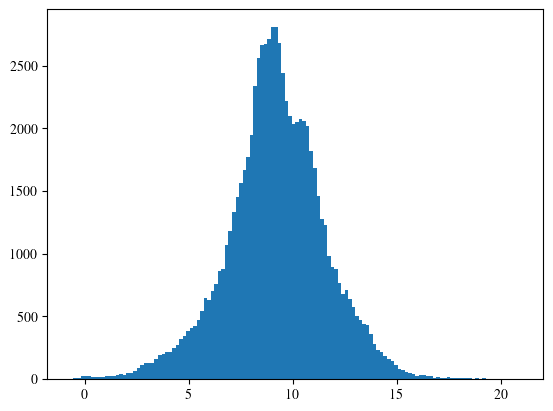

In [31]:
plt.hist(Rg[wmask], 128);

In [32]:
binsss = np.linspace(4,14,11)
binsss

array([ 4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.])

4.0 5.0
1714
5.0 6.0
2948
6.0 7.0
5148
7.0 8.0
9227
8.0 9.0
15036
9.0 10.0
14595
10.0 11.0
11837
11.0 12.0
7270
12.0 13.0
4155
13.0 14.0
2453


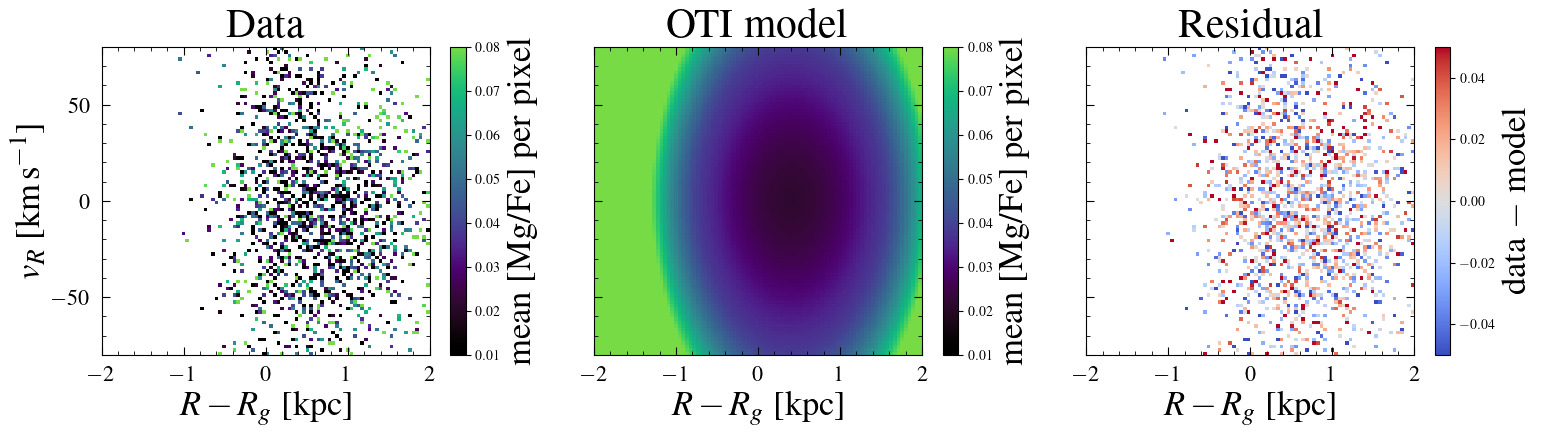

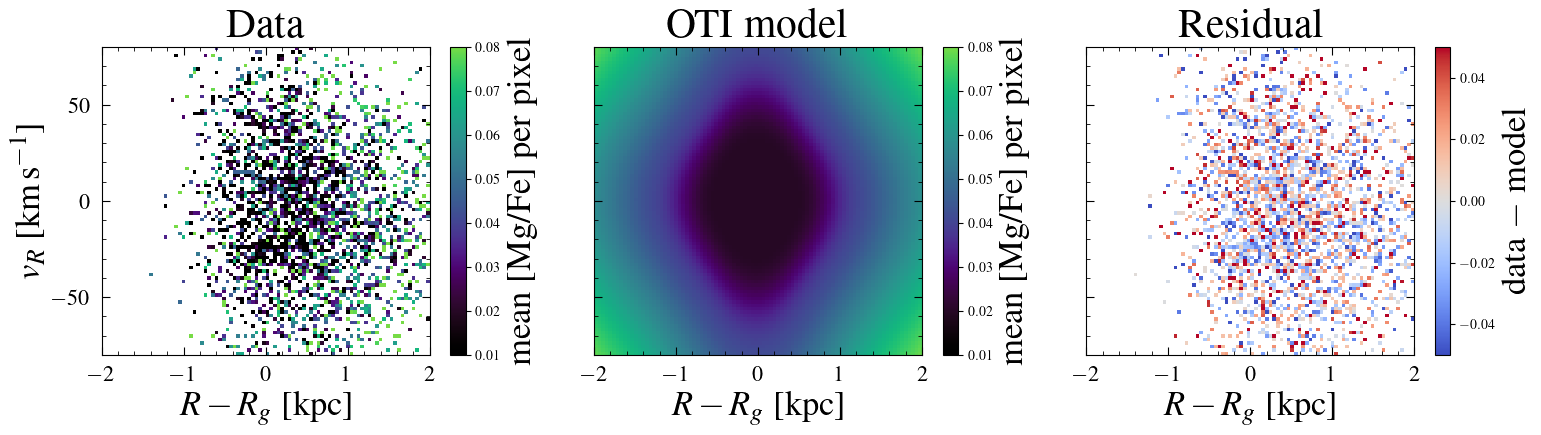

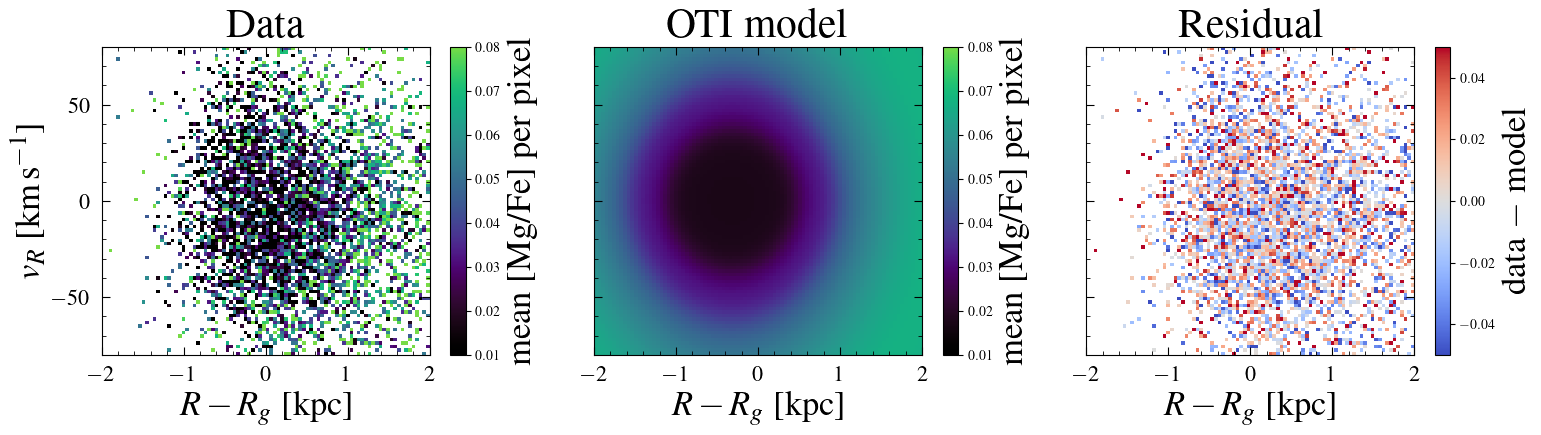

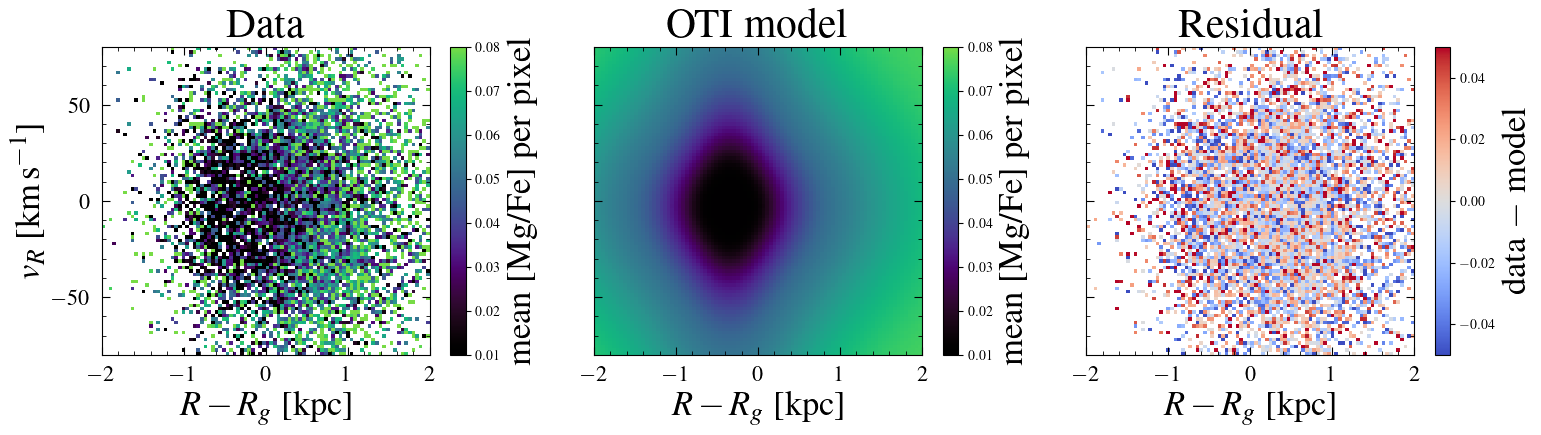

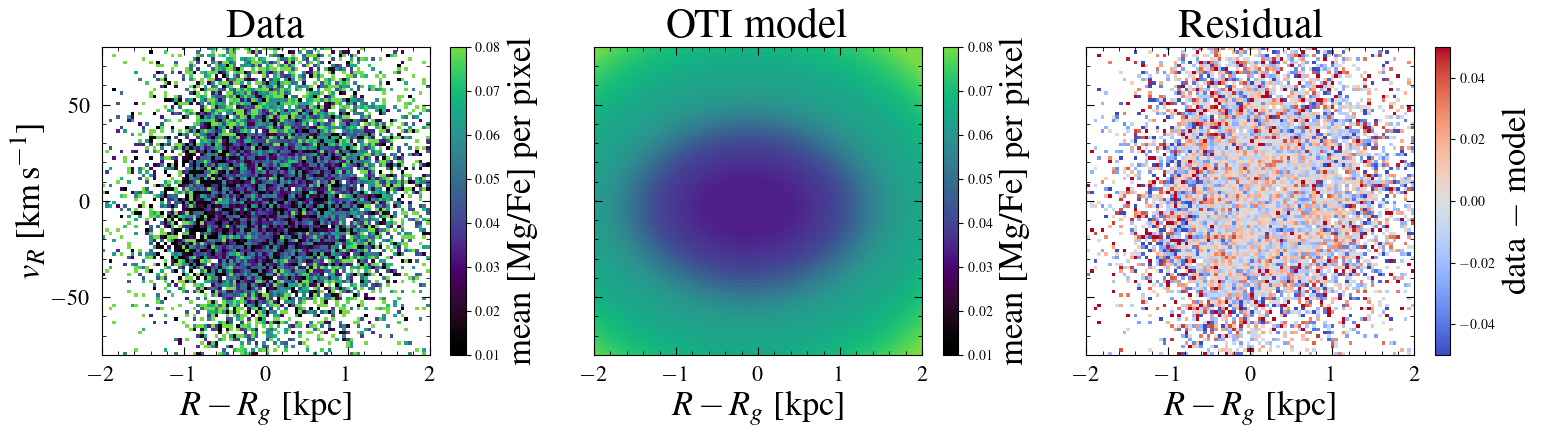

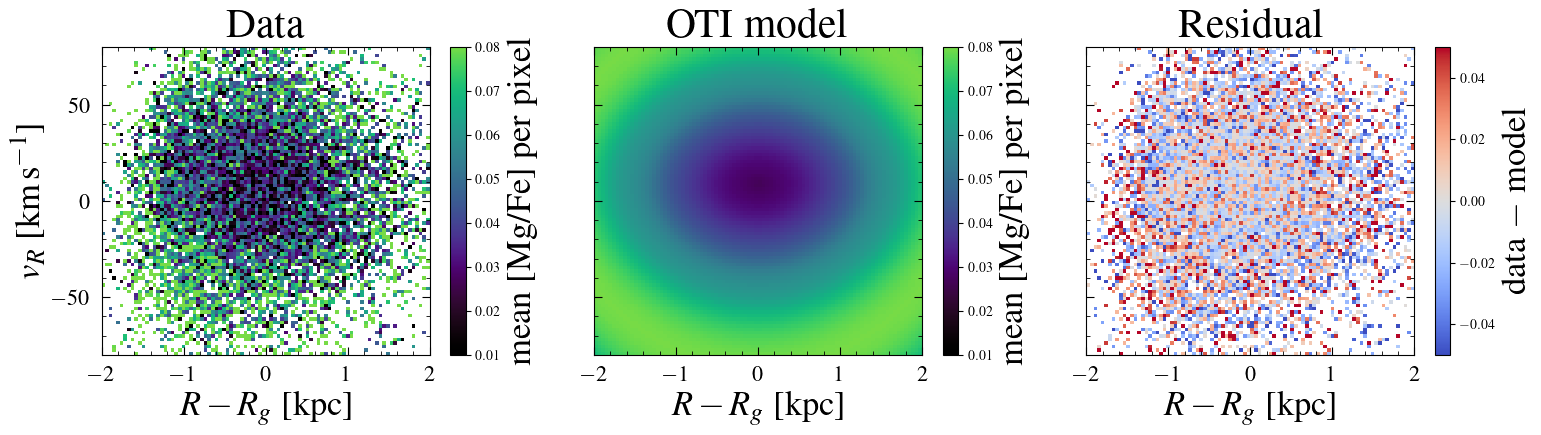

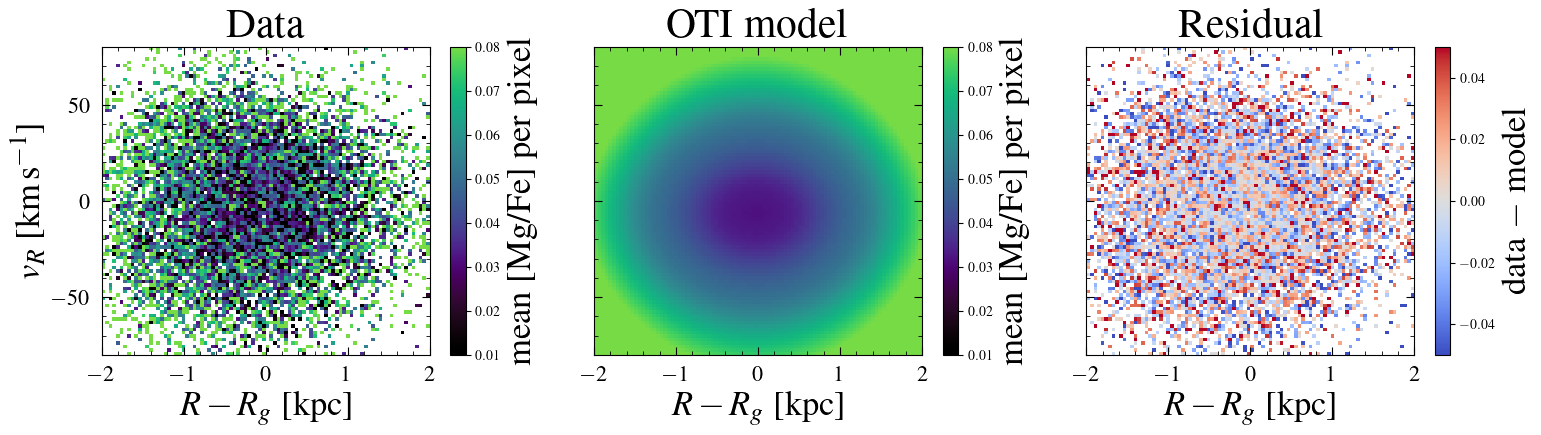

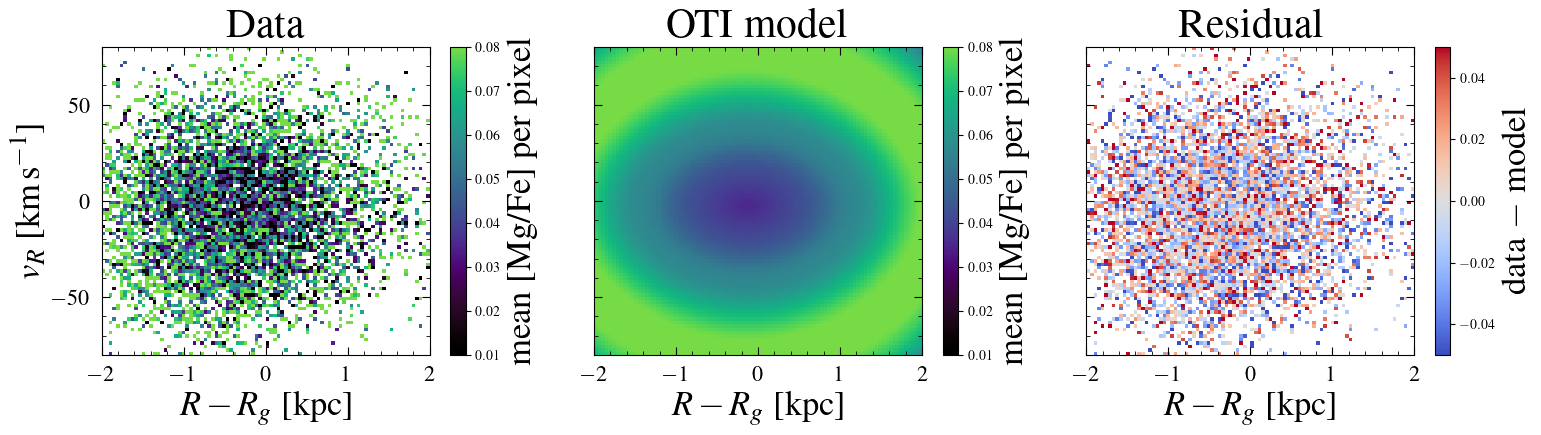

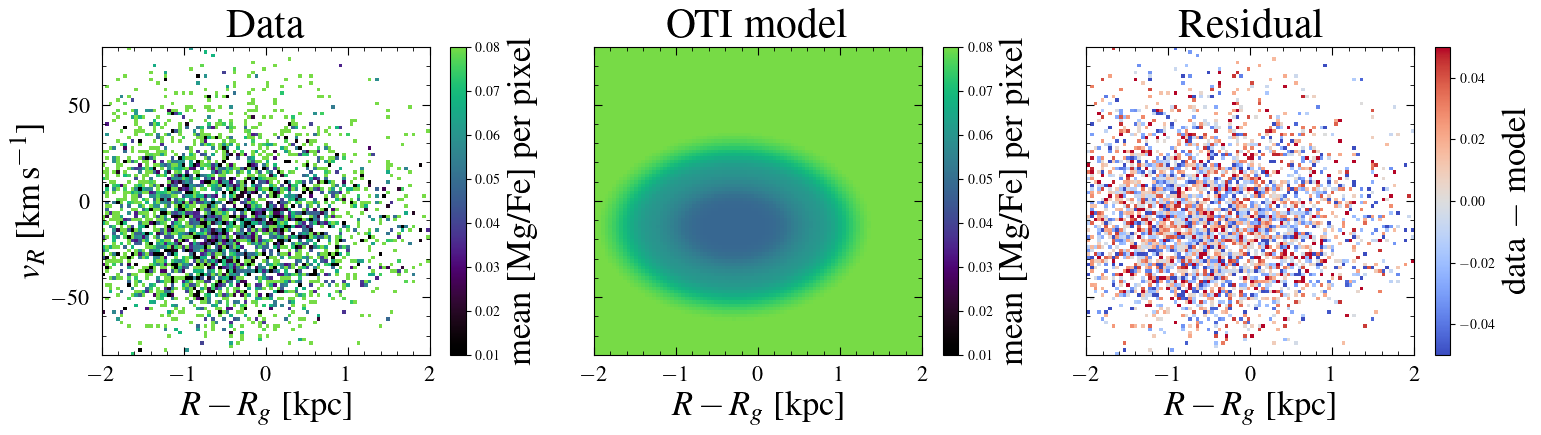

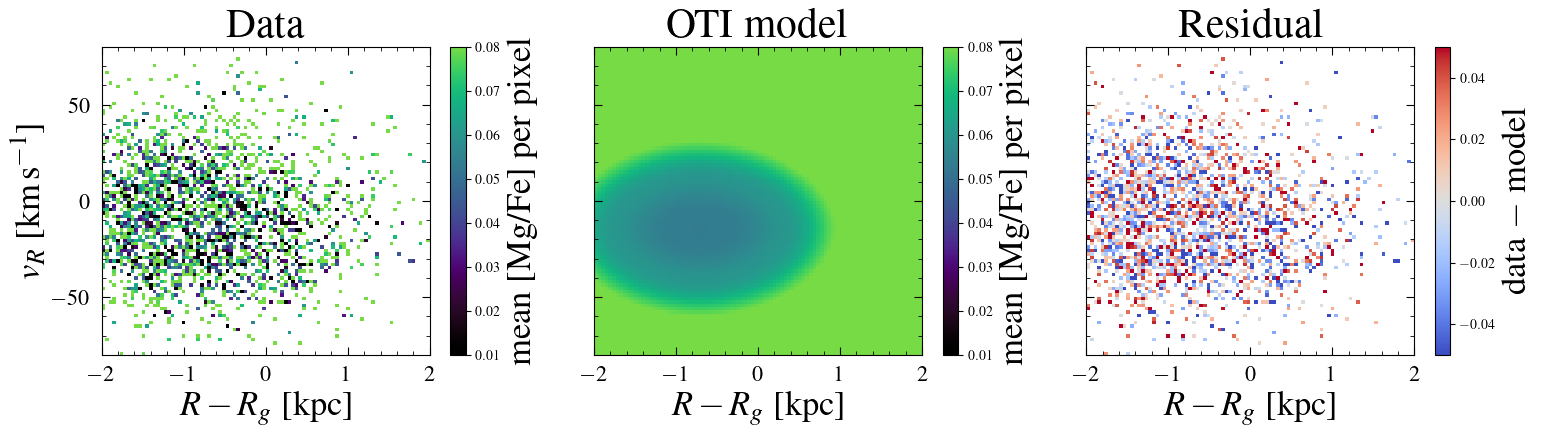

In [33]:
binsss = np.linspace(4,14,11)
bdata_clean_bins = []
res_bins = []

for indx, i in enumerate(binsss[:-1]):
    print(i, binsss[indx+1])
    mask_bin = (Rg>i)&(Rg<binsss[indx+1])&wmask
    # &(np.abs(data['xyz'][:,2])<0.5)
    print(len(Rg[mask_bin]))
    bdata_clean_bins_, res_bins_ = get_bins_plot(x_param, y_param, label, label_err, mask_bin)
    bdata_clean_bins.append(bdata_clean_bins_)
    res_bins.append(res_bins_)

In [65]:
vcirc = np.zeros((len(binsss[:-1])))
Rg0 =  np.zeros((len(binsss[:-1])))

for indx, i in enumerate(binsss[:-1]):
    mask_bin = (Rg>i)&(Rg<binsss[indx+1])&wmask
    rads = np.nanmedian(Rgal[mask_bin])
    vphis = np.nanmedian(vt[mask_bin])

    Rg0_ =  rads - res_bins[indx].params['pos0']
    vcirc[indx] = (rads*vphis)/Rg0_
    Rg0[indx] = Rg0_


[224.12053607 214.44907372 211.2563397  210.37998353 223.91709127
 230.86585556 229.75815651 228.94658753 226.55337867 222.57164507]


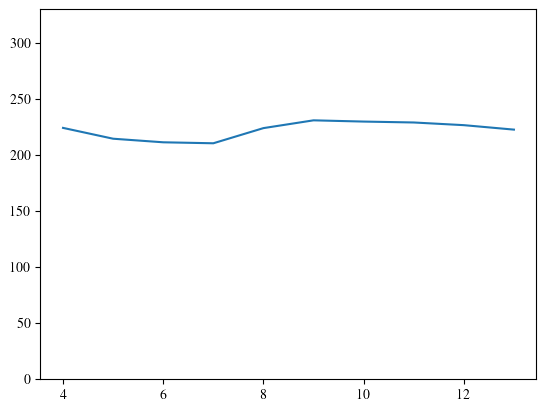

In [66]:
# vcirc = 229.-1.7*(Rgal-8.275)
# plt.plot(np.linspace(4,14,10),vcircs)
plt.plot(binsss[:-1],vcirc)
plt.ylim(0,330)

print(vcirc)

(4.0, 14.0)

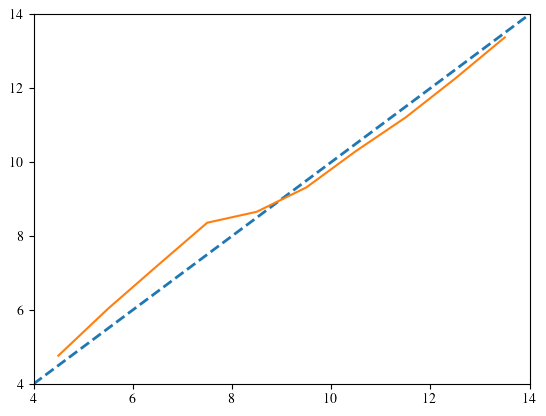

In [72]:
plt.plot([4,14],[4,14],lw=2,ls='--')
plt.plot(binsss[:-1]+0.5, Rg0)
plt.xlim(4,14)
plt.ylim(4,14)


In [73]:
dens = np.zeros((len(binsss[:-1])))

for indx, i in enumerate(binsss[:-1]):
    rg = Rg0[indx]*u.kpc 
    kappa = np.exp(res_bins[indx].params['ln_Omega0'])*1./u.Myr
    vcircs = vcirc[indx]*u.km/u.s
    vcircs = vcircs.to(u.kpc/u.Myr)
    omega = vcircs/rg
    G_ = G.to(u.pc**3/(u.solMass*u.Myr**2))
    scale = 1./(4.*np.pi*G_)
    num = kappa**2 - 2.*(omega**2)
    res = num * scale
print(Rg0)
    

[ 4.76371409  6.03260891  7.20336437  8.36034918  8.65730743  9.31675285
 10.30052084 11.20840921 12.26139499 13.37560134]


In [184]:
dOmega2_dR = np.zeros((len(binsss[:-1])))

for indx, i in enumerate(binsss[:-1]):
    rg = (i+0.5)*u.kpc # assuming Rg = R because I selected young stars on near-circular orbits
    mask_bin = (Rg>i)&(Rg<binsss[indx+1])&wmask
    mean_feh = np.nanmean(data['FE_H'][mask_bin])
    log_vphi_r = 0.857*mean_feh + 3.3
    vphi_r = np.exp(log_vphi_r)*(u.km/(u.s*u.kpc))
    kappa = np.exp(res_bins[indx].params['ln_Omega0'])*1./u.Myr

    resultado = (kappa**2 - 4*vphi_r**2)/rg
    dOmega2_dR[indx] = resultado.value


In [185]:
dOmega2_dR * 0.5

array([-1.02566029e-04, -1.48891404e-04, -1.25013545e-04, -1.14666734e-04,
       -9.12858622e-05, -6.35070604e-05, -6.06735009e-05, -5.98794086e-05,
       -5.32723774e-05, -4.65765495e-05])

In [ ]:
dens = np.zeros((len(binsss[:-1])))

for indx, i in enumerate(binsss[:-1]):
    rg = (i+0.5)*u.kpc
    mask_bin = (Rgal>i)&(Rgal<binsss[indx+1])&wmask
    mean_feh = np.nanmean(data['FE_H'][mask_bin])
    lzs = (-1600*mean_feh + 1900)*((u.km/u.s)*u.kpc)
    # r = (-7.33*mean_feh + 9.)*u.kpc
    kappa = np.exp(res_bins[indx].params['ln_Omega0'])*1./u.Myr
    scale = 1./(4.*np.pi*G)
    # d = scale * ((lzs**2/r**4) + kappa**2 -3.*(lzs**2/rg**4))
    d = scale * (kappa**2 -2.*(lzs**2/rg**4))
    de = d.to(u.solMass/u.pc**3)
    dens[indx] = (de.value)

In [257]:
dens

array([-0.06735482, -0.06094667, -0.01715769, -0.01502198, -0.00761381,
       -0.00047841,  0.00761259,  0.02133502,  0.01362478])

Text(0, 0.5, '$\\rho$ [M$_{\\odot}$/pc$^{3}$]')

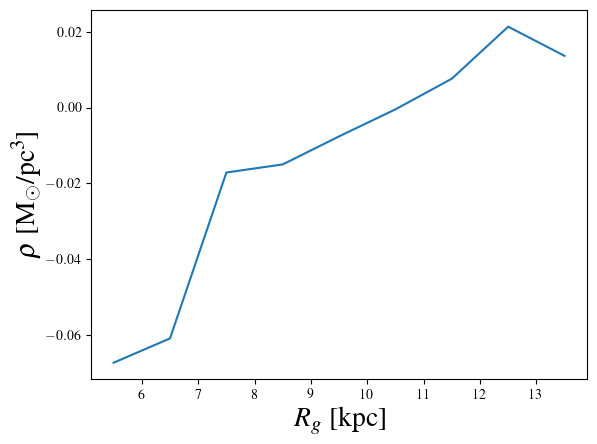

In [256]:
plt.plot(binsss[:-1]+0.5, dens)
plt.xlabel('$R_g$ [kpc]', fontsize=20)
plt.ylabel(r'$\rho$ [M$_{\odot}$/pc$^{3}$]', fontsize=20)

In [252]:
vcs = np.zeros((len(binsss[:-1])))

for indx, i in enumerate(binsss[:-1]):
    rg = (i+0.5)*u.kpc
    densidad = dens[indx] * u.solMass/u.pc**3
    kappa = np.exp(res_bins[indx].params['ln_Omega0'])*1./u.Myr
    braket = 4.*np.pi*G*densidad - kappa**2
    num = braket*rg**2
    res = np.sqrt(num/4.)
    res = res.to(u.km/u.s)
    vcs[indx] = res.value

In [253]:
vcs

array([199.87289464, 221.57016592, 225.25259878, 233.70082963,
       240.14069135, 234.55023769, 234.55507051, 220.17135928,
       225.2486236 ])

Text(0, 0.5, '$v_c$ [km/s]')

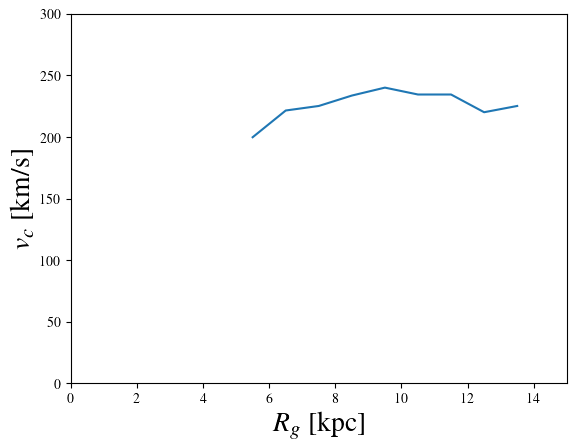

In [254]:
plt.plot(binsss[:-1]+0.5, vcs)
plt.ylim(0,300)
plt.xlim(0,15)
plt.xlabel('$R_g$ [kpc]', fontsize=20)
plt.ylabel('$v_c$ [km/s]', fontsize=20)

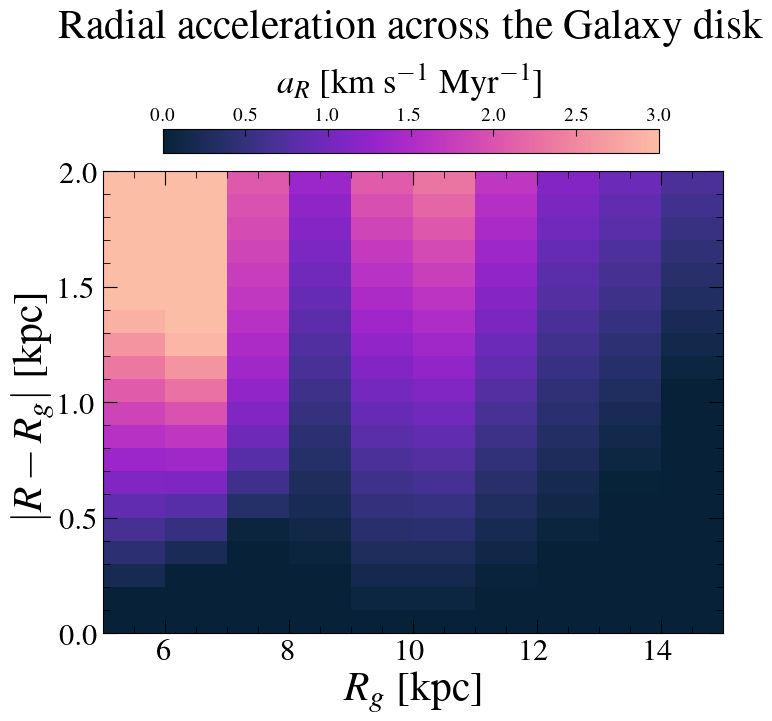

In [72]:

fig = plt.figure(figsize=(8,6),facecolor='white', rasterized=True)

fig.suptitle('Radial acceleration across the Galaxy disk',fontsize=30,x=0.51,y=1.15,rasterized=True)
plt.pcolormesh(
    binsss[:-1]+0.5,
    np.abs(bins_deltaR.value)+0.05,
    acc_R.T,
    shading="auto",
    cmap=cm.bubblegum,
    vmin=0,
    vmax=3,
)
plt.ylim(0,2)
# plt.xlim(5.5,13.5)
plt.xlabel(r'$R_g$ [kpc]',fontsize=30)
plt.ylabel(r'$|R-R_g|$ [kpc]',fontsize=30)
# plt.colorbar(label=r'$K_{z}$ [kpc Myr$^{-2}$]')
plt.tick_params(labelsize=16,direction='in',top=True,right=True,length=6)
plt.tick_params(which='major',labelsize=22,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=5, direction='in',top=True,right=True)
plt.minorticks_on()
# plt.xlim(6,12)
# plt.ylim(0,1.3)
# plt.text(9.09,0.0,r'$\odot$',color='white',fontsize=30,weight="bold")
cbar_ax = fig.add_axes([0.2, 0.91, 0.62,0.04])
cb = plt.colorbar(cax = cbar_ax,orientation='horizontal')
cb.set_label(label=r'$a_{R}$ [km s$^{-1}$ Myr$^{-1}$]',fontsize=25,labelpad=10)
cb.ax.tick_params(labelsize=30)
cb.ax.xaxis.set_ticks_position('top')
cb.ax.xaxis.set_label_position('top')
plt.tick_params(labelsize=16,direction='in',top=True,right=True,length=6)
plt.tick_params(which='major',labelsize=14,direction='in',top=True,right=True,length=5)
plt.tick_params(which='minor', length=3, direction='in',top=True,right=True)

# plt.savefig('/Users/dhortad/Projects/Torusimaging-radial/plots/acc-deltaR-R-z0poin2.pdf',dpi=250, bbox_inches = 'tight')


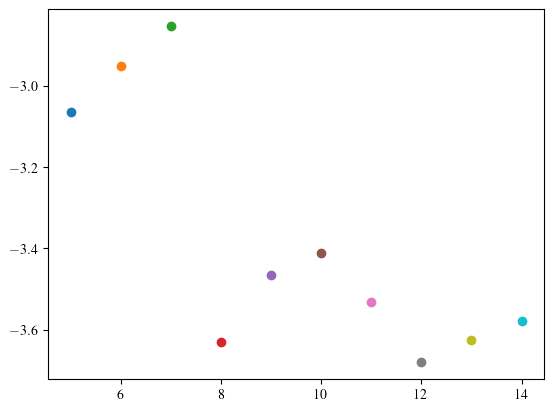

In [74]:
acc_R = acc_R*(u.kpc/u.Myr**2)
acc_R = acc_R.to(u.km/(u.s * u.Myr))
for indx, i in enumerate(res_bins):
    plt.scatter(binsss[indx], i.params['ln_Omega0'], label=r'$R_g:$'+str(round(binsss[jndx])))



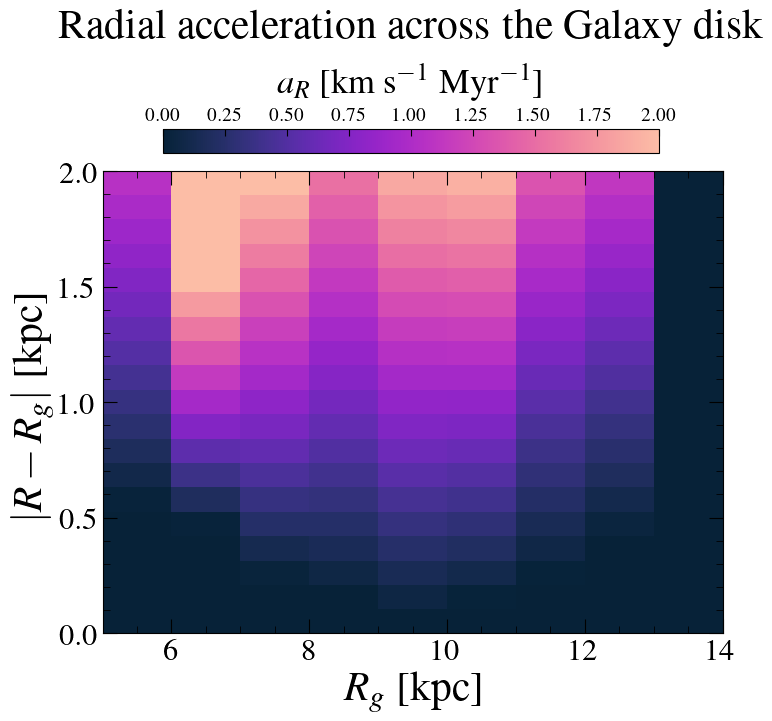

In [176]:

fig = plt.figure(figsize=(8,6),facecolor='white', rasterized=True)

fig.suptitle('Radial acceleration across the Galaxy disk',fontsize=30,x=0.51,y=1.15,rasterized=True)
plt.pcolormesh(
    binsss[:-1]+0.5,
    np.abs(bins_deltaR.value)+0.05,
    acc_R.T.value,
    shading="auto",
    cmap=cm.bubblegum,
    vmin=0,
    vmax=2,
)
plt.ylim(0,2)
# plt.xlim(5.5,13.5)
plt.xlabel(r'$R_g$ [kpc]',fontsize=30)
plt.ylabel(r'$|R-R_g|$ [kpc]',fontsize=30)
# plt.colorbar(label=r'$K_{z}$ [kpc Myr$^{-2}$]')
plt.tick_params(labelsize=16,direction='in',top=True,right=True,length=6)
plt.tick_params(which='major',labelsize=22,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=5, direction='in',top=True,right=True)
plt.minorticks_on()
# plt.xlim(6,12)
# plt.ylim(0,1.3)
# plt.text(9.09,0.0,r'$\odot$',color='white',fontsize=30,weight="bold")
cbar_ax = fig.add_axes([0.2, 0.91, 0.62,0.04])
cb = plt.colorbar(cax = cbar_ax,orientation='horizontal')
cb.set_label(label=r'$a_{R}$ [km s$^{-1}$ Myr$^{-1}$]',fontsize=25,labelpad=10)
cb.ax.tick_params(labelsize=30)
cb.ax.xaxis.set_ticks_position('top')
cb.ax.xaxis.set_label_position('top')
plt.tick_params(labelsize=16,direction='in',top=True,right=True,length=6)
plt.tick_params(which='major',labelsize=14,direction='in',top=True,right=True,length=5)
plt.tick_params(which='minor', length=3, direction='in',top=True,right=True)

# plt.savefig('/Users/dhortad/Projects/Torusimaging-radial/plots/acc-deltaR-R-z0poin2.pdf',dpi=250, bbox_inches = 'tight')


In [177]:
dens_R = np.zeros((len(res_bins), len(bins_deltaR)))
G_val = G.to(u.kpc**3/(u.solMass * u.Myr**2))
factor = 1./(4.*np.pi*G_val)
vc = 229.0 * u.km/u.s
vc = vc.to(u.kpc/u.Myr)

for indx, i in enumerate(res_bins):
    for jndx, j in enumerate(bins_deltaR):
        # freq = np.exp(i.params['ln_Omega0'])*(1./u.Myr)
        mask_bin = (Rg>binsss[indx])&(Rg<binsss[indx+1])&wmask&(np.abs(data['xyz'][:,2])<0.1)
        # radio = np.nanmean(Rgal[mask_bin])*(u.kpc)
        radio = (binsss[indx]+0.5)*(u.kpc)
        vel_circ = np.nanmean(vt[mask_bin])*(u.km/u.s)
        # vel_circ = vel_circ.to(u.kpc/u.Myr)
        momento_angular = radio*vel_circ
        momento_angular = radio*vc
        acc = acc_R[indx, jndx]
        dens_ = factor * (1./radio) * (acc + (momento_angular**2)/radio**3)
        dens_ = dens_.to(u.solMass/u.pc**3)
        dens_R[indx, jndx] = dens_.value

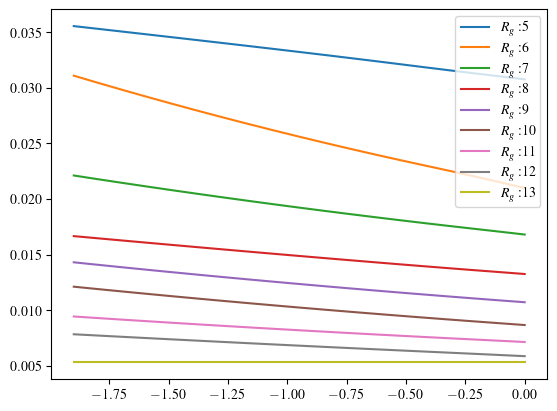

In [178]:
for jndx, j in enumerate(dens_R):
    plt.plot(bins_deltaR.value, j, label=r'$R_g:$'+str(round(binsss[jndx])))
plt.legend(loc='upper right')
# plt.yscale('log')
# plt.ylim(-10,10)

In [107]:
dens_R = dens_R * (u.solMass/(u.kpc**3))
dens_R = dens_R.to(u.solMass/u.pc**3)

In [83]:
# dens_R = dens_R * (u.kg * u.s**2)/(u.Myr**2 * u.m**3)
# dens_R = dens_R.to(u.solMass/u.pc**3)

In [73]:
bins_deltaR = np.linspace(0.,2.,21)*u.kpc
bins_deltaR

<Quantity [0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
           1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ] kpc>

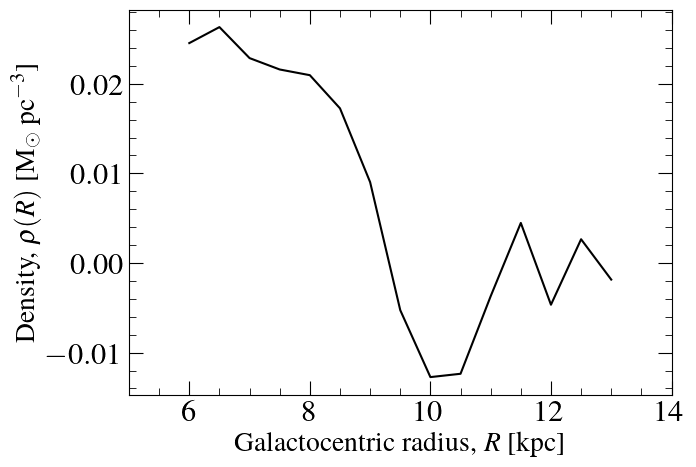

In [85]:
plt.figure(figsize=(7,5))
# plt.plot(Rs+1, dens_pos, lw=2, ls='dotted', color='k')
plt.plot(binsss[:-2]+1, dens_R, color='k')
plt.xlim(5,14)
# plt.ylim(1e-4,0.15)
# plt.yscale('log')
# plt.errorbar(8.275, 0.081, yerr = 0.0015, color='r', capsize=5)
plt.xlabel('Galactocentric radius, $R$ [kpc]', fontsize=20)
plt.ylabel(r'Density, $\rho(R)$ [M$_{\odot}$ pc$^{-3}$]', fontsize=20)
plt.legend(loc='upper right', frameon=False, ncols=2, fontsize=12)
plt.tick_params(labelsize=16,direction='in',top=True,right=True,length=6)
plt.tick_params(which='major',labelsize=22,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=5, direction='in',top=True,right=True)
plt.minorticks_on()

# plt.savefig('/Users/dhortad/Projects/Torusimaging-radial/plots/dens-z0point2.pdf',dpi=250, bbox_inches = 'tight')


In [112]:
dvc_dR_ = np.zeros((len(res_bins), len(rminusrg_bins)))
vc = 229.0 
dvc_dR_pos = np.zeros((len(res_bins)))

for indx, i in enumerate(res_bins):
    dvc_dR_pos[indx] = (-np.abs(i.params['pos0'])*freq**2)/(2.*vc)
    for jndx, j in enumerate(rminusrg_bins):
        freq = np.exp(i.params['ln_Omega0'])
        dvc_dR = (-np.abs(j)*freq**2)/(2.*vc)
        dvc_dR_[indx, jndx] = dvc_dR

In [113]:
dvc_dR_ = dvc_dR_*(u.kpc * u.s)/(u.km * u.Myr**2)
dvc_dR_ = dvc_dR_.to(u.km/(u.s * u.kpc))
dvc_dR_pos = dvc_dR_pos*(u.kpc * u.s)/(u.km * u.Myr**2)
dvc_dR_pos = dvc_dR_pos.to(u.km/(u.s * u.kpc))
dvc_dR_pos.shape, dvc_dR_.shape

((15,), (15, 19))

In [114]:
vcs = np.zeros((dvc_dR_.shape[0], 10))
vcs_pos = np.zeros((dvc_dR_pos.shape))
for indx, i in enumerate(dvc_dR_[:,:10]):
    vcs_pos[indx] = 229.0 + res_bins[indx].params['pos0']*(Rs[indx]+1 - 8.275)
    for jndx, j in enumerate(i):
        vcs[indx, jndx] = 229.0 + j.value*(Rs[indx]+1 - 8.275)


In [115]:
colores = ['indigo', 'rebeccapurple', 'purple', 'darkorchid', 'mediumorchid', 'magenta', 'violet', 'hotpink','plum', 'lightpink']

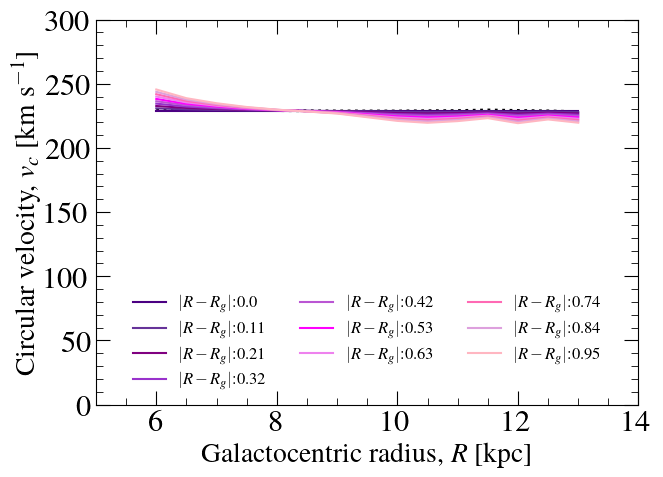

In [116]:
plt.figure(figsize=(7,5))
plt.plot(Rs+1, vcs_pos, lw=2, ls='dotted', color='k')
for indx, i in enumerate(vcs.T):
    plt.plot(Rs+1, i, label='$|R-R_g|$:'+str(np.abs(round(rminusrg_bins[indx],2))), color=colores[indx])
plt.xlim(5,14)
plt.ylim(0,300)
plt.xlabel('Galactocentric radius, $R$ [kpc]', fontsize=20)
plt.ylabel('Circular velocity, $v_c$ [km s$^{-1}$]', fontsize=20)
plt.legend(loc='lower center', frameon=False, ncols=3, fontsize=12)
plt.tick_params(labelsize=16,direction='in',top=True,right=True,length=6)
plt.tick_params(which='major',labelsize=22,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=5, direction='in',top=True,right=True)
plt.minorticks_on()

# plt.savefig('/Users/dhortad/Projects/Torusimaging-radial/plots/vcirc-z0point2.pdf',dpi=250, bbox_inches = 'tight')


In [80]:
for jndx, j in enumerate(res_bins):
    print(j.params['pos0'])

0.09319519445282372
-0.19525660525205701
-0.3248950643591109
-0.15319790084625773
-0.07492170802309454
0.051916150569007675
-0.03669513874352646
-0.013096326840494674
-0.56399420971934


In [118]:
dens_ = dens_ * ((u.kg * u.s**2)/(u.Myr**2 * u.m**3))
dens_ = dens_.to(u.solMass/u.pc**3)
dens_pos = dens_pos * ((u.kg * u.s**2)/(u.Myr**2 * u.m**3))
dens_pos = dens_pos.to(u.solMass/u.pc**3)
dens_pos.shape, dens_.shape

((15,), (15, 10))

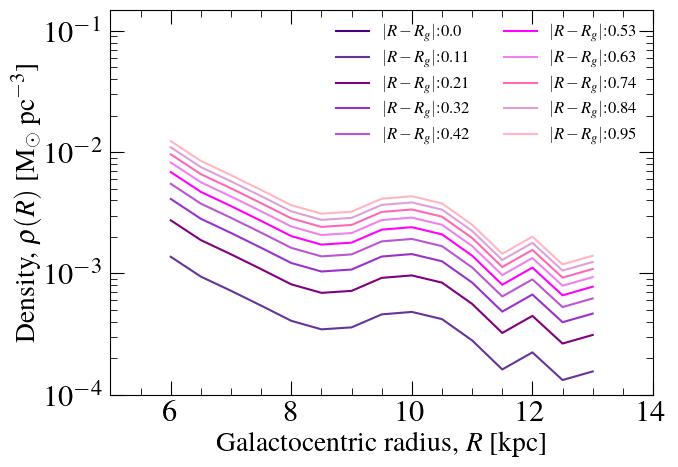

In [119]:
plt.figure(figsize=(7,5))
# plt.plot(Rs+1, dens_pos, lw=2, ls='dotted', color='k')
for indx, i in enumerate(dens_.T):
    plt.plot(Rs+1, i, label='$|R-R_g|$:'+str(np.abs(round(rminusrg_bins[indx],2))), color=colores[indx])
plt.xlim(5,14)
plt.ylim(1e-4,0.15)
plt.yscale('log')
# plt.errorbar(8.275, 0.081, yerr = 0.0015, color='r', capsize=5)
plt.xlabel('Galactocentric radius, $R$ [kpc]', fontsize=20)
plt.ylabel(r'Density, $\rho(R)$ [M$_{\odot}$ pc$^{-3}$]', fontsize=20)
plt.legend(loc='upper right', frameon=False, ncols=2, fontsize=12)
plt.tick_params(labelsize=16,direction='in',top=True,right=True,length=6)
plt.tick_params(which='major',labelsize=22,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=5, direction='in',top=True,right=True)
plt.minorticks_on()

plt.savefig('/Users/dhortad/Projects/Torusimaging-radial/plots/dens-z0point2.pdf',dpi=250, bbox_inches = 'tight')


In [141]:
Rgs = np.linspace(5,12,15)

dens__ = []
vc = 229.*u.km/u.s
vc = vc.to(u.kpc/u.Myr)
grav = G
grav = grav.to(u.kpc**3/(u.solMass*u.Myr**2))

for indx, i in enumerate(res_bins):
    freq = np.exp(i.params['ln_Omega0'])
    dens__.append(-(freq**2 - (3.*vc.value**2)/(Rgs[indx]))/(4.*np.pi*grav.value))


In [143]:
dens__ = dens__ * (u.solMass/u.kpc**3)
dens__ = dens__.to(u.solMass/u.pc**3)
dens__

<Quantity [0.51723367, 0.48025341, 0.444312  , 0.41445688, 0.38891161,
           0.36357129, 0.33667682, 0.30548529, 0.28241968, 0.26864897,
           0.26456349, 0.26118301, 0.24137688, 0.23875338, 0.22491813] solMass / pc3>

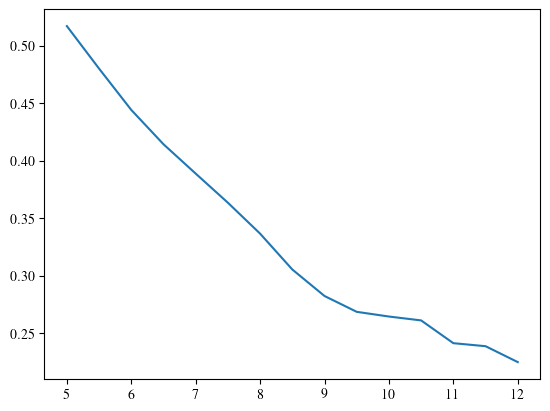

In [144]:
plt.plot(Rgs, dens__)

Now also bin in $\phi$

380
671
968
1381
1699
1824
1925
1768
1615
1298
914
606
379


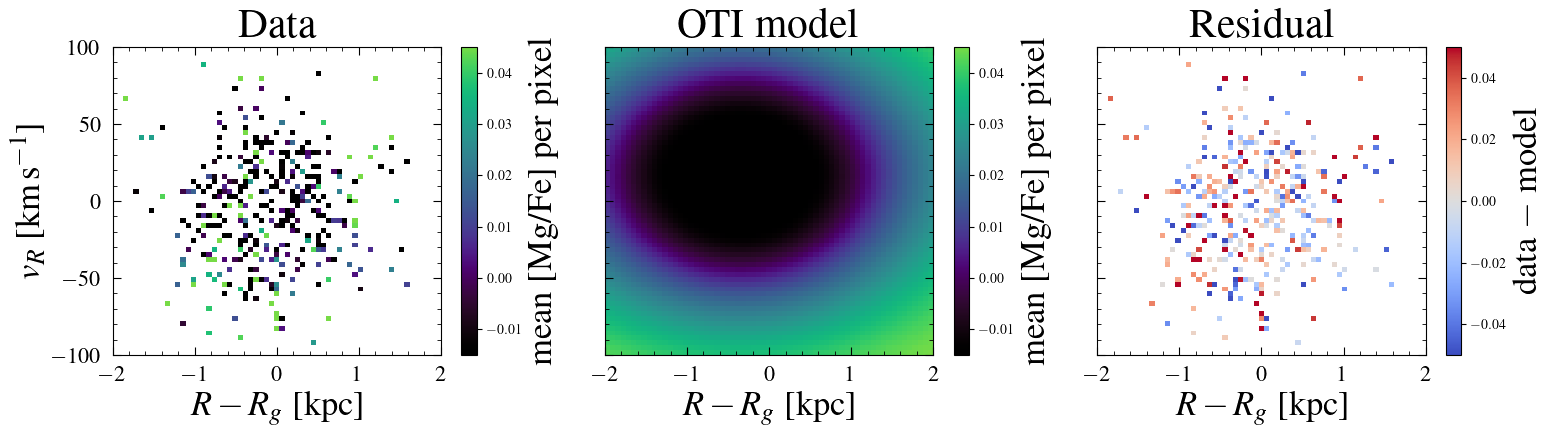

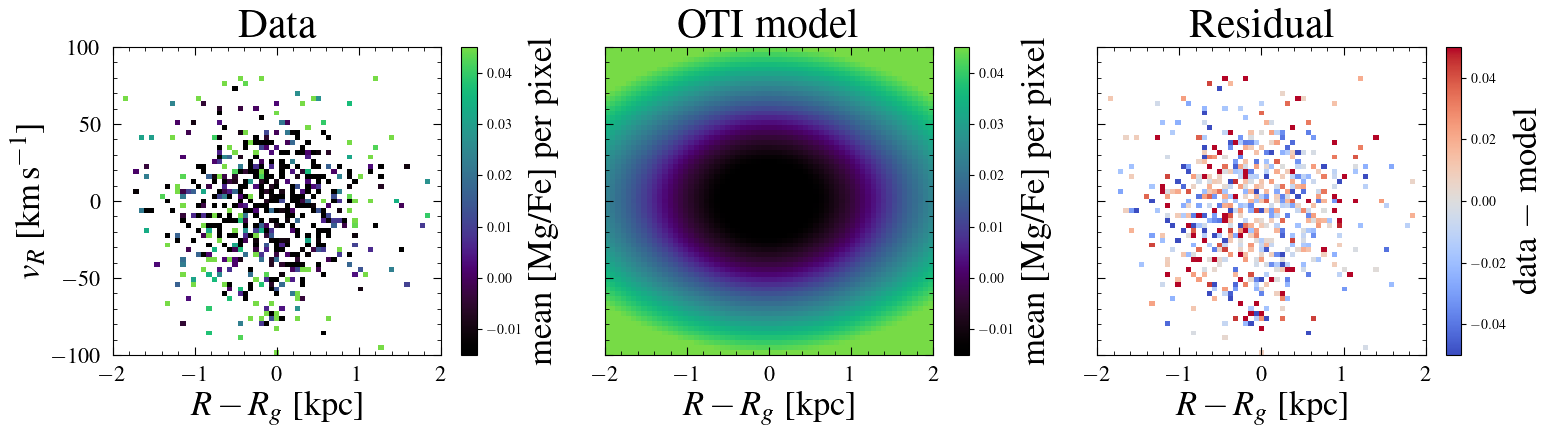

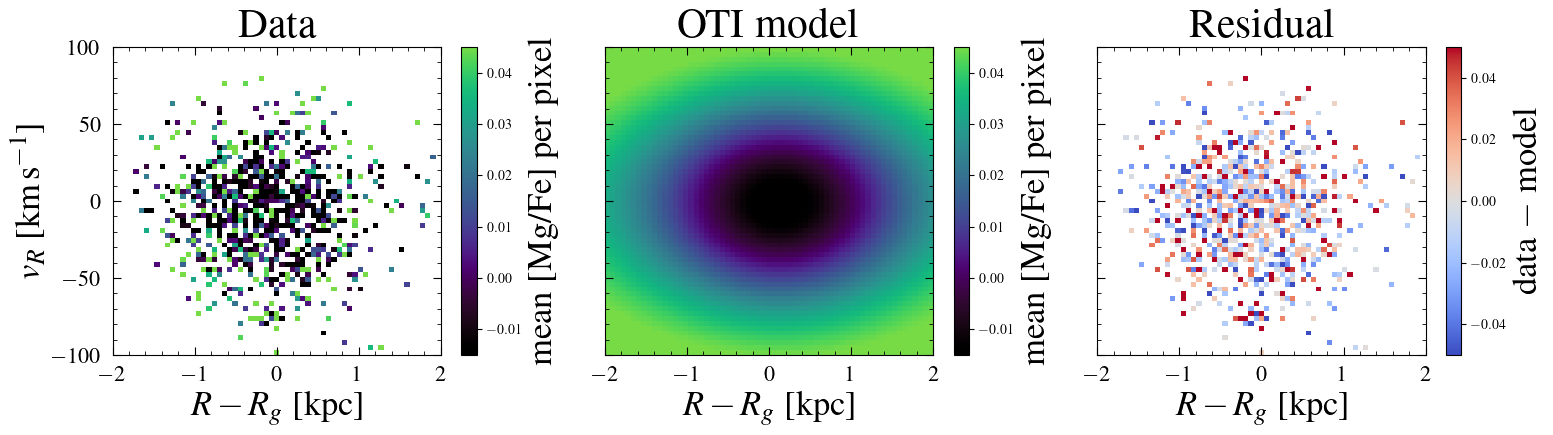

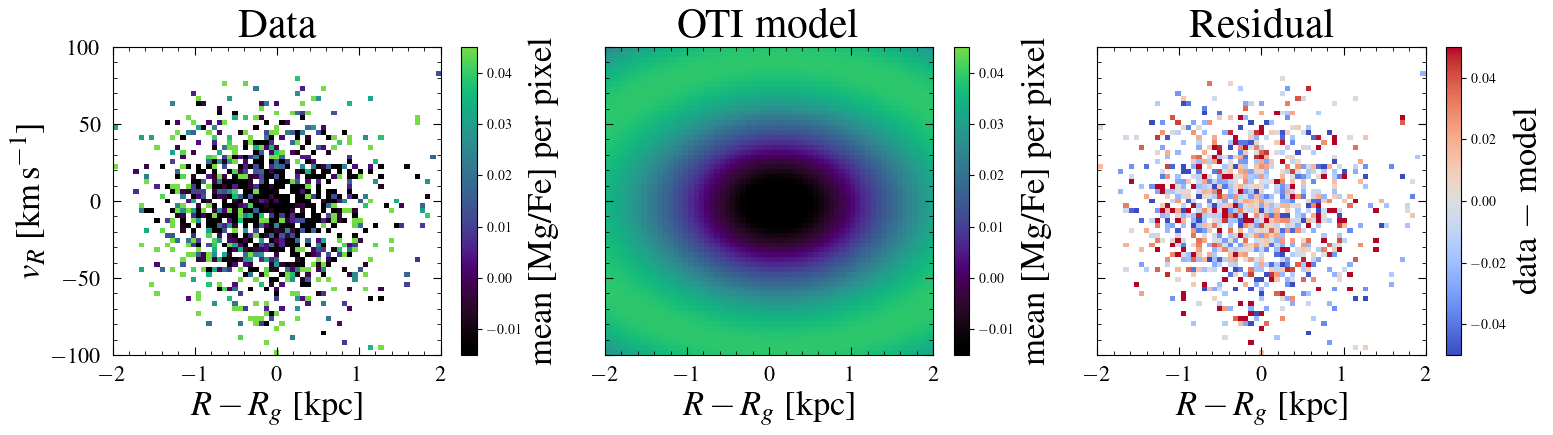

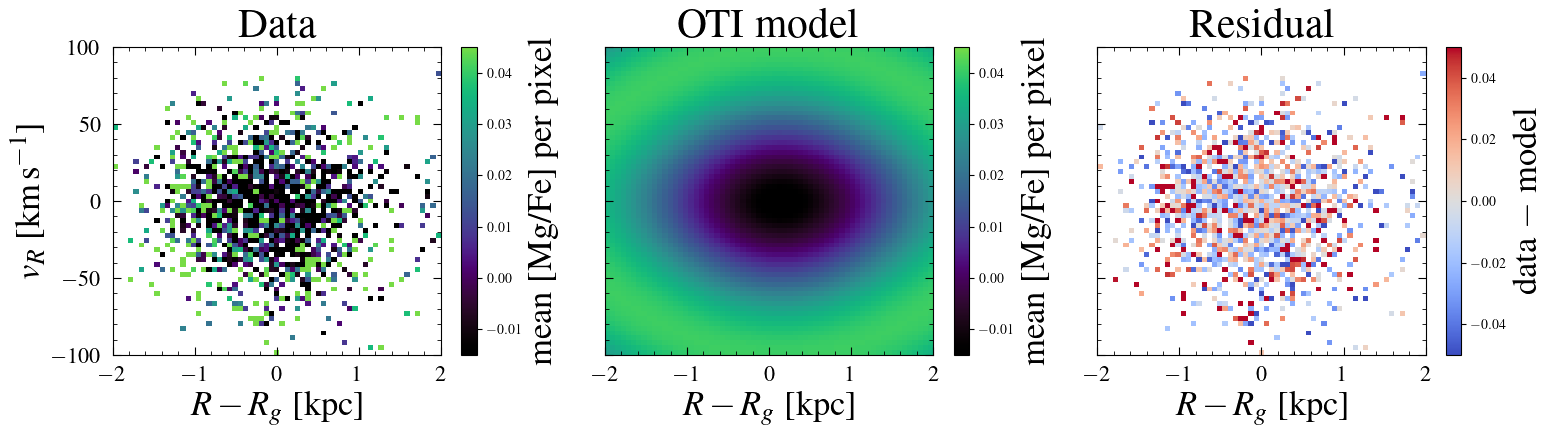

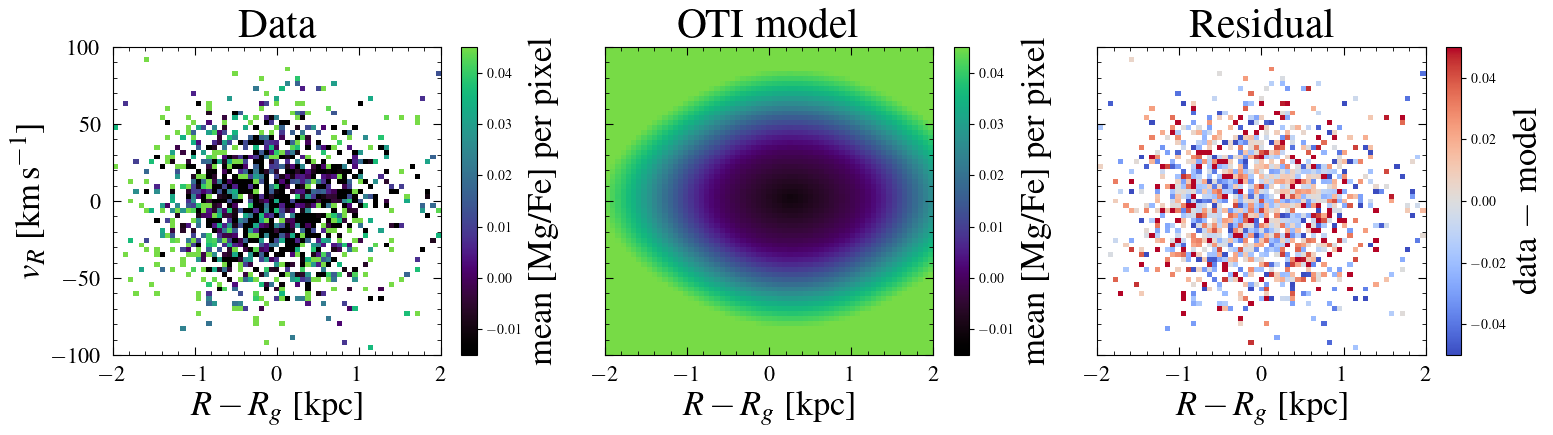

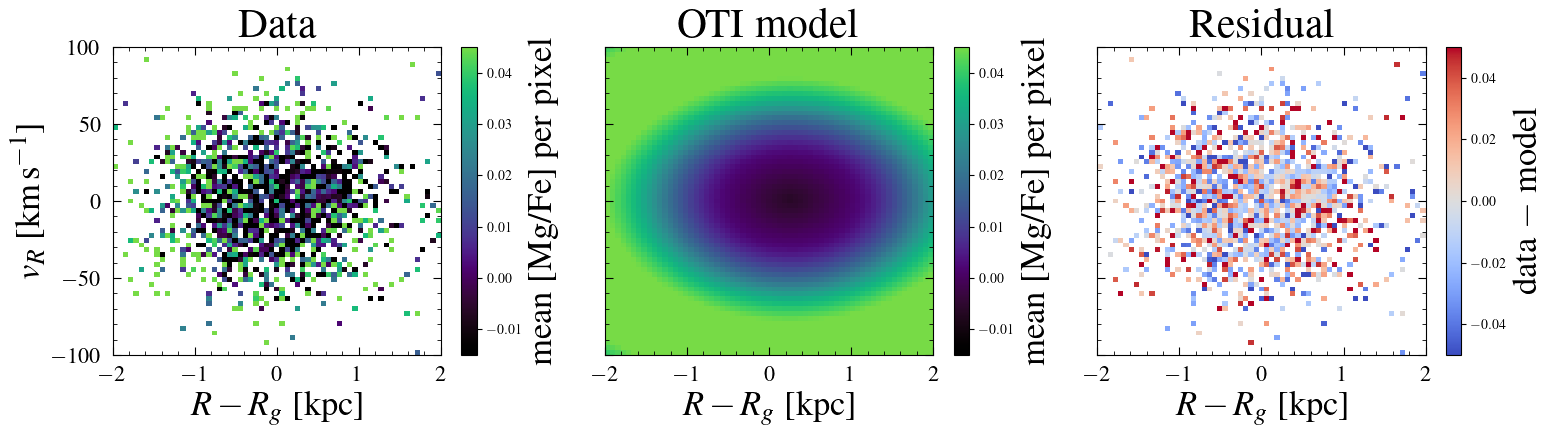

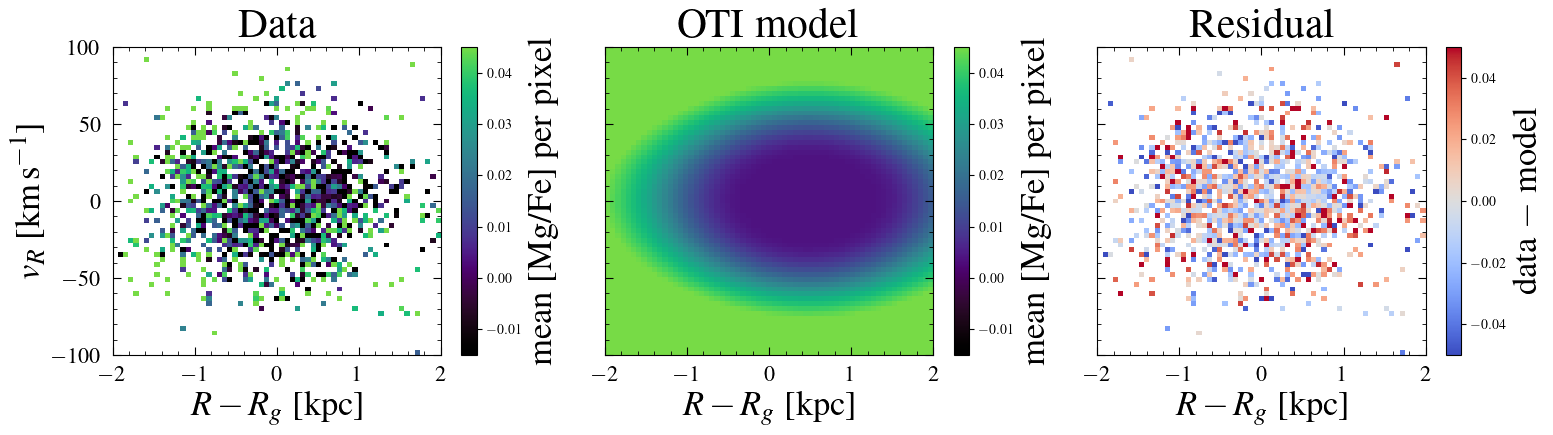

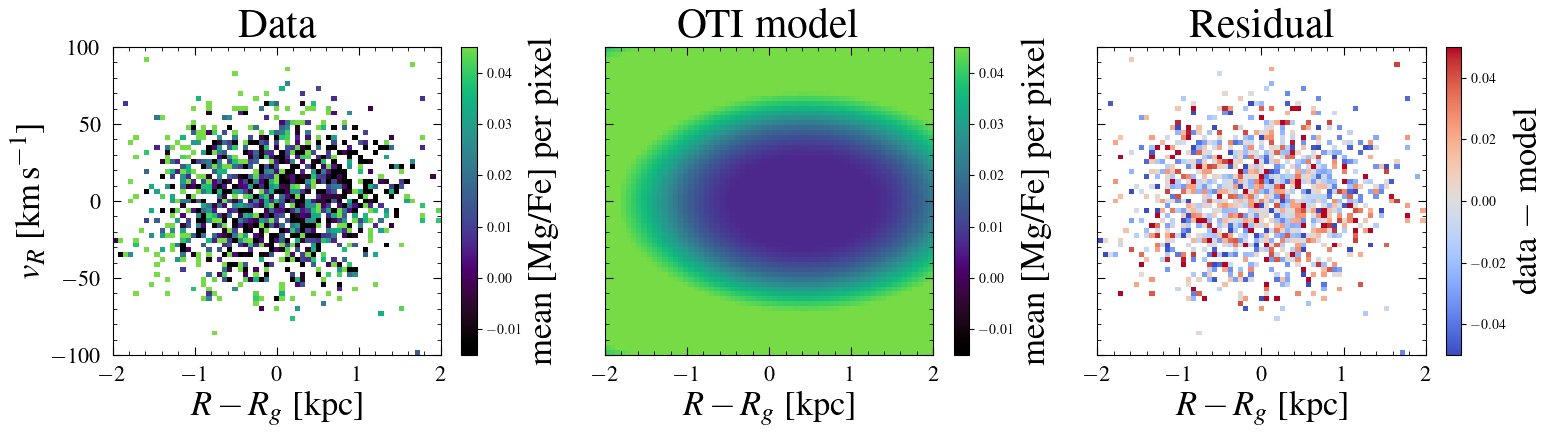

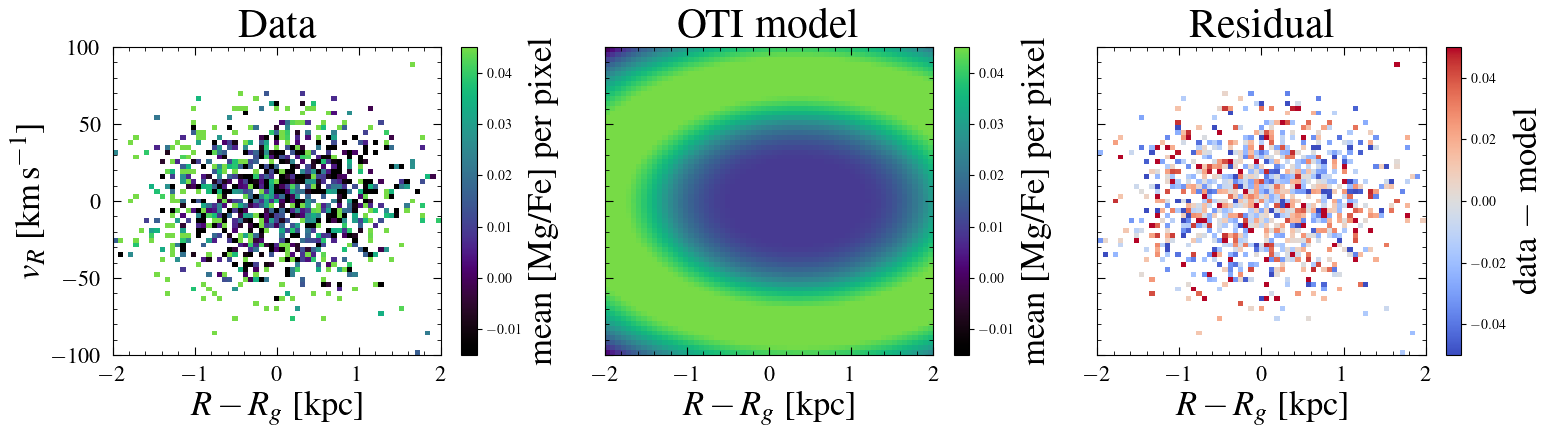

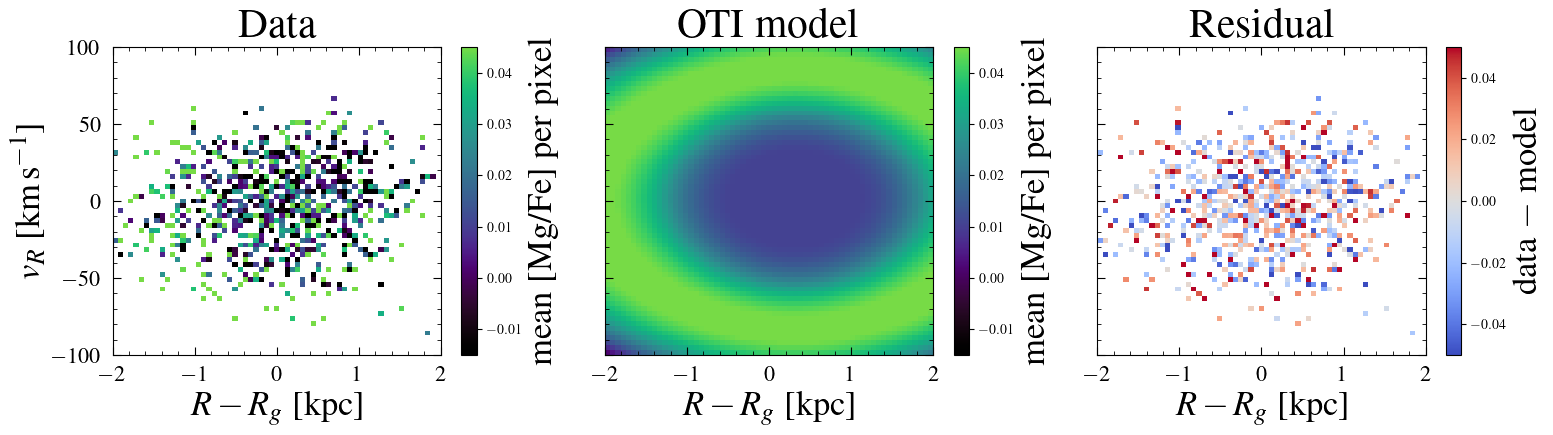

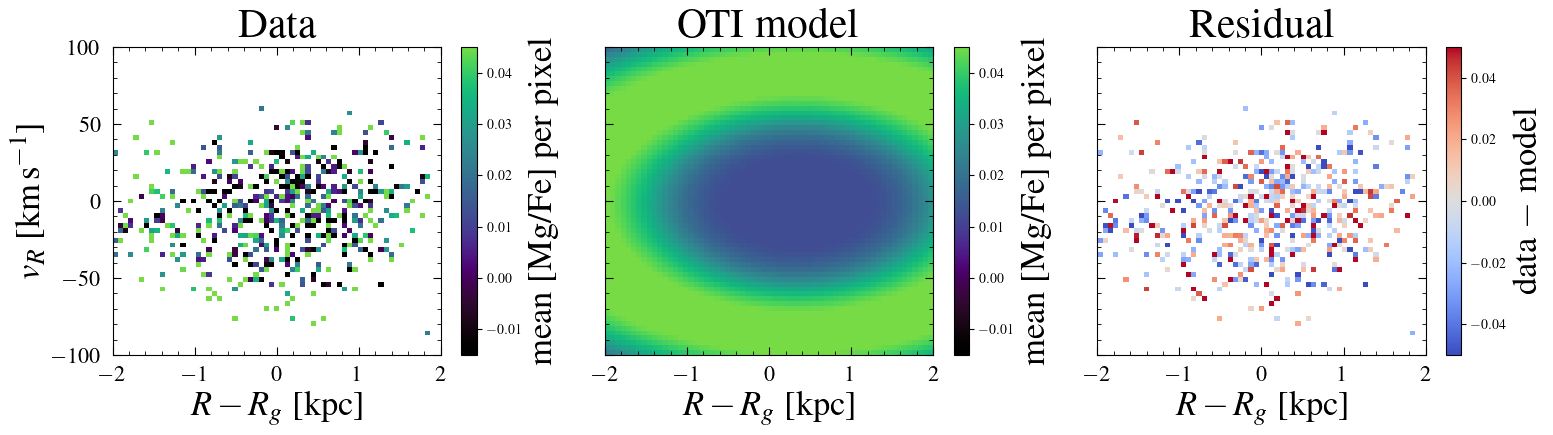

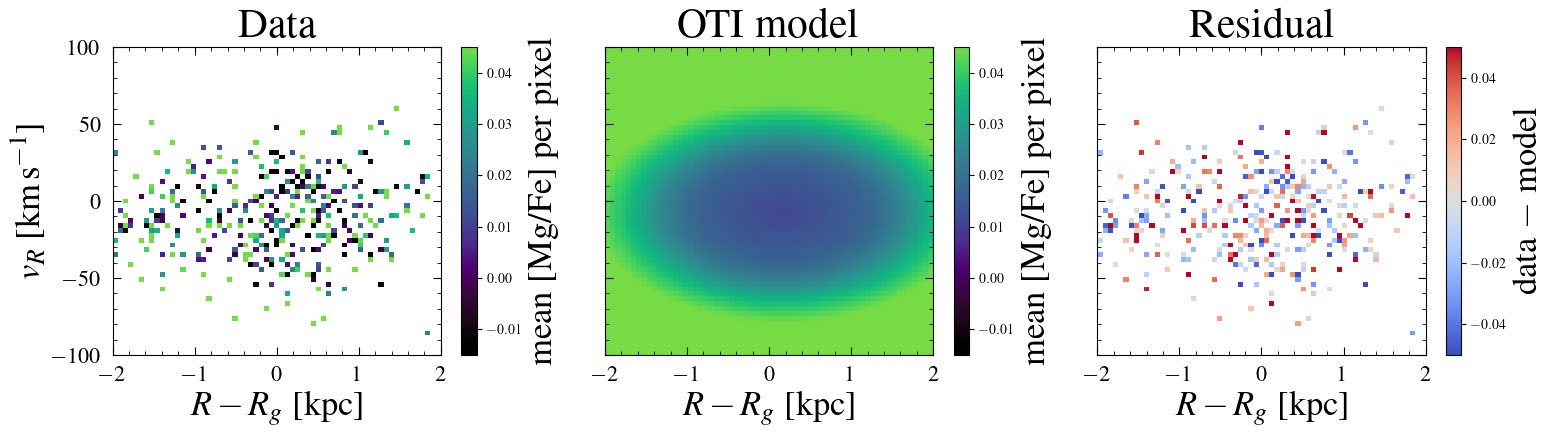

In [35]:
binsss = np.linspace(5,12,15)
bdata_clean_bins = []
res_bins_phi1 = []

for indx, i in enumerate(binsss[:-2]):
    mask_bin = (Rgal>i)&(Rgal<i+2)&wmask&(phi_deg<-10)
    print(len(Rgal[mask_bin]))
    bdata_clean_bins_, res_bins_ = get_bins_plot(x_param, y_param, label, label_err, mask_bin)
    bdata_clean_bins.append(bdata_clean_bins_)
    res_bins_phi1.append(res_bins_)

In [36]:
rminusrg_bins = np.linspace(-1.9,1.9,19)
acc_R_phi1 = np.zeros((len(res_bins_phi1), len(rminusrg_bins)))

for indx, i in enumerate(res_bins_phi1):
    for jndx, j in enumerate(rminusrg_bins):
        freq = np.exp(i.params['ln_Omega0'])
        acc_ = -j * freq**2
        acc_R_phi1[indx, jndx] = acc_

In [37]:
acc_R_phi1 = acc_R_phi1*u.kpc/u.Myr**2
acc_R_phi1 = acc_R_phi1.to(u.km/(u.s * u.Myr))

In [40]:
Rs = np.linspace(5,12,15)
dens_phi1 = np.zeros((len(res_bins_phi1), 10))
vc = 229.0 
dens_pos = np.zeros((len(res_bins_phi1)))

for indx, i in enumerate(res_bins_phi1):
    freq = np.exp(i.params['ln_Omega0'])
    for jndx, j in enumerate(rminusrg_bins[:10]):
        dens = (np.abs(j)*freq**2)/(4.*np.pi*G.value*Rs[indx])
        dens_phi1[indx, jndx] = dens

622
745
869
1944
2408
2936
3313
2627
2420
2083
1741
1355
984


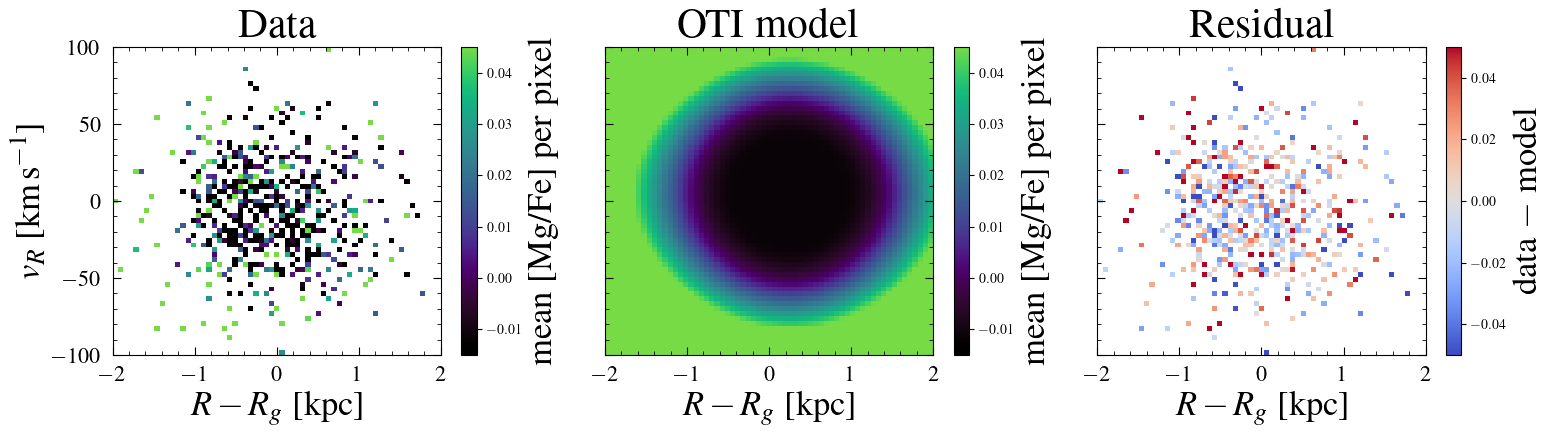

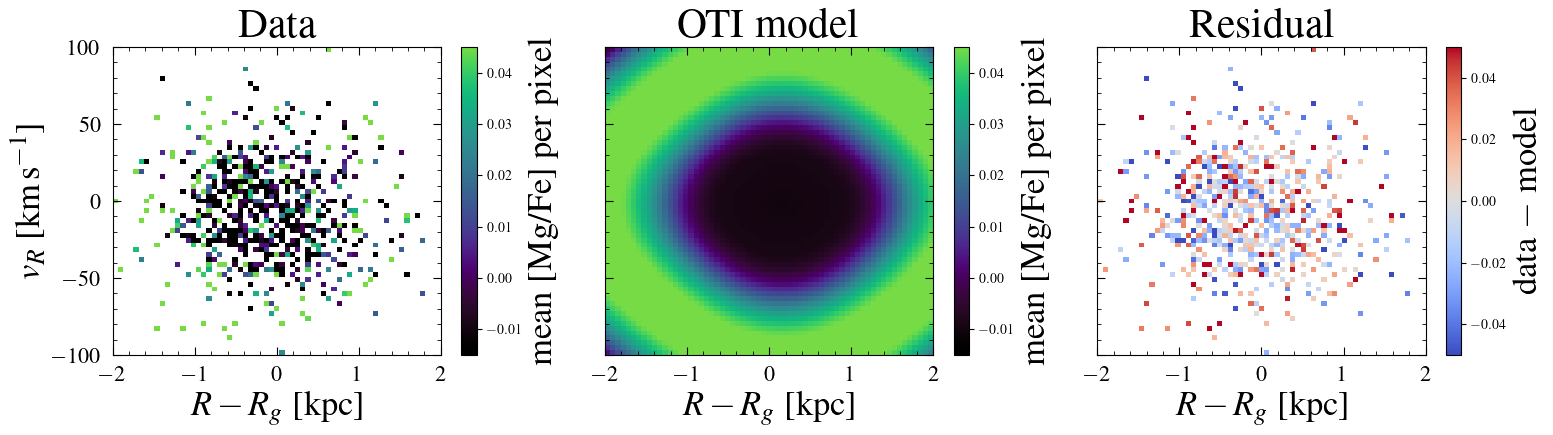

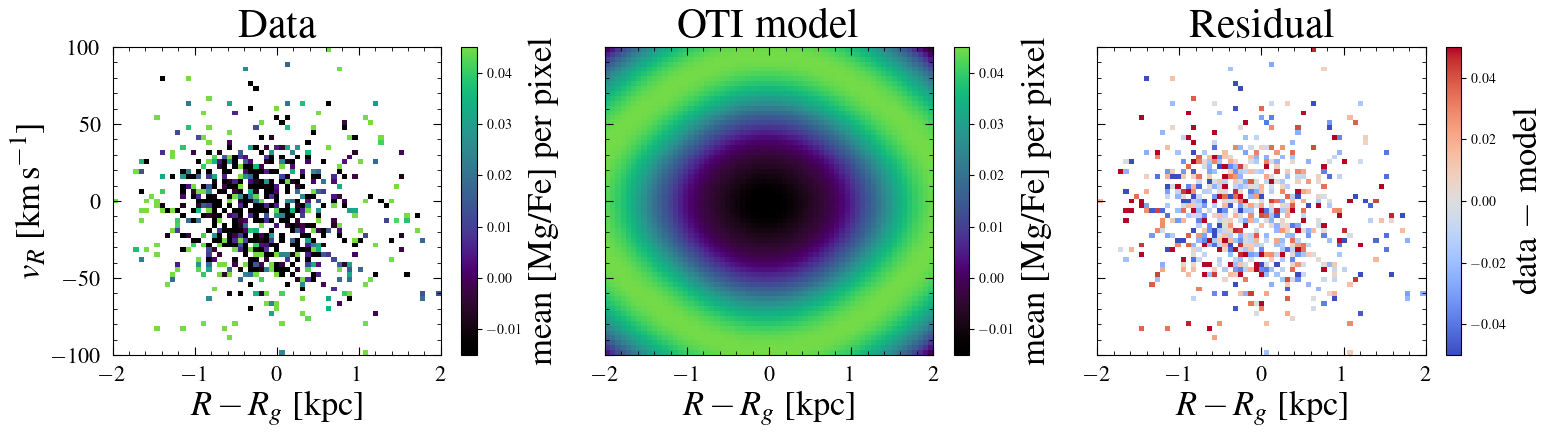

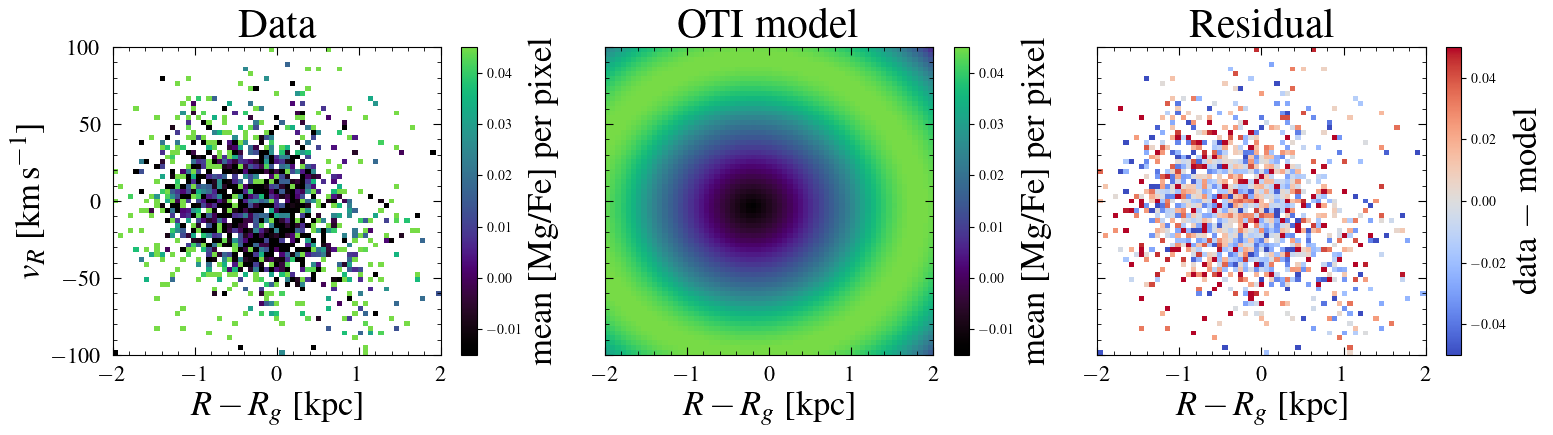

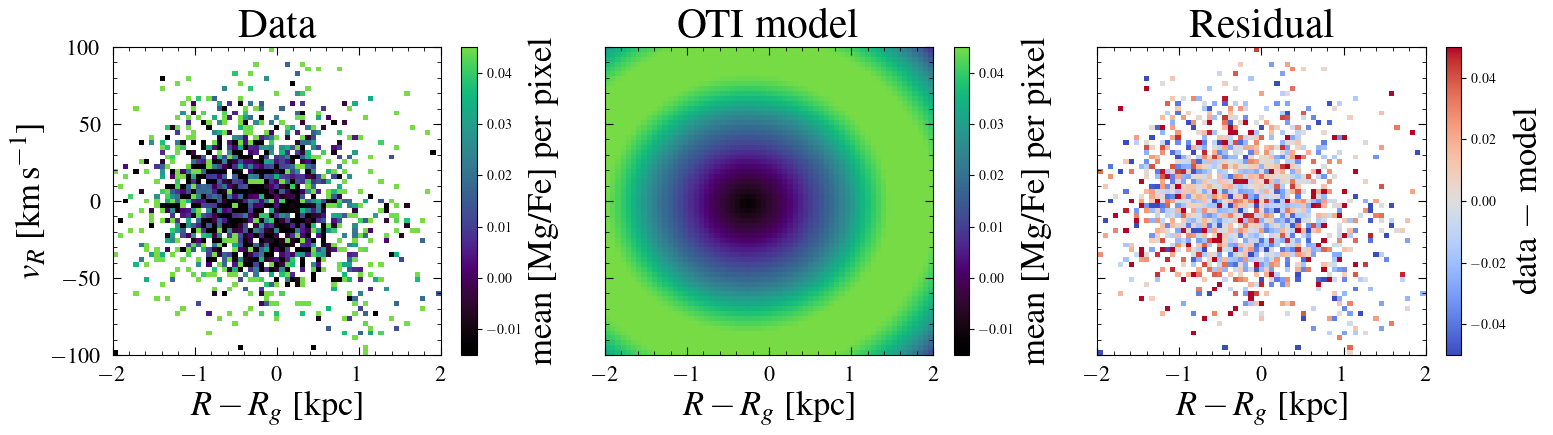

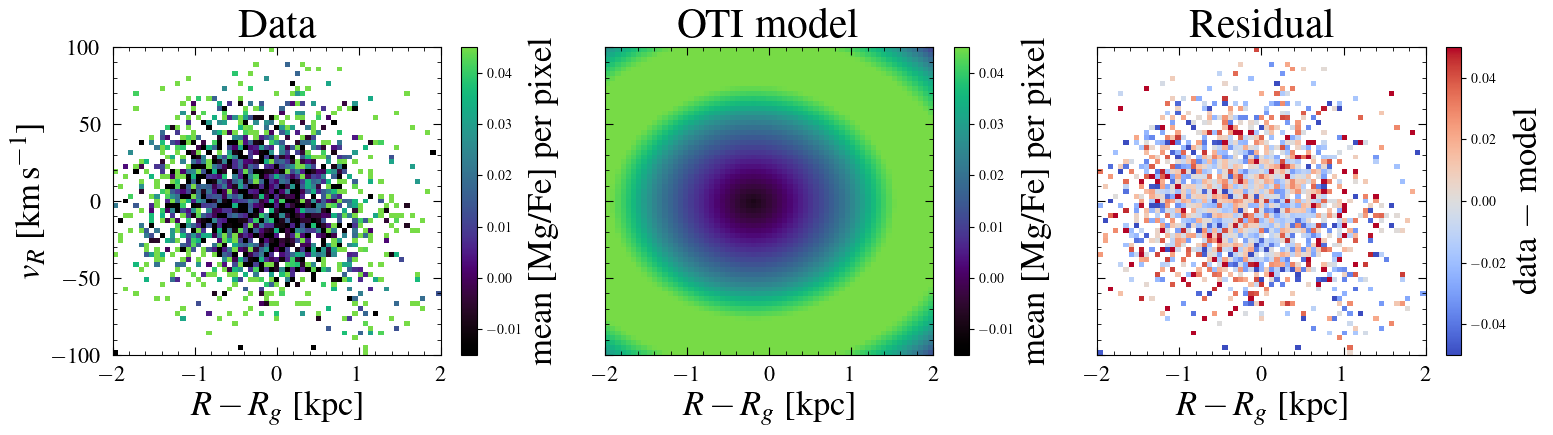

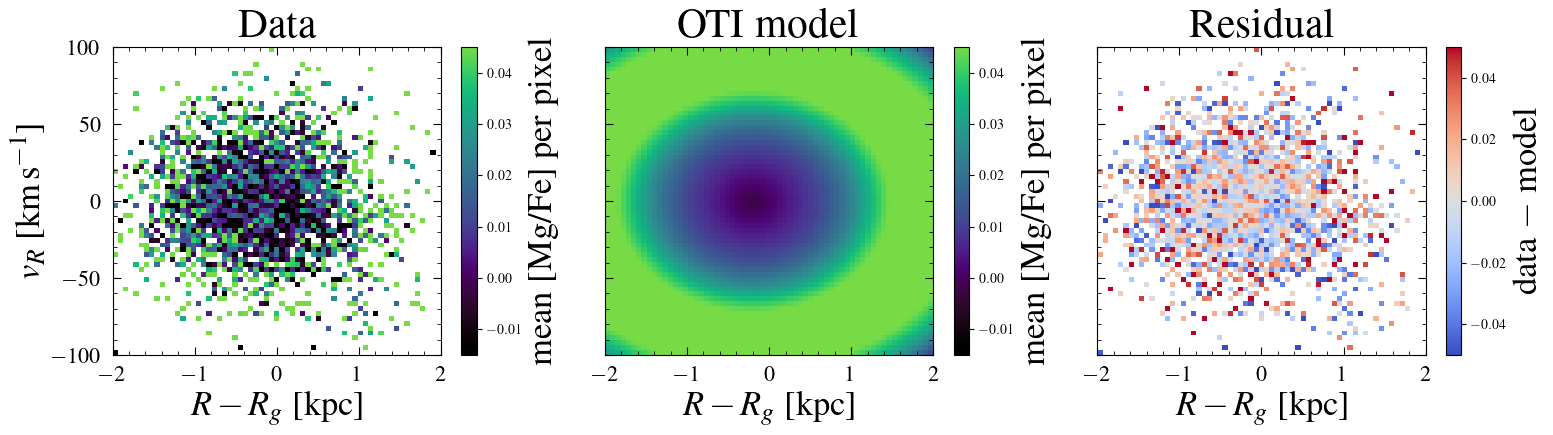

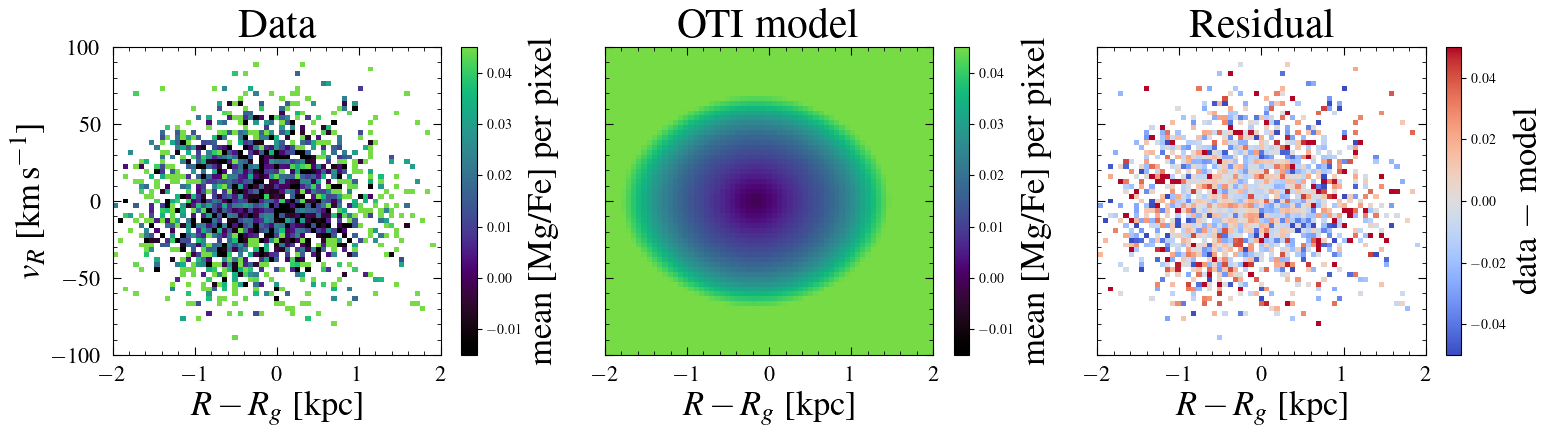

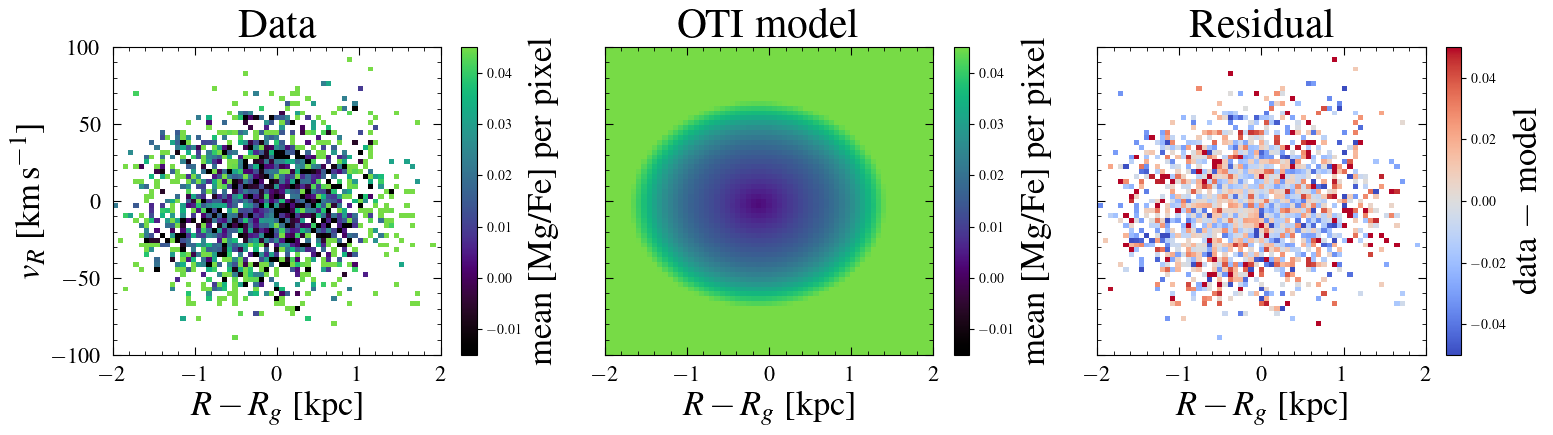

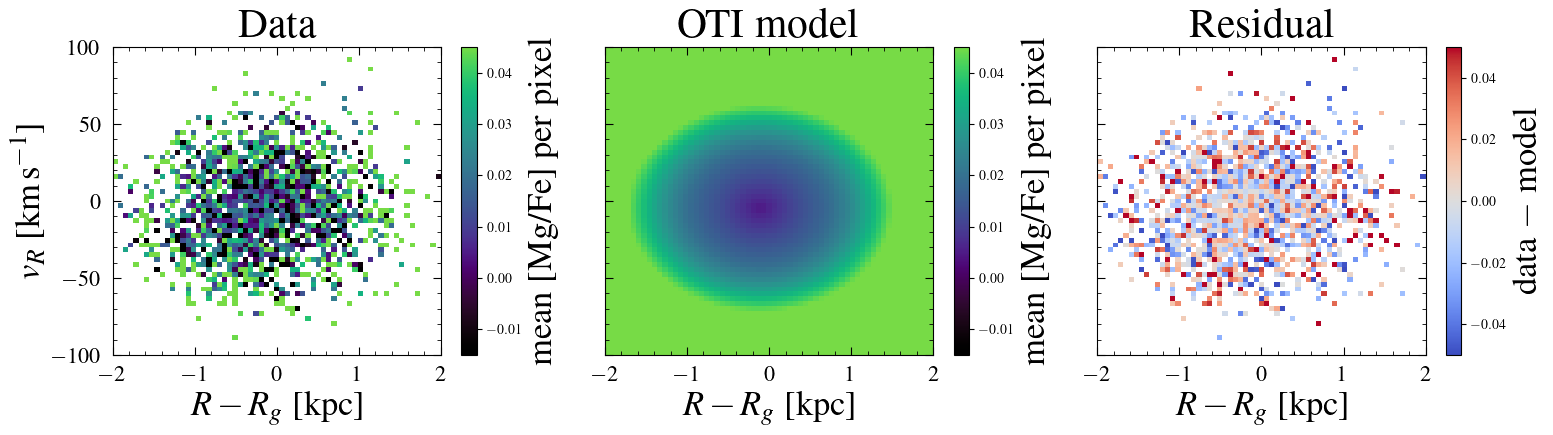

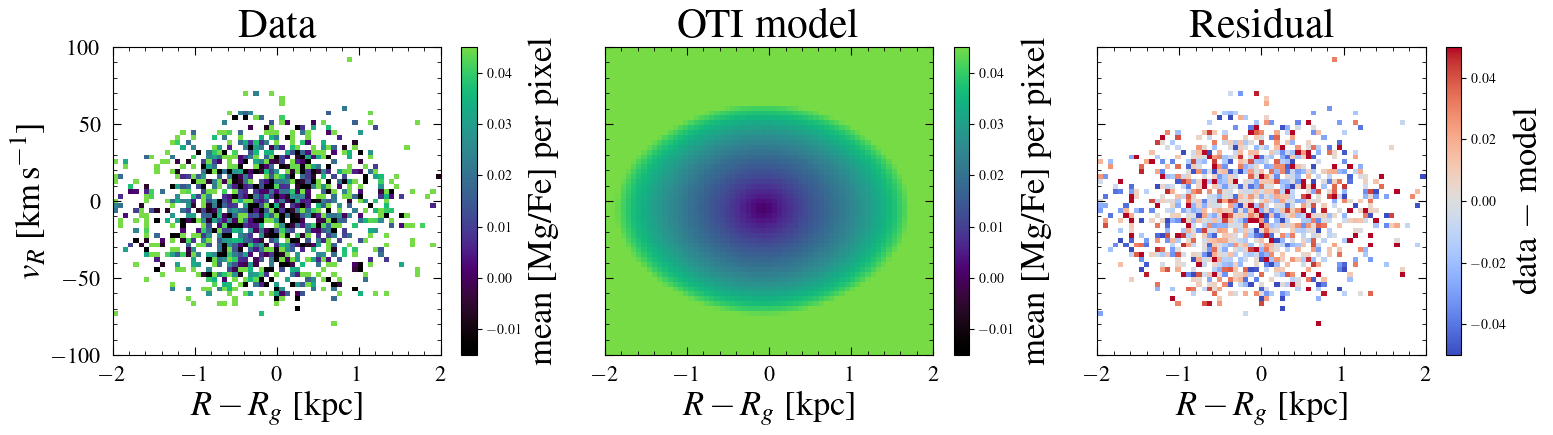

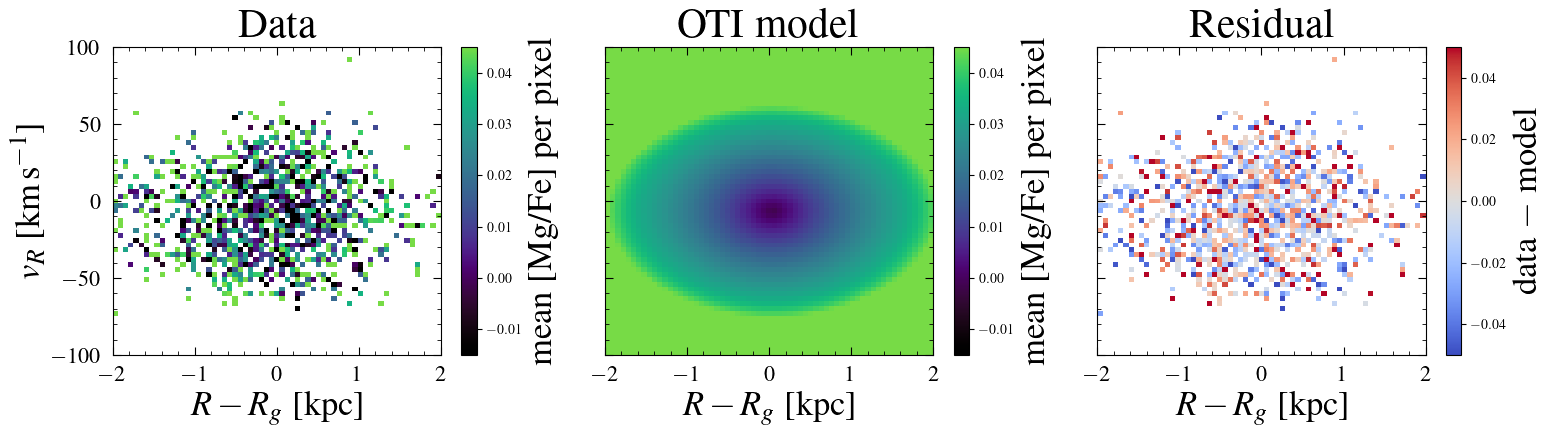

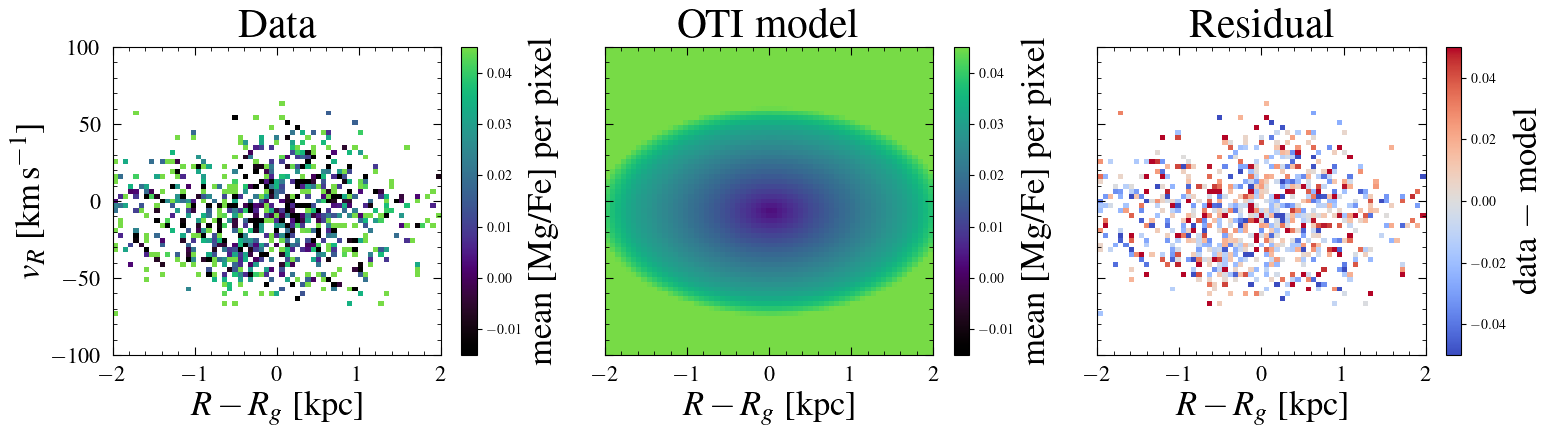

In [41]:
binsss = np.linspace(5,12,15)
bdata_clean_bins = []
res_bins_phi2 = []

for indx, i in enumerate(binsss[:-2]):
    mask_bin = (Rgal>i)&(Rgal<i+2)&wmask&(phi<0)&(phi_deg>-10)
    print(len(Rgal[mask_bin]))
    bdata_clean_bins_, res_bins_ = get_bins_plot(x_param, y_param, label, label_err, mask_bin)
    bdata_clean_bins.append(bdata_clean_bins_)
    res_bins_phi2.append(res_bins_)

In [42]:
rminusrg_bins = np.linspace(-1.9,1.9,19)
acc_R_phi2 = np.zeros((len(res_bins_phi2), len(rminusrg_bins)))

for indx, i in enumerate(res_bins_phi2):
    for jndx, j in enumerate(rminusrg_bins):
        freq = np.exp(i.params['ln_Omega0'])
        acc_ = -j * freq**2
        acc_R_phi2[indx, jndx] = acc_

acc_R_phi2 = acc_R_phi2*u.kpc/u.Myr**2
acc_R_phi2 = acc_R_phi2.to(u.km/(u.s * u.Myr))

In [43]:
dens_phi2 = np.zeros((len(res_bins_phi2), 10))
vc = 229.0 
dens_pos = np.zeros((len(res_bins_phi2)))

for indx, i in enumerate(res_bins_phi2):
    freq = np.exp(i.params['ln_Omega0'])
    for jndx, j in enumerate(rminusrg_bins[:10]):
        dens = (np.abs(j)*freq**2)/(4.*np.pi*G.value*Rs[indx])
        dens_phi2[indx, jndx] = dens

312
355
346
910
1259
1735
2298
2254
2350
2188
1864
1479
1051


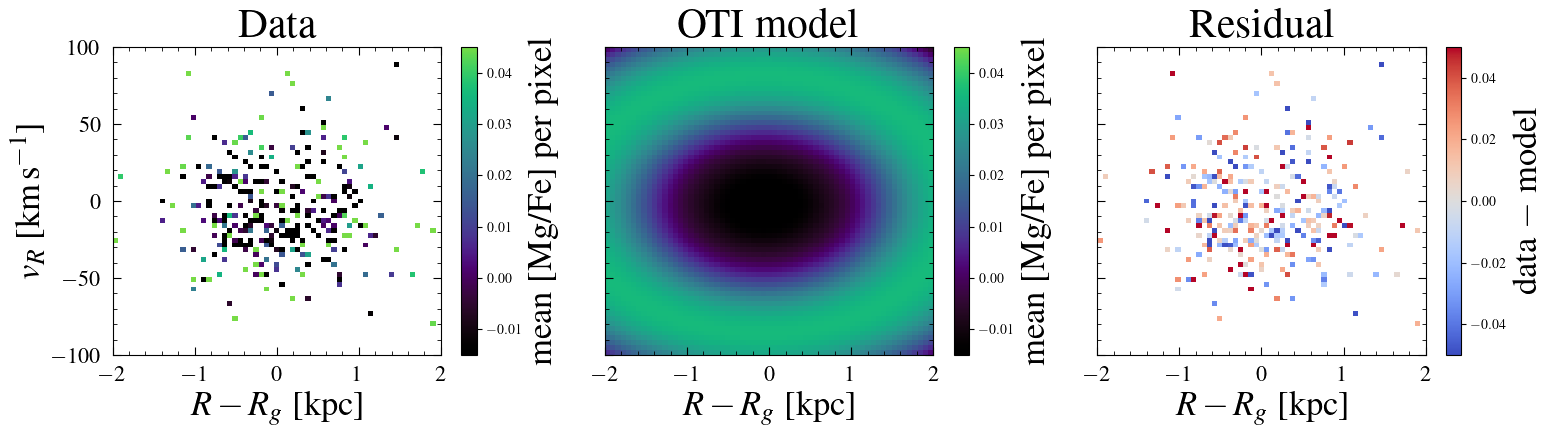

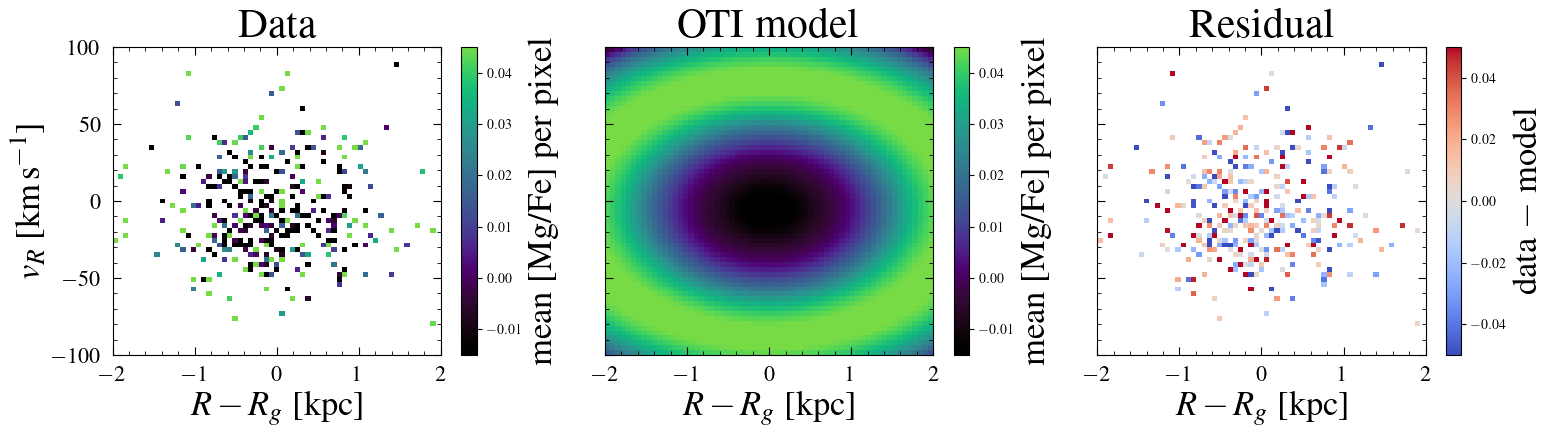

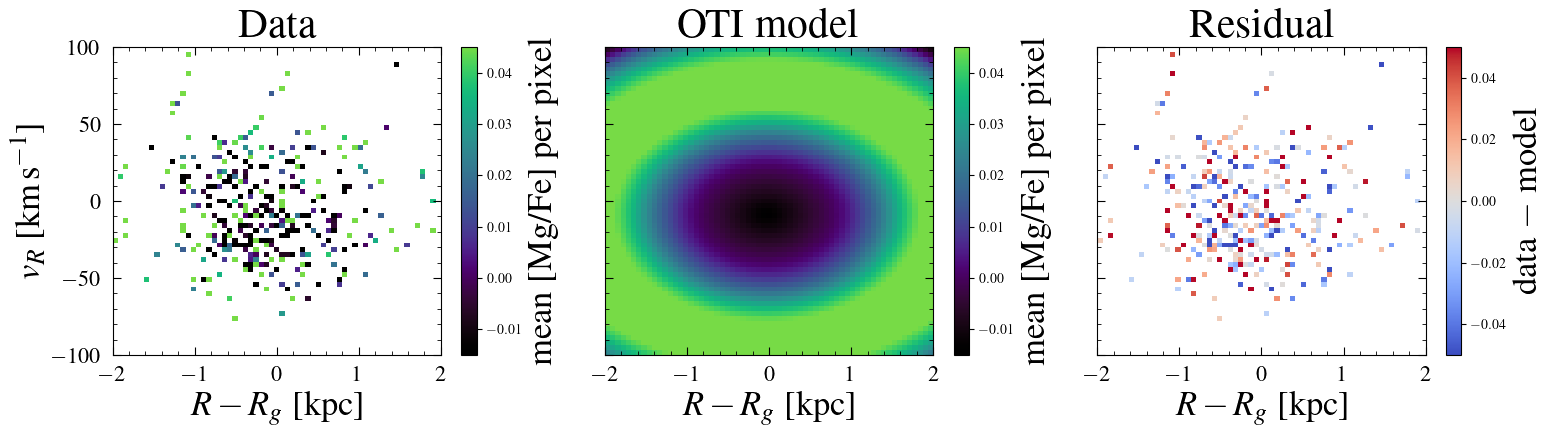

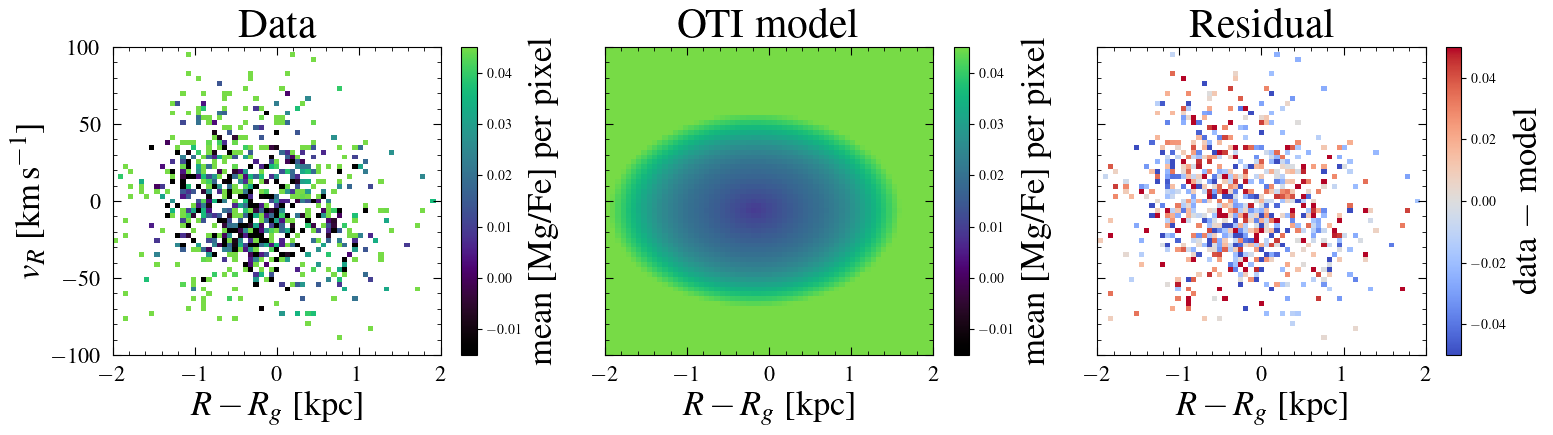

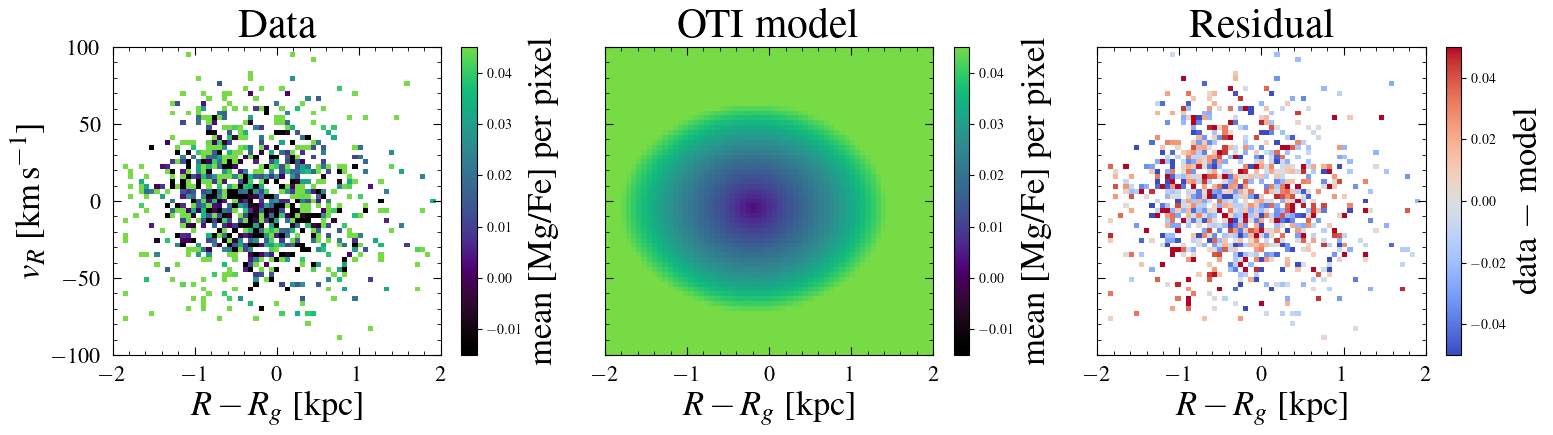

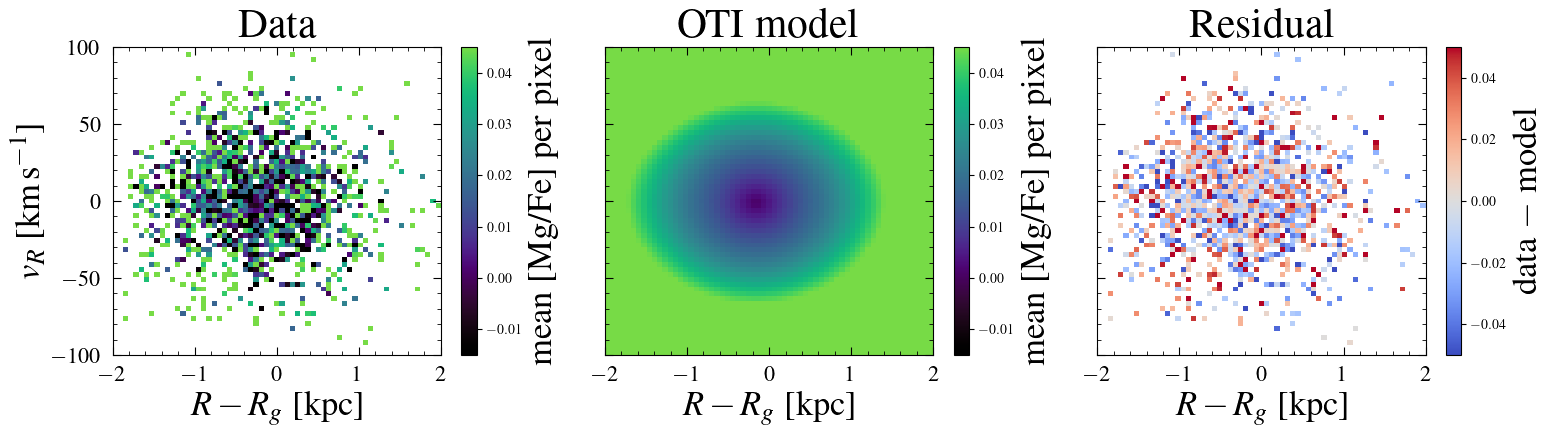

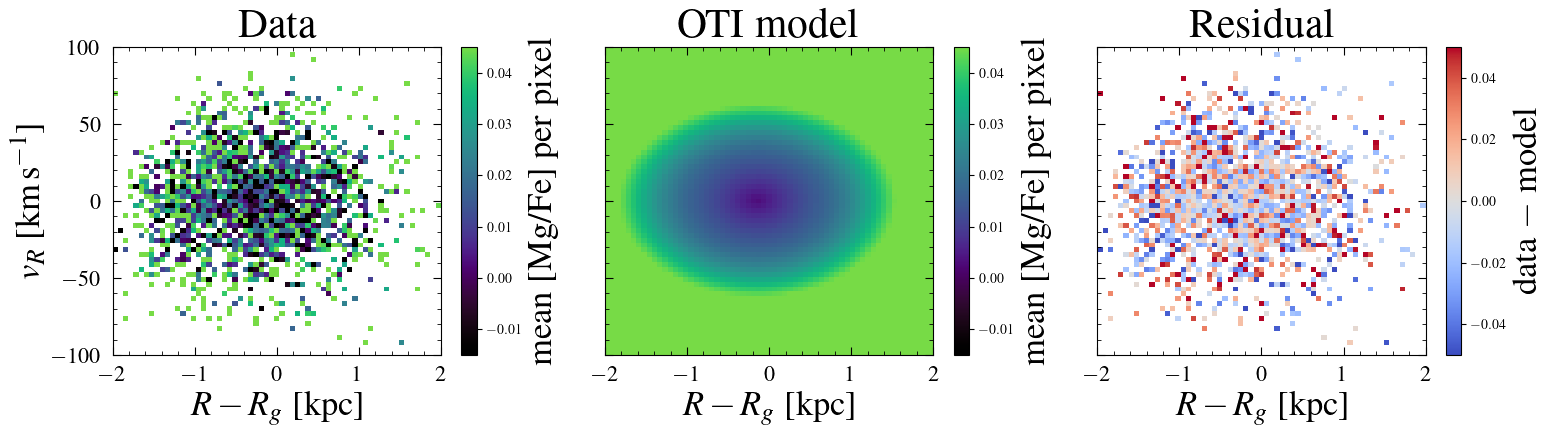

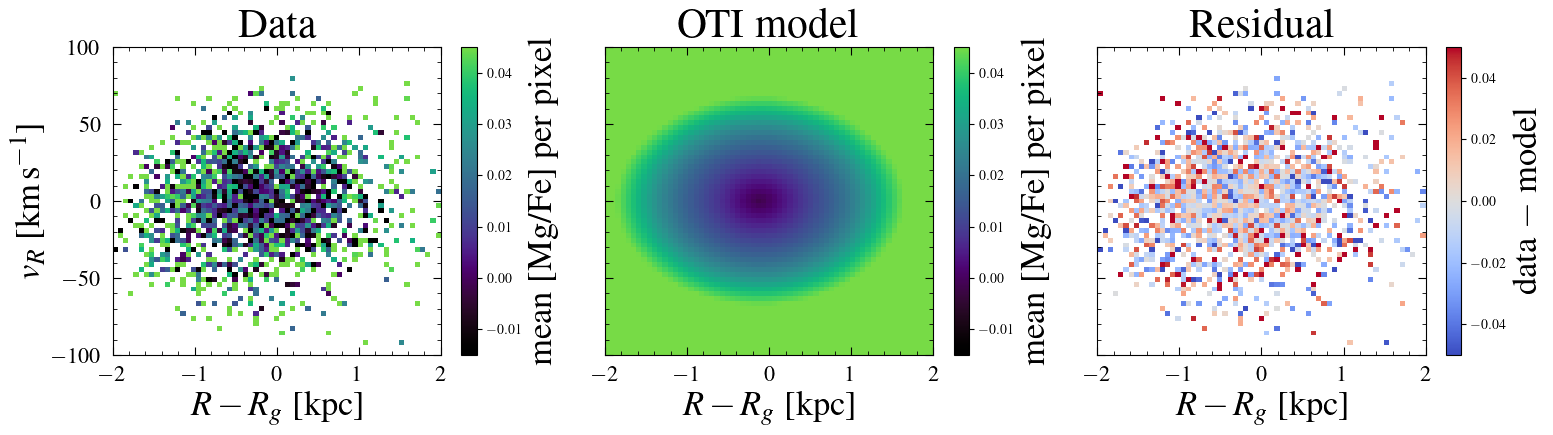

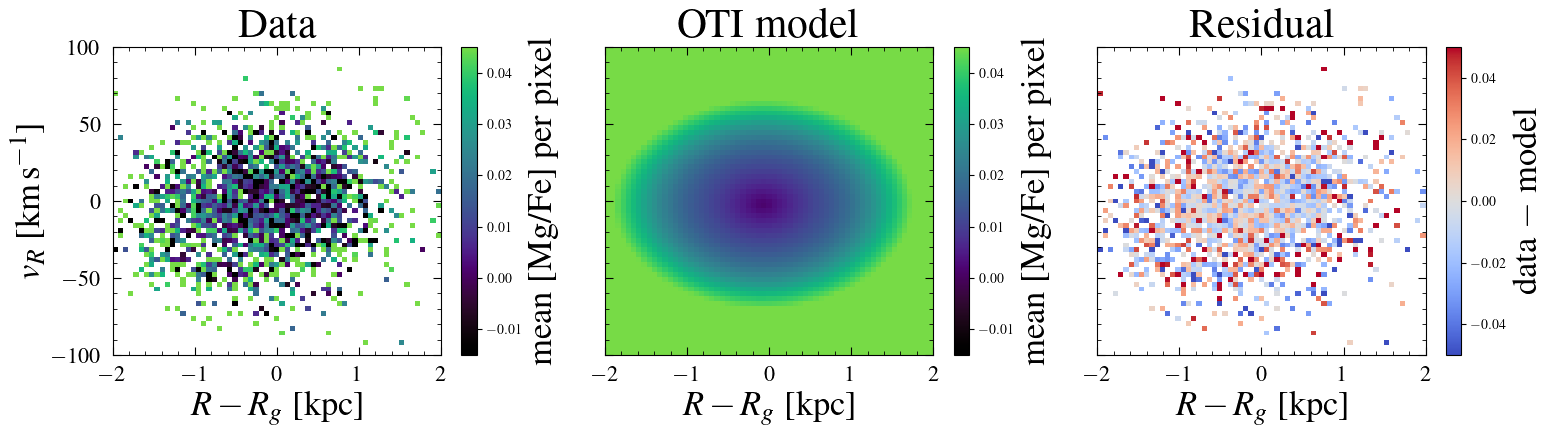

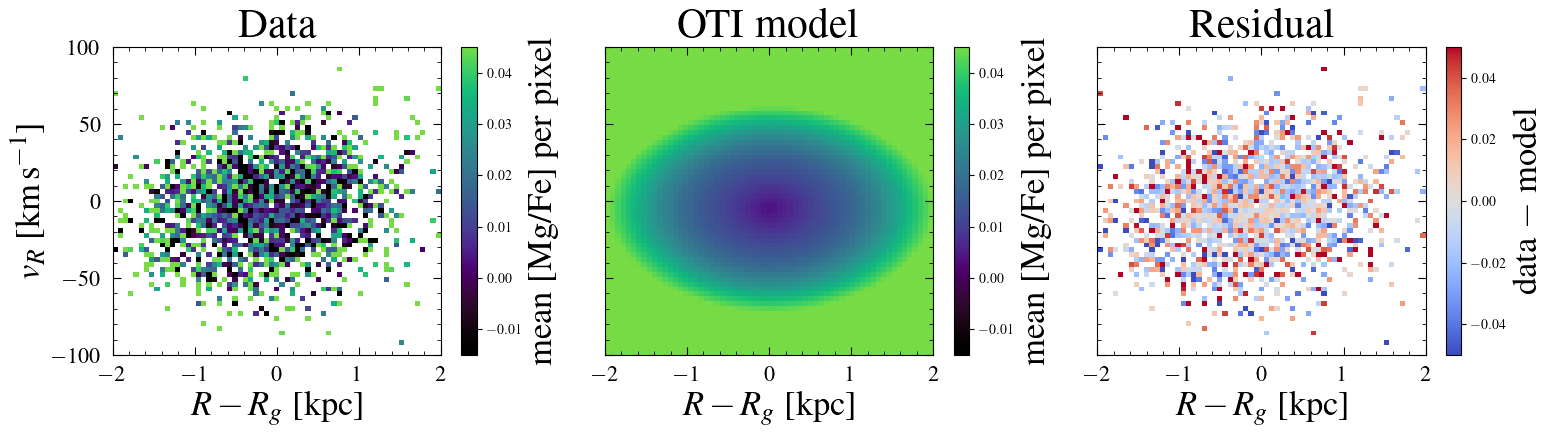

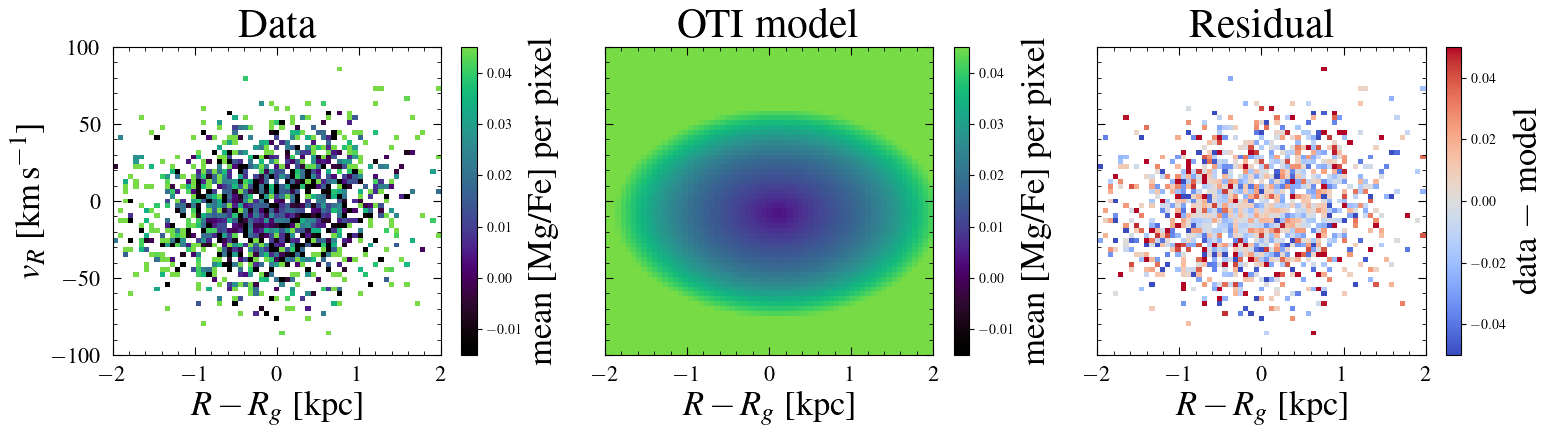

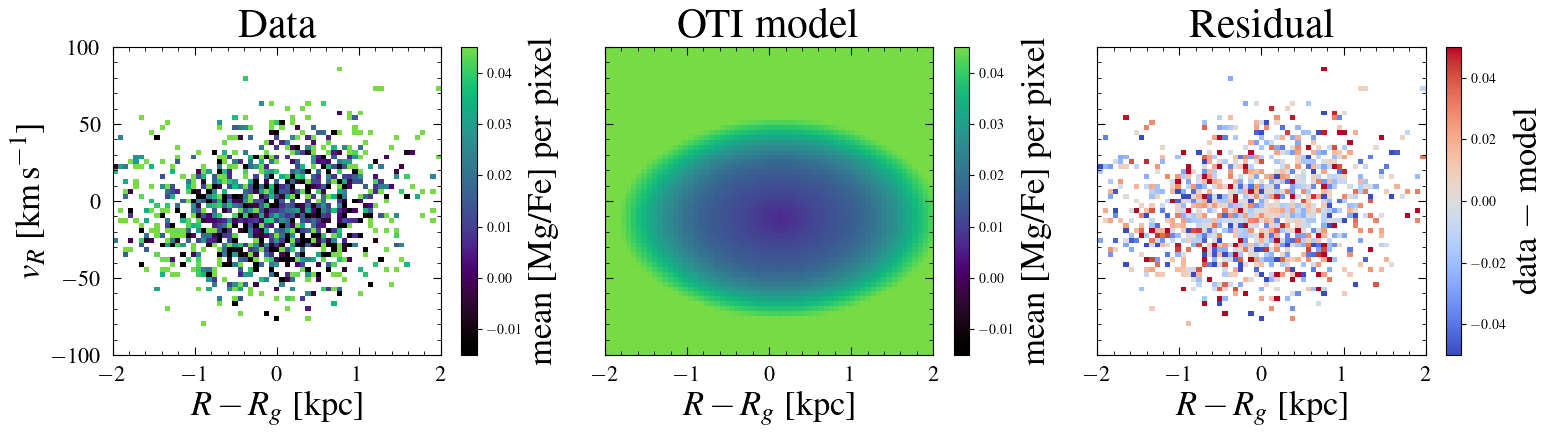

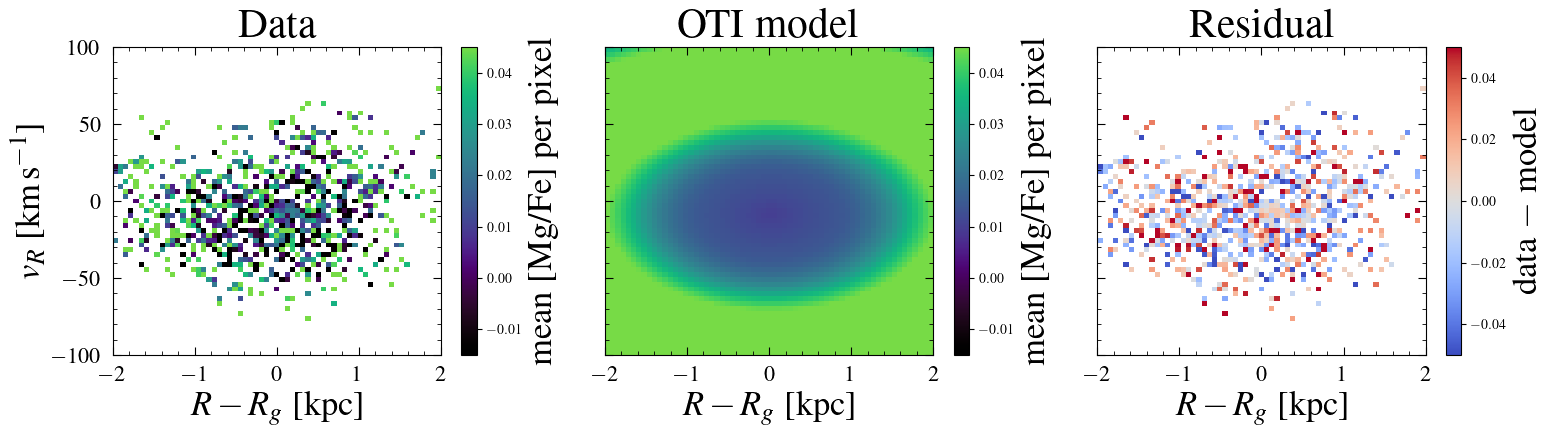

In [45]:
binsss = np.linspace(5,12,15)
bdata_clean_bins = []
res_bins_phi3 = []

for indx, i in enumerate(binsss[:-2]):
    mask_bin = (Rgal>i)&(Rgal<i+2)&wmask&(phi_deg>0)&(phi_deg<10)
    print(len(Rgal[mask_bin]))
    bdata_clean_bins_, res_bins_ = get_bins_plot(x_param, y_param, label, label_err, mask_bin)
    bdata_clean_bins.append(bdata_clean_bins_)
    res_bins_phi3.append(res_bins_)

In [46]:
rminusrg_bins = np.linspace(-1.9,1.9,19)
acc_R_phi3 = np.zeros((len(res_bins_phi3), len(rminusrg_bins)))

for indx, i in enumerate(res_bins_phi3):
    for jndx, j in enumerate(rminusrg_bins):
        freq = np.exp(i.params['ln_Omega0'])
        acc_ = -j * freq**2
        acc_R_phi3[indx, jndx] = acc_

acc_R_phi3 = acc_R_phi3*u.kpc/u.Myr**2
acc_R_phi3 = acc_R_phi3.to(u.km/(u.s * u.Myr))

In [47]:
dens_phi3 = np.zeros((len(res_bins_phi3), 10))
vc = 229.0 
dens_pos = np.zeros((len(res_bins_phi3)))

for indx, i in enumerate(res_bins_phi3):
    freq = np.exp(i.params['ln_Omega0'])
    for jndx, j in enumerate(rminusrg_bins[:10]):
        dens = (np.abs(j)*freq**2)/(4.*np.pi*G.value*Rs[indx])
        dens_phi3[indx, jndx] = dens

In [48]:
dens_phi1 = dens_phi1 * ((u.kg * u.s**2)/(u.Myr**2 * u.m**3))
dens_phi1 = dens_phi1.to(u.solMass/u.pc**3)
dens_phi2 = dens_phi2 * ((u.kg * u.s**2)/(u.Myr**2 * u.m**3))
dens_phi2 = dens_phi2.to(u.solMass/u.pc**3)
dens_phi3 = dens_phi3 * ((u.kg * u.s**2)/(u.Myr**2 * u.m**3))
dens_phi3 = dens_phi3.to(u.solMass/u.pc**3)
dens_phi1.shape, dens_phi2.shape, dens_phi3.shape

((13, 10), (13, 10), (13, 10))

In [49]:
dens_R_phi = np.concatenate((dens_phi1, dens_phi2))
dens_R_phi = np.concatenate((dens_R_phi, dens_phi3))
dens_R_phi

<Quantity [[0.01366117, 0.01214326, 0.01062535, 0.00910744, 0.00758954,
            0.00607163, 0.00455372, 0.00303581, 0.00151791, 0.        ],
           [0.0123708 , 0.01099626, 0.00962173, 0.0082472 , 0.00687266,
            0.00549813, 0.0041236 , 0.00274907, 0.00137453, 0.        ],
           [0.01055494, 0.00938217, 0.0082094 , 0.00703663, 0.00586386,
            0.00469109, 0.00351831, 0.00234554, 0.00117277, 0.        ],
           [0.00822161, 0.0073081 , 0.00639458, 0.00548107, 0.00456756,
            0.00365405, 0.00274054, 0.00182702, 0.00091351, 0.        ],
           [0.00653707, 0.00581073, 0.00508439, 0.00435805, 0.0036317 ,
            0.00290536, 0.00217902, 0.00145268, 0.00072634, 0.        ],
           [0.00628591, 0.00558747, 0.00488904, 0.00419061, 0.00349217,
            0.00279374, 0.0020953 , 0.00139687, 0.00069843, 0.        ],
           [0.00587298, 0.00522043, 0.00456787, 0.00391532, 0.00326277,
            0.00261021, 0.00195766, 0.00130511, 0.00065255

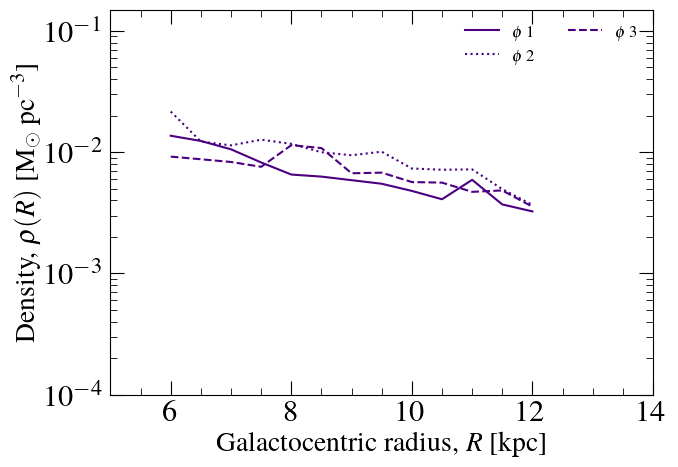

In [63]:
plt.figure(figsize=(7,5))
# plt.plot(Rs+1, dens_pos, lw=2, ls='dotted', color='k')
# for indx, i in enumerate(dens_phi1.T):
#     plt.plot(Rs[:-2]+1, i, label='$|R-R_g|$:'+str(np.abs(round(rminusrg_bins[indx],2))), color=colores[indx])
#     plt.plot(Rs[:-2]+1, dens_phi2.T[indx], color=colores[indx], ls='dotted')
#     plt.plot(Rs[:-2]+1, dens_phi3.T[indx], color=colores[indx], ls='dashed')
o = 0
plt.plot(Rs[:-2]+1, dens_phi1.T[o], color=colores[o], label='$\phi$ 1')
plt.plot(Rs[:-2]+1, dens_phi2.T[o], color=colores[o], ls='dotted', label='$\phi$ 2')
plt.plot(Rs[:-2]+1, dens_phi3.T[o], color=colores[o], ls='dashed', label='$\phi$ 3')
plt.xlim(5,14)
plt.ylim(1e-4,0.15)
plt.yscale('log')
# plt.errorbar(8.275, 0.081, yerr = 0.0015, color='r', capsize=5)
plt.xlabel('Galactocentric radius, $R$ [kpc]', fontsize=20)
plt.ylabel(r'Density, $\rho(R)$ [M$_{\odot}$ pc$^{-3}$]', fontsize=20)
plt.legend(loc='upper right', frameon=False, ncols=2, fontsize=12)
plt.tick_params(labelsize=16,direction='in',top=True,right=True,length=6)
plt.tick_params(which='major',labelsize=22,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=5, direction='in',top=True,right=True)
plt.minorticks_on()

# plt.savefig('/Users/dhortad/Projects/Torusimaging-radial/plots/dens-z0point2.pdf',dpi=250, bbox_inches = 'tight')


In [55]:
dens_phi1.T.shape

(10, 13)

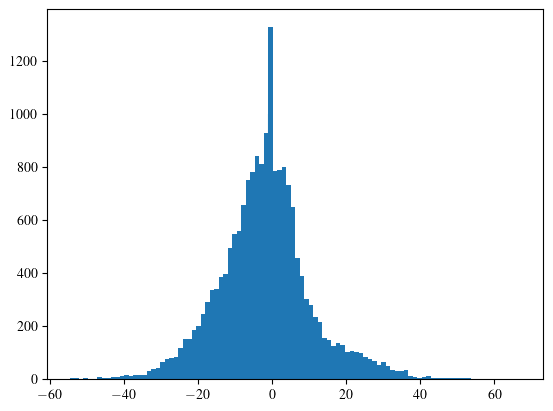

In [632]:
plt.hist(p[wmask],100);
plt.vlines(-np.pi/4,0,1e3)

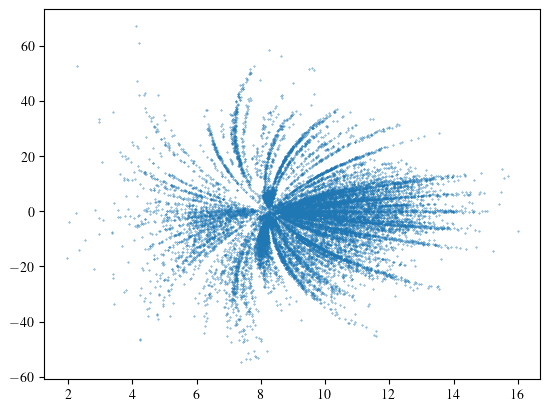

In [634]:
plt.scatter(Rgal[wmask],p[wmask],s=0.1)

Text(0, 0.5, '$v_R$ [$\\mathrm{km\\,s^{-1}}$]')

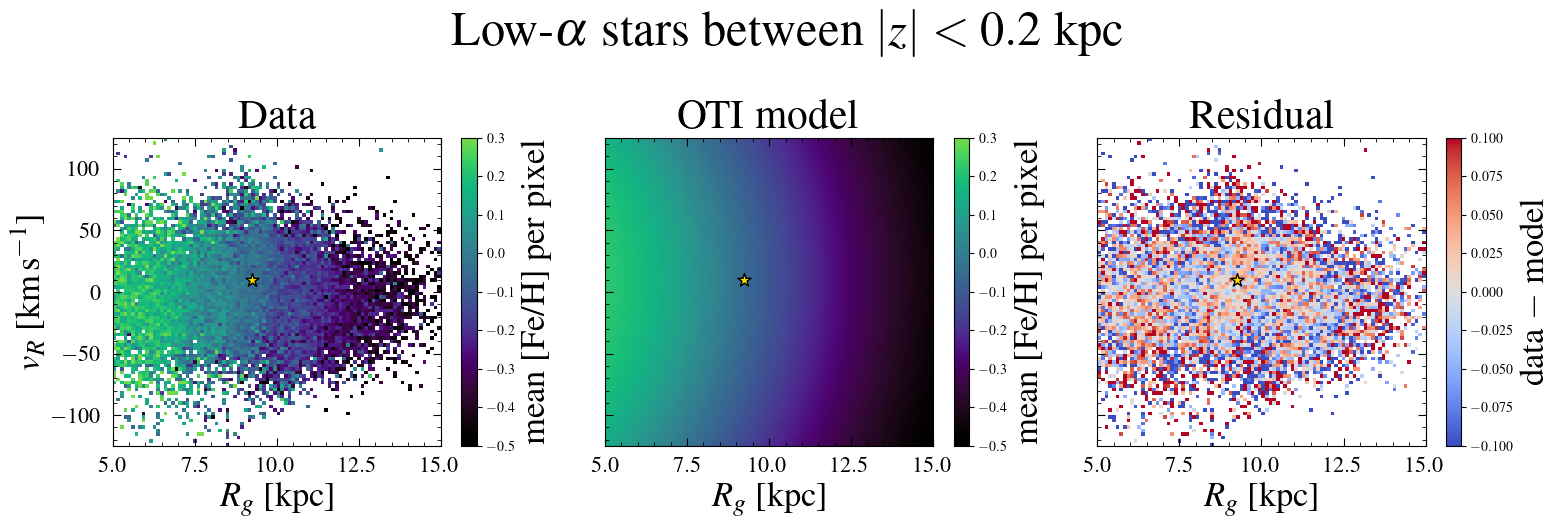

In [16]:
# visualise the data

fig, axes = plt.subplots(1, 3, figsize=(18, 4), sharex=True, sharey=True)
fig.suptitle(r'Low-$\alpha$ stars between $|z|<0.2$ kpc', fontsize=35, y=1.2)

ax = axes[0]
ax.set_title('Data', fontsize=30)
cs = ax.pcolormesh(
    bdata["pos"].to_value(u.kpc),
    bdata["vel"].to_value(u.km / u.s),
    bdata["label"],
    vmin=-0.5,
    vmax=0.3,
    cmap=cm.lavender,
)
cb = fig.colorbar(cs, ax=ax)
cb.set_label("mean [Fe/H] per pixel", fontsize=25)
ax.scatter(9.25, 10, marker='*', color='gold', s=100, edgecolors='k')
ax.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=6, pad=8)
ax.tick_params(which='minor', length=3, direction='in',top=True,right=True, pad=8)
ax.minorticks_on()
ax.set_ylim(-125,125)
ax.set_xlim(5,15)

ax = axes[1]
ax.set_title('OTI model', fontsize=30)
model_H = model._get_label(pos=bdata["pos"], vel=bdata["vel"], params=res.params)
cs = ax.pcolormesh(
    bdata["pos"].to_value(u.kpc),
    bdata["vel"].to_value(u.km / u.s),
    model_H,
    vmin=-0.5,
    vmax=0.3,
    cmap=cm.lavender
)
ax.scatter(9.25, 10, marker='*', color='gold', s=100, edgecolors='k')
ax.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=6, pad=8)
ax.tick_params(which='minor', length=3, direction='in',top=True,right=True, pad=8)
ax.minorticks_on()
cb = fig.colorbar(cs, ax=ax)
cb.set_label("mean [Fe/H] per pixel", fontsize=25)
ax.set_ylim(-125,125)
ax.set_xlim(5,15)

ax = axes[2]
ax.set_title('Residual', fontsize=30)
cs = ax.pcolormesh(
    bdata["pos"].to_value(u.kpc),
    bdata["vel"].to_value(u.km / u.s),
    bdata["label"] - model_H,
    vmin=-0.1,
    vmax=0.1,
    cmap='coolwarm'
)

cb = fig.colorbar(cs, ax=ax)
cb.set_label("data $-$ model", fontsize=25)
ax.set_ylim(-125,125)
ax.set_xlim(5,15)
ax.scatter(9.25, 10, marker='*', color='gold', s=100, edgecolors='k')
ax.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=6, pad=8)
ax.tick_params(which='minor', length=3, direction='in',top=True,right=True, pad=8)
ax.minorticks_on()

for ax in axes:
    ax.set_xlabel(f"$R_g$ [{u.kpc:latex_inline}]", fontsize=25)
axes[0].set_ylabel(f"$v_R$ [{u.km/u.s:latex_inline}]", fontsize=25)

Now with $R-R_g$

In [31]:
# create the bins to model the data in R-vR
nbins = 91
bins = {
    "pos": np.linspace(-1, 1, nbins)*u.kpc,
    "vel": np.linspace(-125, 125, nbins)*u.km/u.s,
}

In [32]:
x_param = (Rgal-Rg) * u.kpc
y_param = vR * u.km/u.s
label = data['FE_H']
label_err = data['FE_H_ERR']

bdata = oti.data.get_binned_label(
    pos=x_param[wmask4].astype(np.float32),
    vel=y_param[wmask4].astype(np.float32),
    label=label[wmask4].astype(np.float32),
    label_err=label_err[wmask4].astype(np.float32),
    bins=bins,
    units=galactic,
    s_N_thresh=2,
)

bdata_clean = dict(
    pos=bdata["pos"],
    vel=bdata["vel"],
    label=bdata["label"],
    label_err=bdata["label_err"],
)
bdata_mask = (
    np.isfinite(bdata["label"])
    & np.isfinite(bdata["label_err"])
    & (bdata["label_err"] > 0)
)
bdata_clean = {k: v[bdata_mask] for k, v in bdata_clean.items()}

In [33]:
res = model.optimize(init_params, objective="gaussian", bounds=bounds, **bdata_clean)
res.state.success, res.state.iter_num

(True, 136)

Text(0, 0.5, '$v_R$ [$\\mathrm{km\\,s^{-1}}$]')

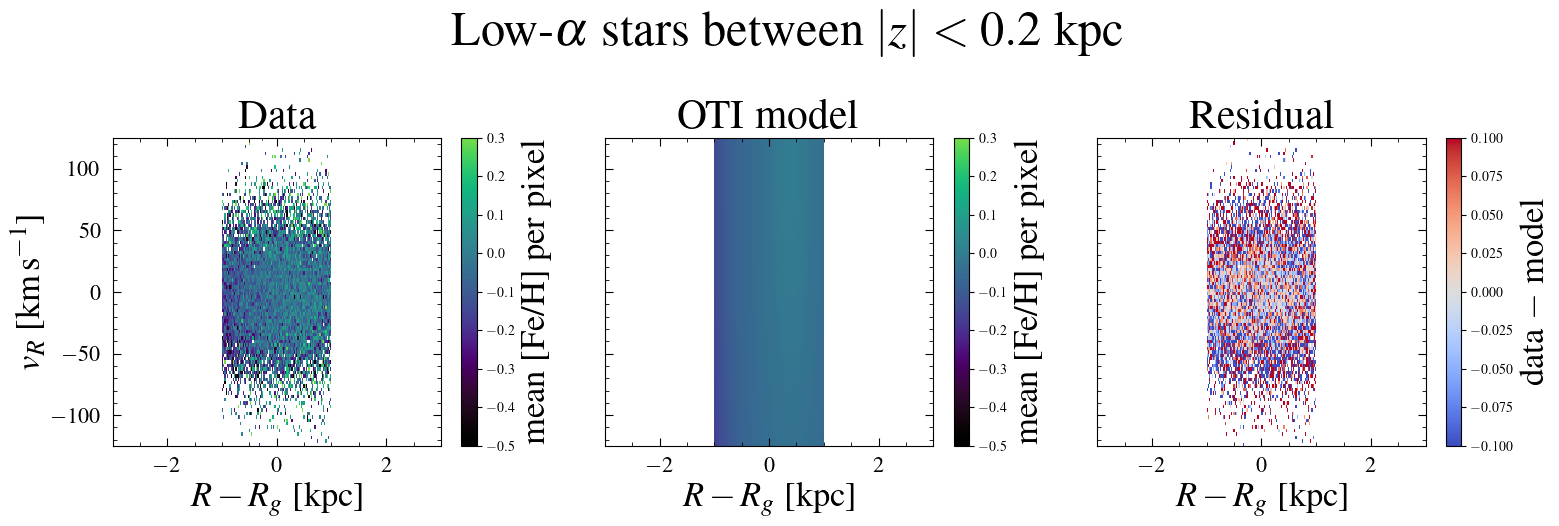

In [34]:
# visualise the data

fig, axes = plt.subplots(1, 3, figsize=(18, 4), sharex=True, sharey=True)
fig.suptitle(r'Low-$\alpha$ stars between $|z|<0.2$ kpc', fontsize=35, y=1.2)

ax = axes[0]
ax.set_title('Data', fontsize=30)
cs = ax.pcolormesh(
    bdata["pos"].to_value(u.kpc),
    bdata["vel"].to_value(u.km / u.s),
    bdata["label"],
    vmin=-0.5,
    vmax=0.3,
    cmap=cm.lavender,
)
cb = fig.colorbar(cs, ax=ax)
cb.set_label("mean [Fe/H] per pixel", fontsize=25)
# ax.scatter(9.25, 10, marker='*', color='gold', s=100, edgecolors='k')
ax.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=6, pad=8)
ax.tick_params(which='minor', length=3, direction='in',top=True,right=True, pad=8)
ax.minorticks_on()
ax.set_ylim(-125,125)
ax.set_xlim(-3,3)

ax = axes[1]
ax.set_title('OTI model', fontsize=30)
model_H = model._get_label(pos=bdata["pos"], vel=bdata["vel"], params=res.params)
cs = ax.pcolormesh(
    bdata["pos"].to_value(u.kpc),
    bdata["vel"].to_value(u.km / u.s),
    model_H,
    vmin=-0.5,
    vmax=0.3,
    cmap=cm.lavender
)
# ax.scatter(9.25, 10, marker='*', color='gold', s=100, edgecolors='k')
ax.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=6, pad=8)
ax.tick_params(which='minor', length=3, direction='in',top=True,right=True, pad=8)
ax.minorticks_on()
cb = fig.colorbar(cs, ax=ax)
cb.set_label("mean [Fe/H] per pixel", fontsize=25)
ax.set_ylim(-125,125)
ax.set_xlim(-3,3)

ax = axes[2]
ax.set_title('Residual', fontsize=30)
cs = ax.pcolormesh(
    bdata["pos"].to_value(u.kpc),
    bdata["vel"].to_value(u.km / u.s),
    bdata["label"] - model_H,
    vmin=-0.1,
    vmax=0.1,
    cmap='coolwarm'
)

cb = fig.colorbar(cs, ax=ax)
cb.set_label("data $-$ model", fontsize=25)
ax.set_ylim(-125,125)
ax.set_xlim(-3,3)
# ax.scatter(9.25, 10, marker='*', color='gold', s=100, edgecolors='k')
ax.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=6, pad=8)
ax.tick_params(which='minor', length=3, direction='in',top=True,right=True, pad=8)
ax.minorticks_on()

for ax in axes:
    ax.set_xlabel(f"$R - R_g$ [{u.kpc:latex_inline}]", fontsize=25)
axes[0].set_ylabel(f"$v_R$ [{u.km/u.s:latex_inline}]", fontsize=25)

# Now bin by age

In [22]:
# create the bins to model the data in R-vR
nbins = 91
bins = {
    "pos": np.linspace(5, 15, nbins)*u.kpc,
    "vel": np.linspace(-125, 125, nbins)*u.km/u.s,
}

In [23]:
x_param = Rgal * u.kpc
y_param = vR * u.km/u.s
label = data['FE_H']
label_err = data['FE_H_ERR']

bdata = oti.data.get_binned_label(
    pos=x_param[wmask].astype(np.float32),
    vel=y_param[wmask].astype(np.float32),
    label=label[wmask].astype(np.float32),
    label_err=label_err[wmask].astype(np.float32),
    bins=bins,
    units=galactic,
    s_N_thresh=2,
)

bdata_clean = dict(
    pos=bdata["pos"],
    vel=bdata["vel"],
    label=bdata["label"],
    label_err=bdata["label_err"],
)
bdata_mask = (
    np.isfinite(bdata["label"])
    & np.isfinite(bdata["label_err"])
    & (bdata["label_err"] > 0)
)
bdata_clean = {k: v[bdata_mask] for k, v in bdata_clean.items()}

In [24]:
res = model.optimize(init_params, objective="gaussian", bounds=bounds, **bdata_clean)
res.state.success, res.state.iter_num

(True, 79)

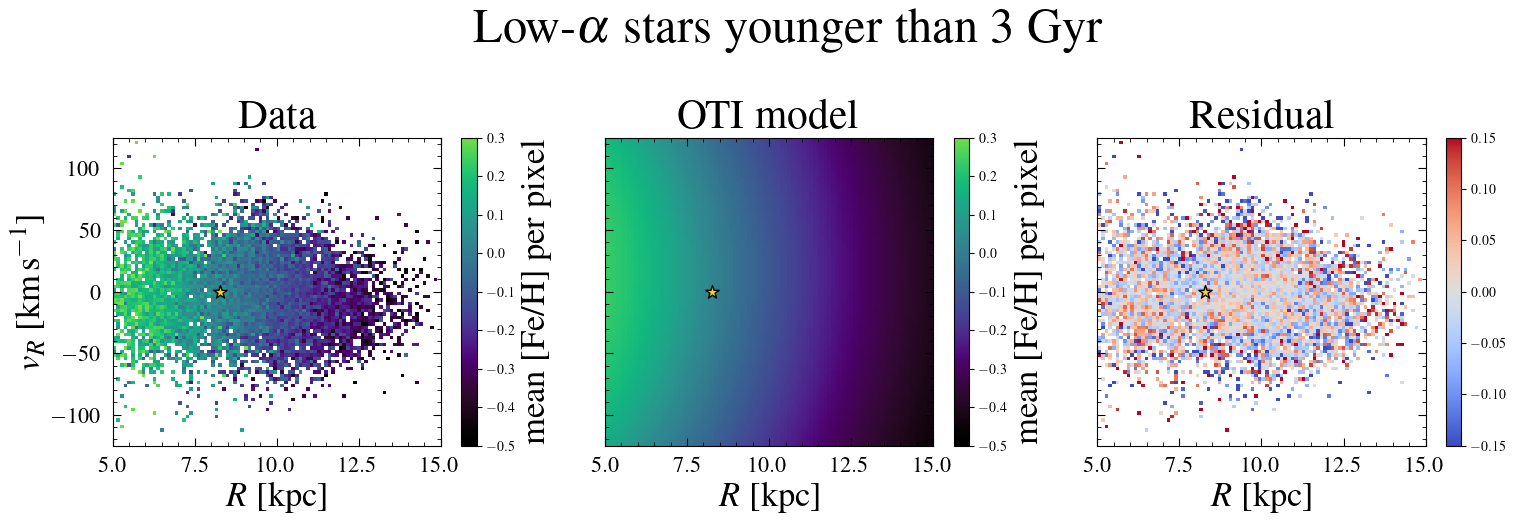

In [26]:
# visualise the data

fig, axes = plt.subplots(1, 3, figsize=(18, 4), sharex=True, sharey=True)
fig.suptitle(r'Low-$\alpha$ stars younger than 3 Gyr', fontsize=35, y=1.2)

ax = axes[0]
ax.set_title('Data', fontsize=30)
cs = ax.pcolormesh(
    bdata["pos"].to_value(u.kpc),
    bdata["vel"].to_value(u.km / u.s),
    bdata["label"],
    vmin=-0.5,
    vmax=0.3,
    cmap=cm.lavender,
)
cb = fig.colorbar(cs, ax=ax)
cb.set_label("mean [Fe/H] per pixel", fontsize=25)
ax.scatter(8.275, 0, marker='*', color='gold', s=100, edgecolors='k')
ax.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=6, pad=8)
ax.tick_params(which='minor', length=3, direction='in',top=True,right=True, pad=8)
ax.minorticks_on()
# ax.set_ylim(-100,100)
ax.set_xlim(0,16)

ax = axes[1]
ax.set_title('OTI model', fontsize=30)
model_H = model._get_label(pos=bdata["pos"], vel=bdata["vel"], params=res.params)
cs = ax.pcolormesh(
    bdata["pos"].to_value(u.kpc),
    bdata["vel"].to_value(u.km / u.s),
    model_H,
    vmin=-0.5,
    vmax=0.3,
    cmap=cm.lavender
)
ax.scatter(8.275, 0, marker='*', color='gold', s=100, edgecolors='k')
ax.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=6, pad=8)
ax.tick_params(which='minor', length=3, direction='in',top=True,right=True, pad=8)
ax.minorticks_on()
cb = fig.colorbar(cs, ax=ax)
cb.set_label("mean [Fe/H] per pixel", fontsize=25)
# ax.set_ylim(-100,100)
ax.set_xlim(5,15)

ax = axes[2]
ax.set_title('Residual', fontsize=30)
cs = ax.pcolormesh(
    bdata["pos"].to_value(u.kpc),
    bdata["vel"].to_value(u.km / u.s),
    bdata["label"] - model_H,
    vmin=-0.15,
    vmax=0.15,
    cmap='coolwarm'
)

cb = fig.colorbar(cs, ax=ax)
# cb.set_label("Residual")
# ax.set_ylim(-100,100)
ax.scatter(8.275, 0, marker='*', color='gold', s=100, edgecolors='k')
ax.set_xlim(5,15)
ax.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=6, pad=8)
ax.tick_params(which='minor', length=3, direction='in',top=True,right=True, pad=8)
ax.minorticks_on()

for ax in axes:
    ax.set_xlabel(f"$R$ [{u.kpc:latex_inline}]", fontsize=25)
axes[0].set_ylabel(f"$v_R$ [{u.km/u.s:latex_inline}]", fontsize=25)

plt.savefig('/Users/dhortad/Projects/Torusimaging-radial/plots/data-model-res-Rgal-young',dpi=250, bbox_inches = 'tight')


Repeat the exercise with $R_g$

For young stars

In [27]:
x_param = Rg * u.kpc
y_param = vR * u.km/u.s
label = data['FE_H']
label_err = data['FE_H_ERR']

bdata = oti.data.get_binned_label(
    pos=x_param[wmask].astype(np.float32),
    vel=y_param[wmask].astype(np.float32),
    label=label[wmask].astype(np.float32),
    label_err=label_err[wmask].astype(np.float32),
    bins=bins,
    units=galactic,
    s_N_thresh=2,
)

bdata_clean = dict(
    pos=bdata["pos"],
    vel=bdata["vel"],
    label=bdata["label"],
    label_err=bdata["label_err"],
)
bdata_mask = (
    np.isfinite(bdata["label"])
    & np.isfinite(bdata["label_err"])
    & (bdata["label_err"] > 0)
)
bdata_clean = {k: v[bdata_mask] for k, v in bdata_clean.items()}

In [28]:
res = model.optimize(init_params, objective="gaussian", bounds=bounds, **bdata_clean)
res.state.success, res.state.iter_num

(True, 535)

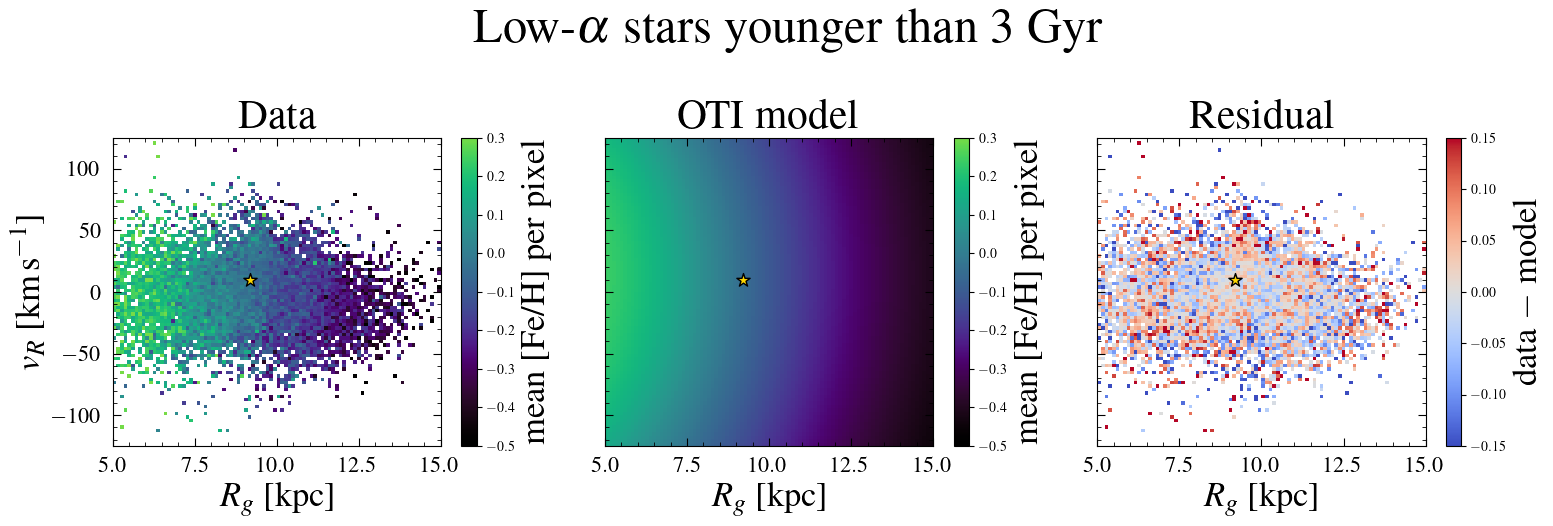

In [29]:
# visualise the data

fig, axes = plt.subplots(1, 3, figsize=(18, 4), sharex=True, sharey=True)
fig.suptitle(r'Low-$\alpha$ stars younger than 3 Gyr', fontsize=35, y=1.2)

ax = axes[0]
ax.set_title('Data', fontsize=30)
cs = ax.pcolormesh(
    bdata["pos"].to_value(u.kpc),
    bdata["vel"].to_value(u.km / u.s),
    bdata["label"],
    vmin=-0.5,
    vmax=0.3,
    cmap=cm.lavender,
)
cb = fig.colorbar(cs, ax=ax)
cb.set_label("mean [Fe/H] per pixel", fontsize=25)
ax.scatter(9.2, 10, marker='*', color='gold', s=100, edgecolors='k')
ax.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=6, pad=8)
ax.tick_params(which='minor', length=3, direction='in',top=True,right=True, pad=8)
ax.minorticks_on()
# ax.set_ylim(-100,100)
ax.set_xlim(0,16)

ax = axes[1]
ax.set_title('OTI model', fontsize=30)
model_H = model._get_label(pos=bdata["pos"], vel=bdata["vel"], params=res.params)
cs = ax.pcolormesh(
    bdata["pos"].to_value(u.kpc),
    bdata["vel"].to_value(u.km / u.s),
    model_H,
    vmin=-0.5,
    vmax=0.3,
    cmap=cm.lavender
)
ax.scatter(9.2, 10, marker='*', color='gold', s=100, edgecolors='k')
ax.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=6, pad=8)
ax.tick_params(which='minor', length=3, direction='in',top=True,right=True, pad=8)
ax.minorticks_on()
cb = fig.colorbar(cs, ax=ax)
cb.set_label("mean [Fe/H] per pixel", fontsize=25)
# ax.set_ylim(-100,100)
ax.set_xlim(5,15)

ax = axes[2]
ax.set_title('Residual', fontsize=30)
cs = ax.pcolormesh(
    bdata["pos"].to_value(u.kpc),
    bdata["vel"].to_value(u.km / u.s),
    bdata["label"] - model_H,
    vmin=-0.15,
    vmax=0.15,
    cmap='coolwarm'
)

cb = fig.colorbar(cs, ax=ax)
cb.set_label("data $-$ model", fontsize=25)
# ax.set_ylim(-100,100)
ax.scatter(9.2, 10, marker='*', color='gold', s=100, edgecolors='k')
ax.set_xlim(5,15)
ax.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=6, pad=8)
ax.tick_params(which='minor', length=3, direction='in',top=True,right=True, pad=8)
ax.minorticks_on()

for ax in axes:
    ax.set_xlabel(f"$R_g$ [{u.kpc:latex_inline}]", fontsize=25)
axes[0].set_ylabel(f"$v_R$ [{u.km/u.s:latex_inline}]", fontsize=25)

plt.savefig('/Users/dhortad/Projects/Torusimaging-radial/plots/data-model-res-Rg-young',dpi=250, bbox_inches = 'tight')


For intermediate age stars

In [111]:
x_param = Rg * u.kpc
y_param = vR * u.km/u.s
label = data['FE_H']
label_err = data['FE_H_ERR']

mask_z = np.abs(data['xyz'][:,2])<0.2

bdata = oti.data.get_binned_label(
    pos=x_param[wmask2&mask_z].astype(np.float32),
    vel=y_param[wmask2&mask_z].astype(np.float32),
    label=label[wmask2&mask_z].astype(np.float32),
    label_err=label_err[wmask2&mask_z].astype(np.float32),
    bins=bins,
    units=galactic,
    s_N_thresh=2,
)

bdata_clean = dict(
    pos=bdata["pos"],
    vel=bdata["vel"],
    label=bdata["label"],
    label_err=bdata["label_err"],
)
bdata_mask = (
    np.isfinite(bdata["label"])
    & np.isfinite(bdata["label_err"])
    & (bdata["label_err"] > 0)
)
bdata_clean = {k: v[bdata_mask] for k, v in bdata_clean.items()}

In [112]:
res = model.optimize(init_params, objective="gaussian", bounds=bounds, **bdata_clean)
res.state.success, res.state.iter_num

(True, 885)

Text(0, 0.5, '$v_R$ [$\\mathrm{km\\,s^{-1}}$]')

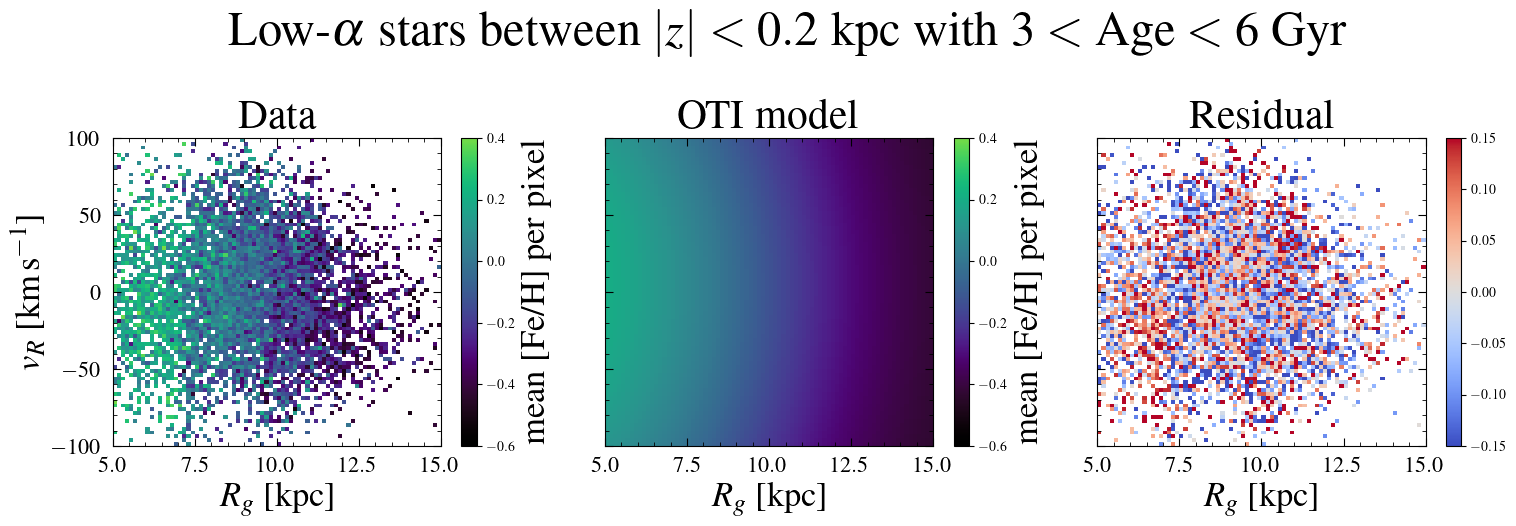

In [113]:
# visualise the data

fig, axes = plt.subplots(1, 3, figsize=(18, 4), sharex=True, sharey=True)
fig.suptitle(r'Low-$\alpha$ stars between $|z|<0.2$ kpc with $3 < \mathrm{Age} < 6$ Gyr', fontsize=35, y=1.2)

ax = axes[0]
ax.set_title('Data', fontsize=30)
cs = ax.pcolormesh(
    bdata["pos"].to_value(u.kpc),
    bdata["vel"].to_value(u.km / u.s),
    bdata["label"],
    vmin=-0.6,
    vmax=0.4,
    cmap=cm.lavender,
)
cb = fig.colorbar(cs, ax=ax)
cb.set_label("mean [Fe/H] per pixel", fontsize=25)
ax.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=6, pad=8)
ax.tick_params(which='minor', length=3, direction='in',top=True,right=True, pad=8)
ax.minorticks_on()
# ax.set_ylim(-100,100)
ax.set_xlim(0,16)

ax = axes[1]
ax.set_title('OTI model', fontsize=30)
model_H = model._get_label(pos=bdata["pos"], vel=bdata["vel"], params=res.params)
cs = ax.pcolormesh(
    bdata["pos"].to_value(u.kpc),
    bdata["vel"].to_value(u.km / u.s),
    model_H,
    vmin=-0.6,
    vmax=0.4,
    cmap=cm.lavender
)
ax.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=6, pad=8)
ax.tick_params(which='minor', length=3, direction='in',top=True,right=True, pad=8)
ax.minorticks_on()
cb = fig.colorbar(cs, ax=ax)
cb.set_label("mean [Fe/H] per pixel", fontsize=25)
# ax.set_ylim(-100,100)
ax.set_xlim(5,15)

ax = axes[2]
ax.set_title('Residual', fontsize=30)
cs = ax.pcolormesh(
    bdata["pos"].to_value(u.kpc),
    bdata["vel"].to_value(u.km / u.s),
    bdata["label"] - model_H,
    vmin=-0.15,
    vmax=0.15,
    cmap='coolwarm'
)

cb = fig.colorbar(cs, ax=ax)
# cb.set_label("Residual")
# ax.set_ylim(-100,100)
ax.set_xlim(5,15)
ax.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=6, pad=8)
ax.tick_params(which='minor', length=3, direction='in',top=True,right=True, pad=8)
ax.minorticks_on()

for ax in axes:
    ax.set_xlabel(f"$R_g$ [{u.kpc:latex_inline}]", fontsize=25)
axes[0].set_ylabel(f"$v_R$ [{u.km/u.s:latex_inline}]", fontsize=25)

For old stars

In [114]:
x_param = Rg * u.kpc
y_param = vR * u.km/u.s
label = data['FE_H']
label_err = data['FE_H_ERR']

mask_z = np.abs(data['xyz'][:,2])<0.2

bdata = oti.data.get_binned_label(
    pos=x_param[wmask3&mask_z].astype(np.float32),
    vel=y_param[wmask3&mask_z].astype(np.float32),
    label=label[wmask3&mask_z].astype(np.float32),
    label_err=label_err[wmask3&mask_z].astype(np.float32),
    bins=bins,
    units=galactic,
    s_N_thresh=2,
)

bdata_clean = dict(
    pos=bdata["pos"],
    vel=bdata["vel"],
    label=bdata["label"],
    label_err=bdata["label_err"],
)
bdata_mask = (
    np.isfinite(bdata["label"])
    & np.isfinite(bdata["label_err"])
    & (bdata["label_err"] > 0)
)
bdata_clean = {k: v[bdata_mask] for k, v in bdata_clean.items()}

In [115]:
res = model.optimize(init_params, objective="gaussian", bounds=bounds, **bdata_clean)
res.state.success, res.state.iter_num

(True, 33)

Text(0, 0.5, '$v_R$ [$\\mathrm{km\\,s^{-1}}$]')

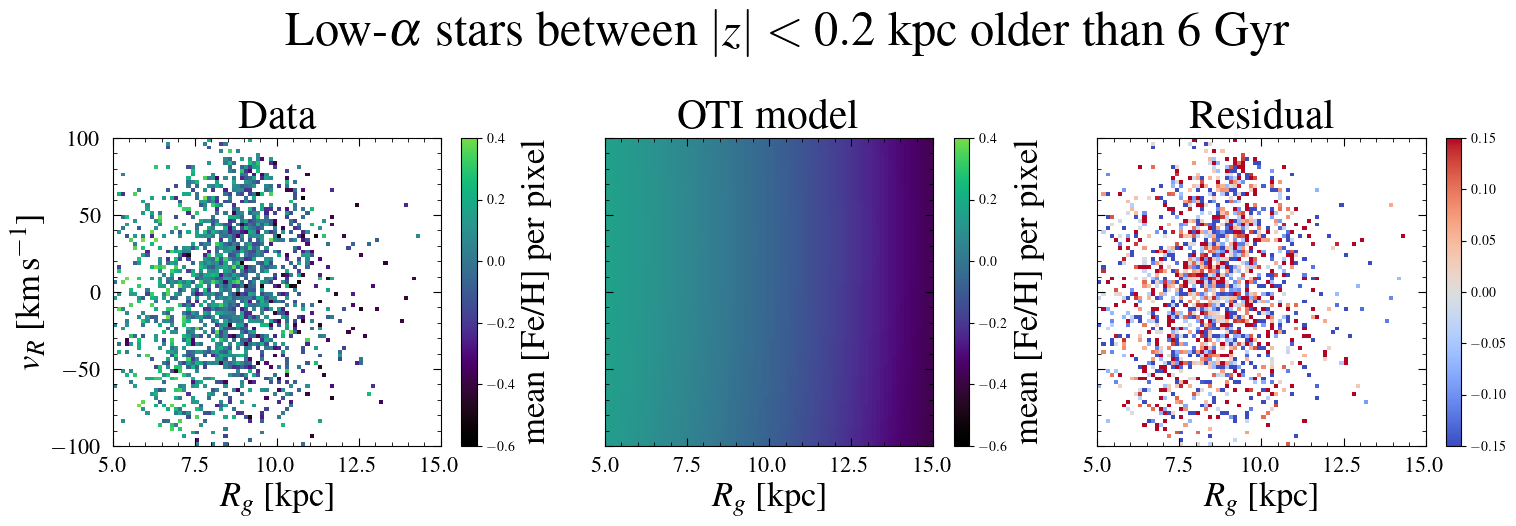

In [116]:
# visualise the data

fig, axes = plt.subplots(1, 3, figsize=(18, 4), sharex=True, sharey=True)
fig.suptitle(r'Low-$\alpha$ stars between $|z|<0.2$ kpc older than 6 Gyr', fontsize=35, y=1.2)

ax = axes[0]
ax.set_title('Data', fontsize=30)
cs = ax.pcolormesh(
    bdata["pos"].to_value(u.kpc),
    bdata["vel"].to_value(u.km / u.s),
    bdata["label"],
    vmin=-0.6,
    vmax=0.4,
    cmap=cm.lavender,
)
cb = fig.colorbar(cs, ax=ax)
cb.set_label("mean [Fe/H] per pixel", fontsize=25)
ax.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=6, pad=8)
ax.tick_params(which='minor', length=3, direction='in',top=True,right=True, pad=8)
ax.minorticks_on()
# ax.set_ylim(-100,100)
ax.set_xlim(0,16)

ax = axes[1]
ax.set_title('OTI model', fontsize=30)
model_H = model._get_label(pos=bdata["pos"], vel=bdata["vel"], params=res.params)
cs = ax.pcolormesh(
    bdata["pos"].to_value(u.kpc),
    bdata["vel"].to_value(u.km / u.s),
    model_H,
    vmin=-0.6,
    vmax=0.4,
    cmap=cm.lavender
)
ax.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=6, pad=8)
ax.tick_params(which='minor', length=3, direction='in',top=True,right=True, pad=8)
ax.minorticks_on()
cb = fig.colorbar(cs, ax=ax)
cb.set_label("mean [Fe/H] per pixel", fontsize=25)
# ax.set_ylim(-100,100)
ax.set_xlim(5,15)

ax = axes[2]
ax.set_title('Residual', fontsize=30)
cs = ax.pcolormesh(
    bdata["pos"].to_value(u.kpc),
    bdata["vel"].to_value(u.km / u.s),
    bdata["label"] - model_H,
    vmin=-0.15,
    vmax=0.15,
    cmap='coolwarm'
)

cb = fig.colorbar(cs, ax=ax)
# cb.set_label("Residual")
# ax.set_ylim(-100,100)
ax.set_xlim(5,15)
ax.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=6, pad=8)
ax.tick_params(which='minor', length=3, direction='in',top=True,right=True, pad=8)
ax.minorticks_on()

for ax in axes:
    ax.set_xlabel(f"$R_g$ [{u.kpc:latex_inline}]", fontsize=25)
axes[0].set_ylabel(f"$v_R$ [{u.km/u.s:latex_inline}]", fontsize=25)